In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.inspection import permutation_importance
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pprint import pprint
import shap

from joblib import Parallel, delayed

shap.initjs()

# Extreme gradient boost multivariate regression
## Sort of incremental training

# Train model, 60-day window, remove size from features

In [82]:
WINDOWSIZE = '60D'

In [100]:
# Load dataset
df = pd.read_csv(f'csv/features/rolling_window_dataset_separate_counts_{WINDOWSIZE}.csv')
df = df.drop(columns=['date_end', 'size'])
df

date_start  dns_recursive_mean  dns_recursive_max  \
0      2016-10-19                 0.0                0.0   
1      2016-10-20                 0.0                0.0   
2      2016-10-21                 0.0                0.0   
3      2016-10-22                 0.0                0.0   
4      2016-10-23                 0.0                0.0   
...           ...                 ...                ...   
89854  2016-12-17                 0.0                0.0   
89855  2016-12-18                 0.0                0.0   
89856  2016-12-19                 0.0                0.0   
89857  2016-12-20                 0.0                0.0   
89858  2016-12-21                 0.0                0.0   

       tls_cert_errors_mean  tls_cert_errors_max  tls_config_errors_mean  \
0                  0.444444                  1.0                     0.0   
1                  0.444444                  1.0                     0.0   
2                  0.444444                  1.0                     0.0   
3                  0.436111                  1.0                     0.0   
4                  0.452778                  1.0                     0.0   
...                     ...                  ...                     ...   
89854              0.000000                  0.0                     0.0   
89855              0.000000                  0.0                     0.0   
89856              0.000000                  0.0                     0.0   
89857              0.000000                  0.0                     0.0   
89858              0.000000                  0.0                     0.0   

       tls_config_errors_max  dns_recursive_mean_last14  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   
...                      ...                        ...   
89854                    0.0                        0.0   
89855                    0.0                        0.0   
89856                    0.0                        0.0   
89857                    0.0                        0.0   
89858                    0.0                        0.0   

       dns_recursive_max_last14  tls_cert_errors_mean_last14  ...  \
0                           0.0                     0.928571  ...   
1                           0.0                     0.964286  ...   
2                           0.0                     1.000000  ...   
3                           0.0                     0.964286  ...   
4                           0.0                     0.964286  ...   
...                         ...                          ...  ...   
89854                       0.0                     0.000000  ...   
89855                       0.0                     0.000000  ...   
89856                       0.0                     0.000000  ...   
89857                       0.0                     0.000000  ...   
89858                       0.0                     0.000000  ...   

       shadowserver_sinkhole_dns_total  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   
...                                ...   
89854                              0.0   
89855                              0.0   
89856                              0.0   
89857                              0.0   
89858                              0.0   

       shadowserver_sinkhole_http_drone_total  shadowserver_spam_url_total  \
0                                         0.0                          0.0   
1                                         0.0                          0.0   
2                                         0.0                          0.0   
3                 

In [103]:
df = df.sort_values('date_start')
train_data = df.iloc[0:round(len(df.index)/2)]
train_data['date_start'] = pd.to_datetime(train_data['date_start'], format='%Y-%m-%d')
train_data  = train_data.drop(columns=['date_start'])

test_data = df.iloc[round(len(df.index)/2):]
test_data['date_start'] = pd.to_datetime(test_data['date_start'], format='%Y-%m-%d')
test_data = test_data.set_index('date_start')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [104]:
if 'customer_id' in test_data.columns:
    customer_ids = test_data[['customer_id']].reset_index(drop=True)
    train_data = train_data.drop(columns=['customer_id'])
    test_data = test_data.drop(columns=['customer_id'])
    display(customer_ids)

customer_id
0              105
1               59
2               81
3                0
4               94
...            ...
44924           71
44925           53
44926           35
44927            6
44928           78

[44929 rows x 1 columns]

In [151]:
test_data

dns_recursive_mean  dns_recursive_max  tls_cert_errors_mean  \
date_start                                                                
2019-02-21                 0.0                0.0              0.000000   
2019-02-21                 0.0                0.0              0.000000   
2019-02-21                 0.0                0.0              0.645833   
2019-02-21                 0.0                0.0              0.312881   
2019-02-21                 0.0                0.0              0.000000   
...                        ...                ...                   ...   
2021-01-23                 0.0                0.0              0.000000   
2021-01-23                 0.0                0.0              0.116667   
2021-01-23                 0.0                0.0              0.000000   
2021-01-23                 0.0                0.0              0.000000   
2021-01-23                 0.0                0.0              0.000000   

            tls_cert_errors_max  tls_config_errors_mean  \
date_start                                                
2019-02-21                  0.0                0.000000   
2019-02-21                  0.0                0.000000   
2019-02-21                  1.0                0.383333   
2019-02-21                  1.0                0.000000   
2019-02-21                  0.0                0.000000   
...                         ...                     ...   
2021-01-23                  0.0                0.000000   
2021-01-23                  1.0                0.000000   
2021-01-23                  0.0                0.000000   
2021-01-23                  0.0                0.000000   
2021-01-23                  0.0                0.000000   

            tls_config_errors_max  dns_recursive_mean_last14  \
date_start                                                     
2019-02-21                    0.0                        0.0   
2019-02-21                    0.0                        0.0   
2019-02-21                    2.0                        0.0   
2019-02-21                    0.0                        0.0   
2019-02-21                    0.0                        0.0   
...                           ...                        ...   
2021-01-23                    0.0                        0.0   
2021-01-23                    0.0                        0.0   
2021-01-23                    0.0                        0.0   
2021-01-23                    0.0                        0.0   
2021-01-23                    0.0                        0.0   

            dns_recursive_max_last14  tls_cert_errors_mean_last14  \
date_start                                                          
2019-02-21                       0.0                     0.000000   
2019-02-21                       0.0                     0.000000   
2019-02-21                       0.0                     0.690476   
2019-02-21                       0.0                     0.391667   
2019-02-21                       0.0                     0.000000   
...                              ...                          ...   
2021-01-23                       0.0                     0.000000   
2021-01-23                       0.0                     0.214286   
2021-01-23                       0.0                     0.000000   
2021-01-23                       0.0                     0.000000   
2021-01-23                       0.0                     0.000000   

            tls_cert_errors_max_last14  ...  shadowserver_scan_xdmcp_total  \
date_start                              ...                                  
2019-02-21                         0.0  ...                            0.0   
2019-02-21                         0.0  ...                            0.0   
2019-02-21                         1.0  ...                            0.0   
2019-02-21                         1.0  ...                            0.0   
2019-02-21                         0.0  ...                          

In [106]:
%%time

x_tr = train_data.copy().drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
y_tr = train_data.copy()[['low_risk', 'high_risk', 'successful_hack_attack']]

mses = []
errors = []
results = []
original_shap_values = [ np.empty((0,len(x_tr.columns))), np.empty((0,len(x_tr.columns))), np.empty((0,len(x_tr.columns))), ]
original_expected_values = {
    'lr': [],
    'hr': [],
    'sha': [],
}

# params = {'colsample_bytree': 0.9722718894876924,
#  'learning_rate': 0.12336834015752808,
#  'max_depth': 9,
#  'n_estimators': 268,
#  'subsample': 0.6891219117705456}

params= {'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 400,
 'subsample': 0.8}

model = XGBRegressor(random_state=13, tree_method='hist', **params)

import time
for i, (name, group) in enumerate(test_data.groupby(pd.Grouper(freq='W'))):
    start = time.time()
    x_te = group.drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
    y_te = group[['low_risk', 'high_risk', 'successful_hack_attack']]

    model.fit(x_tr, y_tr)
    y_pr = model.predict(x_te)

    x_tr = pd.concat([x_tr, x_te])
    y_tr = pd.concat([y_tr, y_te])
    
    explainer1 = shap.TreeExplainer(model)
    shap_values_temp = explainer1.shap_values(x_te)
    for j in range(len(shap_values_temp)):
        old_shap_values = original_shap_values[j]
        new_shap_values = shap_values_temp[j]
        new_shap_values = np.concatenate((old_shap_values, new_shap_values))
        original_shap_values[j] = new_shap_values
        
    original_expected_values['lr'].extend( [explainer1.expected_value[0]]*x_te.shape[0] )
    original_expected_values['hr'].extend( [explainer1.expected_value[1]]*x_te.shape[0] )
    original_expected_values['sha'].extend( [explainer1.expected_value[2]]*x_te.shape[0] )
    
    pred_vs_real = pd.DataFrame(y_pr, columns=['pred lr', 'pred hr', 'pred sha'])
    pred_vs_real = pred_vs_real.join(y_te.reset_index(drop=True))
    results.append(pred_vs_real)
    
    end = time.time()
    duration = round(end-start)
    
    date = name.strftime('%Y-%m-%d')
    
    print(f'{i} -> {date} @ {duration} secs')
    
results = pd.concat(results).reset_index(drop=True)

results

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0 -> 2019-02-24 @ 16 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


1 -> 2019-03-03 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


2 -> 2019-03-10 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


3 -> 2019-03-17 @ 16 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


4 -> 2019-03-24 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


5 -> 2019-03-31 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


6 -> 2019-04-07 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


7 -> 2019-04-14 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


8 -> 2019-04-21 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


9 -> 2019-04-28 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


10 -> 2019-05-05 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


11 -> 2019-05-12 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


12 -> 2019-05-19 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


13 -> 2019-05-26 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


14 -> 2019-06-02 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


15 -> 2019-06-09 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


16 -> 2019-06-16 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


17 -> 2019-06-23 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


18 -> 2019-06-30 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


19 -> 2019-07-07 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


20 -> 2019-07-14 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


21 -> 2019-07-21 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


22 -> 2019-07-28 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


23 -> 2019-08-04 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


24 -> 2019-08-11 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


25 -> 2019-08-18 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


26 -> 2019-08-25 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


27 -> 2019-09-01 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


28 -> 2019-09-08 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


29 -> 2019-09-15 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


30 -> 2019-09-22 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


31 -> 2019-09-29 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


32 -> 2019-10-06 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


33 -> 2019-10-13 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


34 -> 2019-10-20 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


35 -> 2019-10-27 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


36 -> 2019-11-03 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


37 -> 2019-11-10 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


38 -> 2019-11-17 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


39 -> 2019-11-24 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


40 -> 2019-12-01 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


41 -> 2019-12-08 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


42 -> 2019-12-15 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


43 -> 2019-12-22 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


44 -> 2019-12-29 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


45 -> 2020-01-05 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


46 -> 2020-01-12 @ 27 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


47 -> 2020-01-19 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


48 -> 2020-01-26 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


49 -> 2020-02-02 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


50 -> 2020-02-09 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


51 -> 2020-02-16 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


52 -> 2020-02-23 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


53 -> 2020-03-01 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


54 -> 2020-03-08 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


55 -> 2020-03-15 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


56 -> 2020-03-22 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


57 -> 2020-03-29 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


58 -> 2020-04-05 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


59 -> 2020-04-12 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


60 -> 2020-04-19 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


61 -> 2020-04-26 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


62 -> 2020-05-03 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


63 -> 2020-05-10 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


64 -> 2020-05-17 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


65 -> 2020-05-24 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


66 -> 2020-05-31 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


67 -> 2020-06-07 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


68 -> 2020-06-14 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


69 -> 2020-06-21 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


70 -> 2020-06-28 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


71 -> 2020-07-05 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


72 -> 2020-07-12 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


73 -> 2020-07-19 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


74 -> 2020-07-26 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


75 -> 2020-08-02 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


76 -> 2020-08-09 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


77 -> 2020-08-16 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


78 -> 2020-08-23 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


79 -> 2020-08-30 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


80 -> 2020-09-06 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


81 -> 2020-09-13 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


82 -> 2020-09-20 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


83 -> 2020-09-27 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


84 -> 2020-10-04 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


85 -> 2020-10-11 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


86 -> 2020-10-18 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


87 -> 2020-10-25 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


88 -> 2020-11-01 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


89 -> 2020-11-08 @ 28 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


90 -> 2020-11-15 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


91 -> 2020-11-22 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


92 -> 2020-11-29 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


93 -> 2020-12-06 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


94 -> 2020-12-13 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


95 -> 2020-12-20 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


96 -> 2020-12-27 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


97 -> 2021-01-03 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


98 -> 2021-01-10 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


99 -> 2021-01-17 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


100 -> 2021-01-24 @ 21 secs
CPU times: user 1d 50min 34s, sys: 1h 38min 55s, total: 1d 2h 29min 30s
Wall time: 33min 53s


pred lr   pred hr  pred sha  low_risk  high_risk  \
0      3.384019  2.069463  0.047297       0.0        0.0   
1      3.384019  2.069463  0.047297       0.0        0.0   
2     -0.181314  0.867198 -0.000137       0.0        0.0   
3     -0.144442  0.082901 -0.000134       0.0        0.0   
4      3.384019  2.069463  0.047297       3.0        0.0   
...         ...       ...       ...       ...        ...   
44924  3.723856  2.452571  0.170177       0.0        0.0   
44925  0.600794  0.655705  0.003484       0.0        0.0   
44926  3.723856  2.452571  0.170177      25.0        1.0   
44927  3.723856  2.452571  0.170177       0.0        1.0   
44928  3.723856  2.452571  0.170177       0.0        0.0   

       successful_hack_attack  
0                         0.0  
1                         0.0  
2                         0.0  
3                         0.0  
4                         0.0  
...                       ...  
44924                     0.0  
44925                     0.0  
44926                     0.0  
44927                     0.0  
44928                     0.0  

[44929 rows x 6 columns]

In [107]:
results_customers = results.join(test_data.reset_index()['date_start'], how='inner').join(customer_ids)
results_customers

def stats_group(group):
    r2_lr = r2_score(group['low_risk'], group['pred lr'], )
    r2_hr = r2_score(group['high_risk'], group['pred hr'], )
    r2_sha = r2_score(group['successful_hack_attack'], group['pred sha'],)
    
    mae_lr = mean_absolute_error(group['low_risk'], group['pred lr'], )
    mae_hr = mean_absolute_error(group['high_risk'], group['pred hr'], )
    mae_sha = mean_absolute_error(group['successful_hack_attack'], group['pred sha'],)
    return pd.Series({'R2 Low Risk': r2_lr, 'R2 High Risk': r2_hr, 'R2 Successful Hack Attack': r2_sha,
                     'MAE Low Risk': mae_lr, 'MAE High Risk': mae_hr, 'MAE Successful Hack Attack': mae_sha})
    
    
results_customers = results_customers.groupby('customer_id').apply(stats_group)
results_customers.sort_values('customer_id')

R2 Low Risk  R2 High Risk  R2 Successful Hack Attack  \
customer_id                                                         
0               0.106660     -3.152621                   0.000000   
1               0.793491      0.694066                  -1.618589   
4              -0.154863     -1.804854                  -0.054393   
5             -43.606827    -80.969458                   0.000000   
6              -6.048134     -0.036921                   0.020562   
...                  ...           ...                        ...   
102           -11.118465     -1.129935                   0.000000   
103             0.304474      0.424532                   0.648638   
104          -152.290831     -2.718448                   0.000000   
105           -15.436152      0.000000                   0.000000   
106            -1.281591   -822.278433                   0.000000   

             MAE Low Risk  MAE High Risk  MAE Successful Hack Attack  
customer_id                                                           
0                0.673165       0.401736                    0.033297  
1                1.556005       3.290800                    0.064775  
4                2.412944       1.661292                    0.254200  
5                0.667310       0.679188                    0.003175  
6                2.692308       4.323720                    0.181330  
...                   ...            ...                         ...  
102              0.453672       0.635644                    0.023181  
103              0.330969       1.662011                    0.044625  
104              3.443311       2.105987                    0.122031  
105              3.187181       2.186356                    0.121925  
106              0.561158       0.892854                    0.036623  

[73 rows x 6 columns]

In [158]:
(results_customers['MAE Successful Hack Attack'] < 0.33).sum()

64

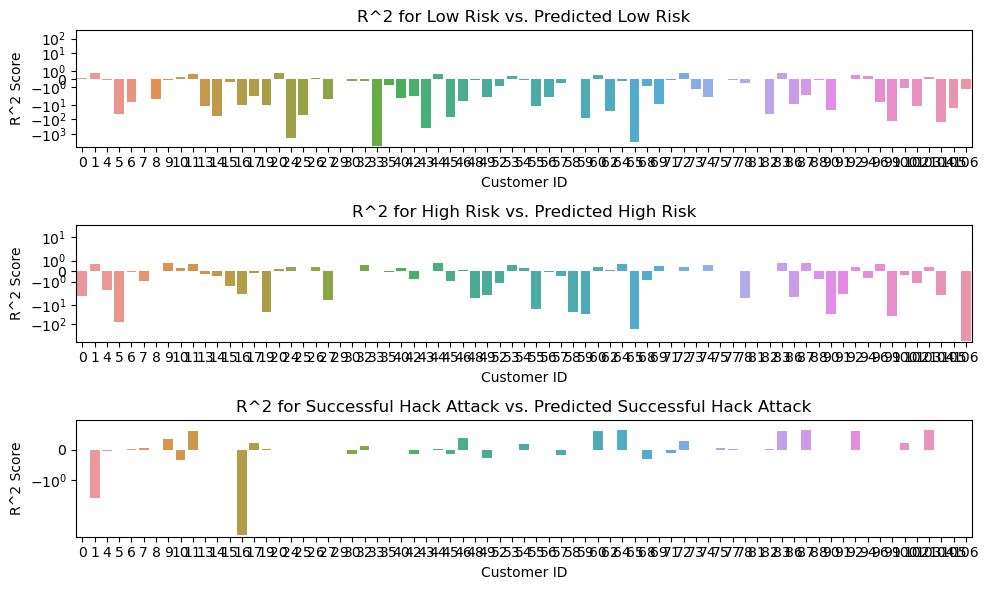

In [161]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(10, 6))

# Plot for R^2 Low Risk
sns.barplot(x=results_customers.index, y='R2 Low Risk', data=results_customers, ax=axes[0])
axes[0].set_title('R^2 for Low Risk vs. Predicted Low Risk')
axes[0].set_ylabel('R^2 Score')
axes[0].set_xlabel('Customer ID')
axes[0].set_yscale('symlog')

# Plot for R^2 High Risk
sns.barplot(x=results_customers.index, y='R2 High Risk', data=results_customers, ax=axes[1])
axes[1].set_title('R^2 for High Risk vs. Predicted High Risk')
axes[1].set_ylabel('R^2 Score')
axes[1].set_xlabel('Customer ID')
axes[1].set_yscale('symlog')

# Plot for R^2 Successful Hack Attack
sns.barplot(x=results_customers.index, y='R2 Successful Hack Attack', data=results_customers, ax=axes[2])
axes[2].set_title('R^2 for Successful Hack Attack vs. Predicted Successful Hack Attack')
axes[2].set_ylabel('R^2 Score')
axes[2].set_xlabel('Customer ID')
axes[2].set_yscale('symlog')

# Adjusting the layout
plt.tight_layout()
plt.show()

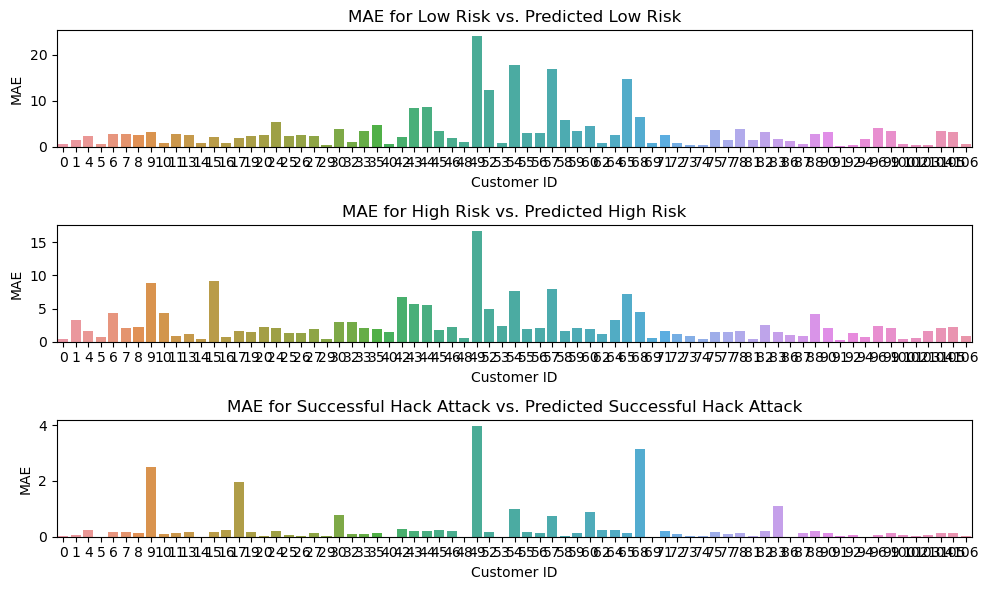

In [109]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(10, 6))

# Plot for R^2 Low Risk
sns.barplot(x=results_customers.index, y='MAE Low Risk', data=results_customers, ax=axes[0])
axes[0].set_title('MAE for Low Risk vs. Predicted Low Risk')
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Customer ID')

# Plot for R^2 High Risk
sns.barplot(x=results_customers.index, y='MAE High Risk', data=results_customers, ax=axes[1])
axes[1].set_title('MAE for High Risk vs. Predicted High Risk')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Customer ID')

# Plot for R^2 Successful Hack Attack
sns.barplot(x=results_customers.index, y='MAE Successful Hack Attack', data=results_customers, ax=axes[2])
axes[2].set_title('MAE for Successful Hack Attack vs. Predicted Successful Hack Attack')
axes[2].set_ylabel('MAE')
axes[2].set_xlabel('Customer ID')

# Adjusting the layout
plt.tight_layout()
plt.show()

<AxesSubplot: >

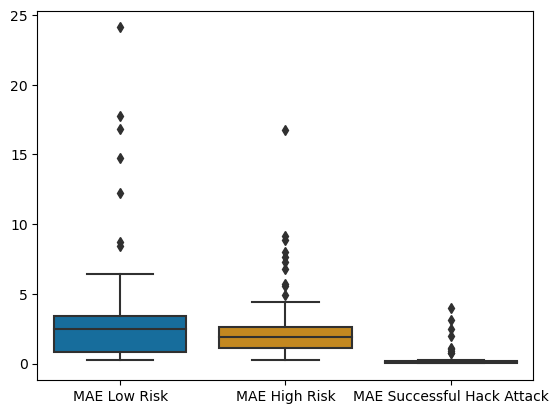

In [128]:
sns.boxplot(data=results_customers[['MAE Low Risk', 'MAE High Risk', 'MAE Successful Hack Attack']])

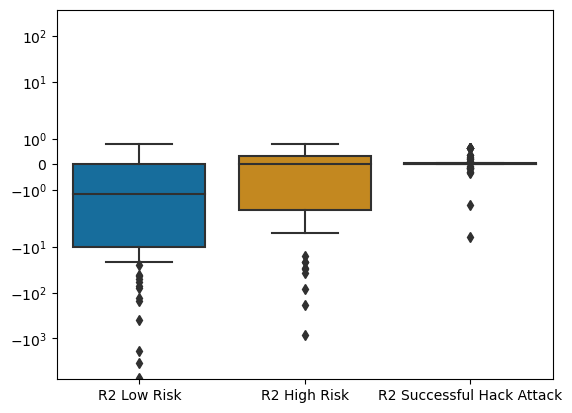

In [133]:
fig, ax = plt.subplots()
sns.boxplot(data=results_customers[['R2 Low Risk', 'R2 High Risk', 'R2 Successful Hack Attack']], ax=ax)
ax.set_yscale('symlog')

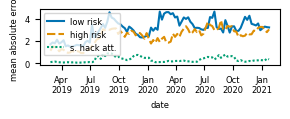

In [113]:
def calc_errors(group, error_type='mae'):
    error_type = error_type.lower()
    
    if error_type == 'rmse':
        lr = mean_squared_error(group['low_risk'], group['pred lr'], squared=False)
        hr = mean_squared_error(group['high_risk'], group['pred hr'], squared=False)
        sha = mean_squared_error(group['successful_hack_attack'], group['pred sha'], squared=False)
    elif error_type == 'mae':
        lr = mean_absolute_error(group['low_risk'], group['pred lr'])
        hr = mean_absolute_error(group['high_risk'], group['pred hr'])
        sha = mean_absolute_error(group['successful_hack_attack'], group['pred sha'])
    elif error_type == 'r2':
        lr = r2_score(group['low_risk'], group['pred lr'])
        hr = r2_score(group['high_risk'], group['pred hr'])
        sha = r2_score(group['successful_hack_attack'], group['pred sha'])
    else:
        raise Exception('unknown error type.')
    
    result = pd.Series([lr, hr, sha])
    return result

error_type = 'mae'

errors_per_week = results.join(test_data.reset_index()['date_start'])
errors_per_week = errors_per_week.set_index('date_start').groupby(pd.Grouper(freq='W'))
errors_per_week = errors_per_week.apply(
    lambda group: calc_errors(group, error_type=error_type)
).rename(columns={0: 'low risk', 1: 'high risk', 2: 's. hack att.'})

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(3, 1.3))

sns.set_palette("colorblind")

sns.lineplot(data=errors_per_week, ax=ax)

ax.set_xlabel('date', fontsize=6)
ax.set_ylabel('mean absolute error', fontsize=6)
ax.legend(loc='upper left', fontsize=6)

# Format x-axis ticks to display only the year
date_format = mdates.DateFormatter('%b\n%Y')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(date_format)

# Set font size for axis labels
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

# ax.set_ylim([0,1])

# plt.yscale('log')

plt.tight_layout()
plt.show()

    
if error_type == 'rmse':
    fig.savefig('figures/rmse.pdf', bbox_inches='tight')
elif error_type == 'mae':
    fig.savefig('figures/mean-absolute-error.pdf', bbox_inches='tight')
elif error_type == 'r2':
    fig.savefig('figures/r2-scores.pdf', bbox_inches='tight')

plt.close()

In [111]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import numpy as np
rho = errors_per_week.corr()
pval = errors_per_week.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p


low risk high risk s. hack att.
low risk       1.0***   0.65***       0.25**
high risk     0.65***    1.0***      0.63***
s. hack att.   0.25**   0.63***       1.0***

In [112]:
print('Low Risk Mean Absolute Error:', mean_absolute_error(results['low_risk'], results['pred lr'], ))
print('High Risk Mean Absolute Error:', mean_absolute_error(results['high_risk'], results['pred hr'], ))
print('Successful hack attack Mean Absolute Error:', mean_absolute_error(results['successful_hack_attack'], results['pred sha'],))

Low Risk Mean Absolute Error: 3.1295184866350145
High Risk Mean Absolute Error: 2.448119687950436
Successful hack attack Mean Absolute Error: 0.32691869099722165


In [114]:
print('Low Risk Root Mean Squared Error:', mean_squared_error(results['low_risk'], results['pred lr'], squared=False))
print('High Risk Root Mean Squared Error:', mean_squared_error(results['high_risk'], results['pred hr'], squared=False))
print('Successful hack attack Root Mean Squared Error:', mean_squared_error(results['successful_hack_attack'], results['pred sha'], squared=False))

Low Risk Root Mean Squared Error: 8.386601017962525
High Risk Root Mean Squared Error: 5.298346587703461
Successful hack attack Root Mean Squared Error: 1.8488509012484007


In [115]:
print('Low Risk R2 score:', r2_score(results['low_risk'], results['pred lr'], ))
print('High Risk R2 score:', r2_score(results['high_risk'], results['pred hr'], ))
print('Successful R2 score:', r2_score(results['successful_hack_attack'], results['pred sha'],))

Low Risk R2 score: 0.14986459008047592
High Risk R2 score: 0.5831472707316121
Successful R2 score: 0.28777508433274634


In [116]:
nonzero_results = results.copy()
nonzero_results[nonzero_results < 0] = 0

print('Low Risk nonzero R2 score:', r2_score(nonzero_results['low_risk'], nonzero_results['pred lr'], ))
print('High Risk nonzero R2 score:', r2_score(nonzero_results['high_risk'], nonzero_results['pred hr'], ))
print('Successful nonzero R2 score:', r2_score(nonzero_results['successful_hack_attack'], nonzero_results['pred sha'],))

Low Risk nonzero R2 score: 0.1514798945965693
High Risk nonzero R2 score: 0.5833289453970794
Successful nonzero R2 score: 0.2881633637007164


In [117]:
print('Total MAE:', mean_absolute_error(results[['low_risk', 'high_risk', 'successful_hack_attack']], results[['pred lr', 'pred hr', 'pred sha']], ))
print('Total RMSE:', mean_squared_error(results[['low_risk', 'high_risk', 'successful_hack_attack']], results[['pred lr', 'pred hr', 'pred sha']],squared=False ))
print('Total Risk R2 score:', r2_score(results[['low_risk', 'high_risk', 'successful_hack_attack']], results[['pred lr', 'pred hr', 'pred sha']], ))

Total MAE: 1.9681856218608906
Total RMSE: 5.177932835638129
Total Risk R2 score: 0.34026231504827814


In [118]:
def adjusted_r2_score(y_test, y_pred, n_test_samples, n_features):    
    # Number of test samples
    n = n_test_samples

    # Number of features/predictors
    p = n_features
    
    r2 = r2_score(y_test, y_pred)

    # adjusted R^2 formula
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    return adjusted_r2

n_test_samples = len(test_data.index)
n_features = len(x_tr.columns.values)

print('Low Risk ADJUSTED R2 score:', adjusted_r2_score(results['low_risk'], results['pred lr'], n_test_samples, n_features))
print('High Risk ADJUSTED R2 score:', adjusted_r2_score(results['high_risk'], results['pred hr'], n_test_samples, n_features))
print('Successful ADJUSTED R2 score:', adjusted_r2_score(results['successful_hack_attack'], results['pred sha'],n_test_samples, n_features))

Low Risk ADJUSTED R2 score: 0.14338199298321563
High Risk ADJUSTED R2 score: 0.5799686144126193
Successful ADJUSTED R2 score: 0.2823441057885895


In [119]:
# Test model on all original test data
x_te_original = test_data.drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
y_te_original = test_data[['low_risk', 'high_risk', 'successful_hack_attack']]

y_pred_original = model.predict(x_te_original)

In [120]:
# RMSE of the final model predicting the original test data

y_pred_original_df = pd.DataFrame(y_pred_original, columns=['pred lr', 'pred hr', 'pred sha'])
y_pred_original_df = y_pred_original_df.join(y_te_original.reset_index(drop=True))

print('Low Risk Root Mean Squared Error:', mean_squared_error(y_pred_original_df['low_risk'], y_pred_original_df['pred lr'], squared=False))
print('High Risk Root Mean Squared Error:', mean_squared_error(y_pred_original_df['high_risk'], y_pred_original_df['pred hr'], squared=False))
print('Successful hack attack Root Mean Squared Error:', mean_squared_error(y_pred_original_df['successful_hack_attack'], y_pred_original_df['pred sha'], squared=False))

Low Risk Root Mean Squared Error: 6.681285183652186
High Risk Root Mean Squared Error: 4.049191967533883
Successful hack attack Root Mean Squared Error: 1.425077449702894


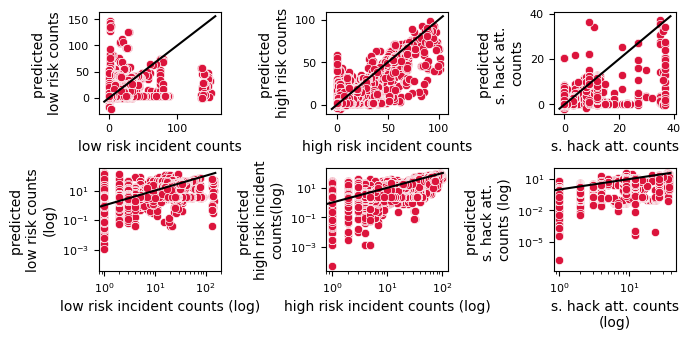

In [121]:
# Plot real incident counts against predicted counts

# graph_df = y_test.reset_index(drop=True).join(pd.DataFrame(y_pred, columns=['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack'])).join(features5)

graph_df = results.copy().rename(columns={'pred lr': 'pred_low_risk', 'pred hr':'pred_high_risk', 'pred sha':'pred_successful_hack_attack'})

# graph_df['pred_low_risk'] = np.round(graph_df['pred_low_risk'])
# graph_df['pred_high_risk'] = np.round(graph_df['pred_high_risk'])
# graph_df['pred_successful_hack_attack'] = np.round(graph_df['pred_successful_hack_attack'])

all_cols = graph_df.columns.values
avg_freq_cols = [x for x in graph_df.columns.values if x.startswith('freq') or x.startswith('avg_')]
select_cols = list(set(all_cols) - set(['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack', 'low_risk', 'high_risk', 'successful_hack_attack']) - set(avg_freq_cols))

fig, ax = plt.subplots(2,3,figsize=(7,3.5))
g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[0][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][0].set_xlabel('low risk incident counts', fontsize=10)
ax[0][0].set_ylabel('predicted \nlow risk counts', fontsize=10)
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[0][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][1].set_xlabel('high risk incident counts', fontsize=10)
ax[0][1].set_ylabel('predicted \nhigh risk counts', fontsize=10)
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[0][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][2].set_xlabel('s. hack att. counts', fontsize=10)
ax[0][2].set_ylabel('predicted \ns. hack att. \ncounts', fontsize=10)
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[1][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][0].set_xlabel('low risk incident counts (log)', fontsize=10)
ax[1][0].set_ylabel('predicted \nlow risk counts\n(log)', fontsize=10)
ax[1][0].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[1][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][1].set_xlabel('high risk incident counts (log)', fontsize=10)
ax[1][1].set_ylabel('predicted \nhigh risk incident\ncounts(log)', fontsize=10)
ax[1][1].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[1][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][2].set_xlabel('s. hack att. counts\n(log)', fontsize=10)
ax[1][2].set_ylabel('predicted \ns. hack att. \ncounts (log)', fontsize=10)
ax[1][2].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i][j].tick_params(labelsize=8)

plt.tight_layout()

fig.savefig('figures/real-vs-pred.pdf', bbox_inches='tight')
fig.savefig('figures/real-vs-pred.png', bbox_inches='tight')

In [2372]:
# cluster = results[(results['low_risk'] > 100) & (results['pred lr'] <100)]
# cluster = test_data.reset_index().join(cluster[[]], how='inner')

test_data_w_index = test_data.reset_index()
# mask = ((test_data_w_index == 0).sum(axis=1) < 322)
# nonsparse = test_data.reset_index()[mask]
# nonsparse

number_of_columns = len(test_data_w_index.columns.values) - 4
empty_feature_sums = (test_data_w_index.drop(columns=['low_risk', 'high_risk', 
                                                      'successful_hack_attack', 'date_start']) == 0).sum(axis=1)

r2scores_lr = [0]*number_of_columns
r2scores_hr = [0]*number_of_columns
r2scores_sha = [0]*number_of_columns
r2scores_total = [0]*number_of_columns

mae_lr = [0]*number_of_columns
mae_hr = [0]*number_of_columns
mae_sha = [0]*number_of_columns
mae_total = [0]*number_of_columns

for i in range(number_of_columns):
    mask = (empty_feature_sums < i)
    if mask.sum() == 0:
        continue
    nonsparse = test_data_w_index[mask]
    temp_results = results.join(nonsparse[[]], how='inner')
    r2scores_lr[i] = r2_score(temp_results['low_risk'], temp_results['pred lr'], )
    r2scores_hr[i] = r2_score(temp_results['high_risk'], temp_results['pred hr'], )
    r2scores_sha[i] = r2_score(temp_results['successful_hack_attack'], temp_results['pred sha'], )
    r2scores_total[i] = r2_score(temp_results[['low_risk', 'high_risk', 'successful_hack_attack']], temp_results[['pred lr', 'pred hr', 'pred sha']], )
    
    mae_lr[i] = mean_absolute_error(temp_results['low_risk'], temp_results['pred lr'], )
    mae_hr[i] = mean_absolute_error(temp_results['high_risk'], temp_results['pred hr'], )
    mae_sha[i] = mean_absolute_error(temp_results['successful_hack_attack'], temp_results['pred sha'], )
    mae_total[i] = mean_absolute_error(temp_results[['low_risk', 'high_risk', 'successful_hack_attack']], temp_results[['pred lr', 'pred hr', 'pred sha']], )

In [2373]:
len(r2scores_lr)

340

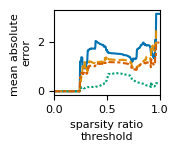

In [2374]:
# Create a figure and a set of subplots
sns.set_palette('colorblind')
fig, ax = plt.subplots(figsize=(1.8,1.5))


# Plot each list
# ax.plot([x/number_of_columns for x in range(number_of_columns)], mae_lr, label='low risk')
# ax.plot([x/number_of_columns for x in range(number_of_columns)], mae_hr, label='high risk')
# ax.plot([x/number_of_columns for x in range(number_of_columns)], mae_sha, label='s. hack att.')
# ax.plot([x/number_of_columns for x in range(number_of_columns)], mae_total, '--', label='total')

ratios = [x/number_of_columns for x in range(number_of_columns)]

mae_df = pd.DataFrame(np.array([ratios, mae_lr, mae_hr, mae_sha, mae_total]).transpose(),
                      columns=['ratios', 'low risk', 'high risk', 's. hack att.', 'total'])
mae_df = mae_df.set_index('ratios')

sns.lineplot(data=mae_df, ax=ax, legend=False)

# Add legend
# ax.legend(show=False)
ax.set_xlabel('sparsity ratio\nthreshold', fontsize=8)
ax.set_ylabel('mean absolute \nerror', fontsize=8)
ax.tick_params(labelsize=8)

# Show the plot
plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.tight_layout()
plt.show()

fig.savefig('figures/sparsity-vs-mae.pdf', bbox_inches='tight')

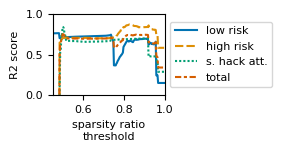

In [2375]:
# Create a figure and a set of subplots
sns.set_palette('colorblind')
fig, ax = plt.subplots(figsize=(2.8,1.5))


# Plot each list

ratios = [x/number_of_columns for x in range(number_of_columns)]

r2_df = pd.DataFrame(np.array([ratios, r2scores_lr, r2scores_hr, r2scores_sha, r2scores_total]).transpose(),
                      columns=['ratios', 'low risk', 'high risk', 's. hack att.', 'total'])
r2_df = r2_df.set_index('ratios')

sns.lineplot(data=r2_df, ax=ax)

# Add legend
# ax.legend(fontsize=8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
ax.set_xlabel('sparsity ratio\nthreshold', fontsize=8)
ax.set_ylabel('R2 score', fontsize=8)
ax.tick_params(labelsize=8)

# Show the plot
# plt.xlim([300,336])
plt.xlim([0.45, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

fig.savefig('figures/sparsity-vs-r2score.pdf', bbox_inches='tight')

In [123]:
# cluster = results[(results['low_risk'] > 100) & (results['pred lr'] <100)]
# cluster = test_data.reset_index().join(cluster[[]], how='inner')

test_data_w_index = test_data.reset_index()
mask = (
    (test_data_w_index.drop(
        columns=['low_risk', 'high_risk', 'successful_hack_attack', 'date_start']) == 0).sum(axis=1) < 319)
nonsparse = test_data.reset_index()[mask]
nonsparse = results.join(nonsparse[[]], how='inner')
nonsparse

pred lr    pred hr  pred sha  low_risk  high_risk  \
2      -0.181314   0.867198 -0.000137       0.0        0.0   
3      -0.144442   0.082901 -0.000134       0.0        0.0   
5       0.074406   0.144225 -0.000865       0.0        0.0   
6      14.440045  74.521317  1.542136      15.0       80.0   
7       0.060400  -0.120200 -0.000107       0.0        0.0   
...          ...        ...       ...       ...        ...   
44915   0.611213  10.142035  1.603968       0.0        7.0   
44917   1.886343   2.011563 -0.003201       4.0        2.0   
44921  25.844404  -0.024238  0.016038      34.0        0.0   
44922   0.450935   1.583579  0.018868       0.0        0.0   
44925   0.600794   0.655705  0.003484       0.0        0.0   

       successful_hack_attack  
2                         0.0  
3                         0.0  
5                         0.0  
6                         2.0  
7                         0.0  
...                       ...  
44915                     3.0  
44917                     0.0  
44921                     0.0  
44922                     0.0  
44925                     0.0  

[17480 rows x 6 columns]

In [124]:
nonsparse[nonsparse < 0] = 0

In [125]:
nonsparse.describe()

pred lr       pred hr      pred sha      low_risk     high_risk  \
count  17480.000000  17480.000000  17480.000000  17480.000000  17480.000000   
mean       2.994862      3.833195      0.240972      2.814760      4.159211   
std        6.216021      8.872771      1.416632      6.679046     10.616291   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.166461      0.222997      0.000000      0.000000      0.000000   
50%        0.904298      1.106232      0.000200      0.000000      1.000000   
75%        2.979851      3.118593      0.015143      3.000000      3.000000   
max      111.557419     98.694519     36.988419     79.000000    101.000000   

       successful_hack_attack  
count            17480.000000  
mean                 0.313330  
std                  2.306148  
min                  0.000000  
25%                  0.000000  
50%                  0.000000  
75%                  0.000000  
max                 37.000000

In [152]:
nonsparse_customers = nonsparse.join(customer_ids)
nonsparse_customers

def stats_group(group):
    r2_lr = r2_score(group['low_risk'], group['pred lr'], )
    r2_hr = r2_score(group['high_risk'], group['pred hr'], )
    r2_sha = r2_score(group['successful_hack_attack'], group['pred sha'],)
    
    mae_lr = mean_absolute_error(group['low_risk'], group['pred lr'], )
    mae_hr = mean_absolute_error(group['high_risk'], group['pred hr'], )
    mae_sha = mean_absolute_error(group['successful_hack_attack'], group['pred sha'],)
    return pd.Series({'R2 Low Risk': r2_lr, 'R2 High Risk': r2_hr, 'R2 Successful Hack Attack': r2_sha,
                     'MAE Low Risk': mae_lr, 'MAE High Risk': mae_hr, 'MAE Successful Hack Attack': mae_sha})
    
    
nonsparse_customers = nonsparse_customers.groupby('customer_id').apply(stats_group)
nonsparse_customers.sort_values('customer_id')

R2 Low Risk  R2 High Risk  R2 Successful Hack Attack  \
customer_id                                                         
0               0.136614     -3.142480                   0.000000   
1               0.793097      0.693066                  -1.564763   
5               0.177855      0.664666                   0.000000   
9              -0.108643      0.746823                   0.354662   
10              0.464801      0.356686                   0.323152   
11              0.554507      0.689459                   0.628766   
14          -2956.775933     -0.331429                   0.000000   
16             -9.803556     -2.355560                  -6.013963   
17             -1.539504     -1.699935                   0.000000   
24          -1843.164782      0.368958                   0.000000   
25             -3.311345      0.000000                   0.000000   
26              0.128223      0.418850                   0.000000   
29              0.000000      0.000000                   0.000000   
32             -0.172979      0.558390                   0.122779   
33           -174.950782      0.000000                   0.000000   
40             -3.295967      0.379896                   0.000000   
44              0.578054      0.780756                   0.042611   
46             -4.022591      0.615449                   0.282583   
48             -1.581066    -31.687072                   0.000000   
49              0.707497      0.092045                  -0.009019   
53              0.443995      0.679400                   0.000000   
54             -0.237258      0.228537                   0.557101   
58              0.000000    -21.637647                   0.000000   
60              0.409330     -0.265116                   0.436258   
62             -0.707827     -0.518428                   0.000000   
64             -0.190743      0.662892                   0.642907   
69             -7.946357      0.460739                   0.000000   
72              0.770604      0.442032                  -0.255046   
73             -0.910460     -0.945869                   0.000000   
74             -6.874970      0.743434                   0.000000   
81              0.000000      0.000000                   0.000000   
83              0.809569      0.744311                   0.625865   
86              0.000000     -0.092475                   0.000000   
87             -1.882815      0.733631                   0.646083   
91              0.000000      0.000000                   0.000000   
92              0.457094      0.407043                   0.639192   
94              0.405207     -0.569007                   0.000000   
96             -5.684196      0.714676                   0.000000   
100            -2.076926     -1.347165                   0.205045   
102            -7.428283     -2.432016                   0.000000   
103             0.210073      0.359033                   0.631554   
106            -1.109856   -824.230033                   0.000000   

             MAE Low Risk  MAE High Risk  MAE Successful Hack Attack  
customer_id                                                           
0                0.642464       0.388939                    0.028428  
1                1.563053       3.314104                    0.058027  
5                0.262851       0.117102                    0.000967  
9                3.377287       9.324787                    2.725961  
10               0.673060       3.830203                    0.078464  
11               2.872947       0.842948                    0.121597  
14               0.776150       0.360759                    0.000722  
16               0.832297       0.760948                    0.242087  
17               1.722982       1.535674                    0.007931  
24               5.251617       2.070999                    0.207763  
25               0.628925       0.256133                    0.120462  
26               2.601796       1.249386             

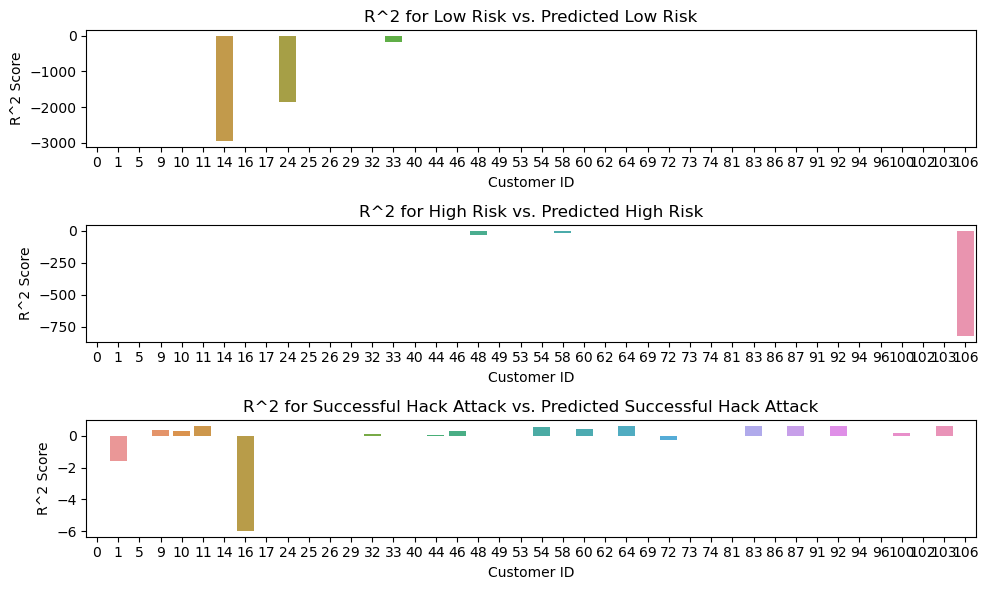

In [139]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(10, 6))

# Plot for R^2 Low Risk
sns.barplot(x=nonsparse_customers.index, y='R2 Low Risk', data=nonsparse_customers, ax=axes[0])
axes[0].set_title('R^2 for Low Risk vs. Predicted Low Risk')
axes[0].set_ylabel('R^2 Score')
axes[0].set_xlabel('Customer ID')

# Plot for R^2 High Risk
sns.barplot(x=nonsparse_customers.index, y='R2 High Risk', data=nonsparse_customers, ax=axes[1])
axes[1].set_title('R^2 for High Risk vs. Predicted High Risk')
axes[1].set_ylabel('R^2 Score')
axes[1].set_xlabel('Customer ID')

# Plot for R^2 Successful Hack Attack
sns.barplot(x=nonsparse_customers.index, y='R2 Successful Hack Attack', data=nonsparse_customers, ax=axes[2])
axes[2].set_title('R^2 for Successful Hack Attack vs. Predicted Successful Hack Attack')
axes[2].set_ylabel('R^2 Score')
axes[2].set_xlabel('Customer ID')

# Adjusting the layout
plt.tight_layout()
plt.show()

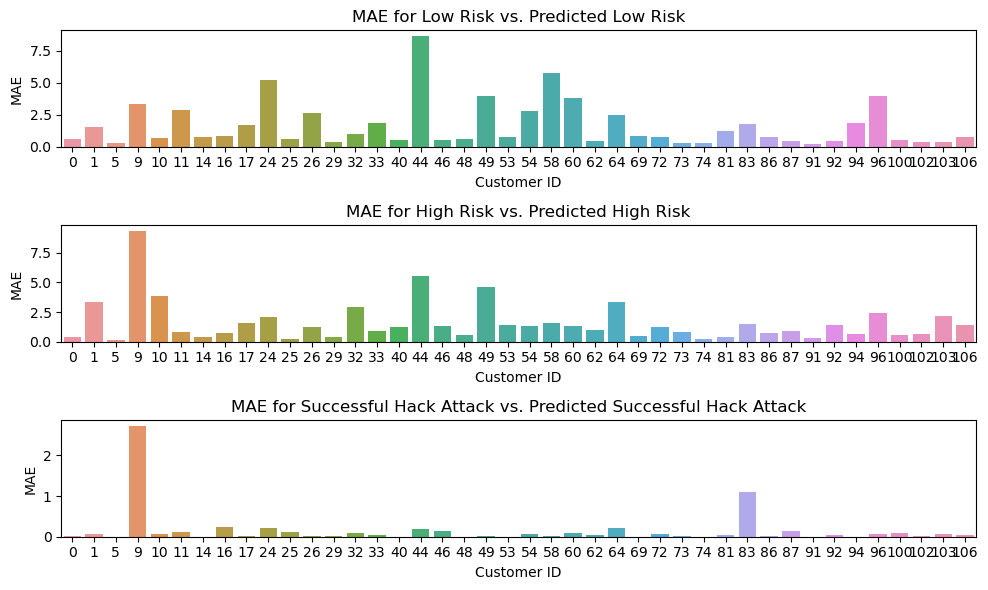

In [140]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(10, 6))

# Plot for R^2 Low Risk
sns.barplot(x=nonsparse_customers.index, y='MAE Low Risk', data=nonsparse_customers, ax=axes[0])
axes[0].set_title('MAE for Low Risk vs. Predicted Low Risk')
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Customer ID')

# Plot for R^2 High Risk
sns.barplot(x=nonsparse_customers.index, y='MAE High Risk', data=nonsparse_customers, ax=axes[1])
axes[1].set_title('MAE for High Risk vs. Predicted High Risk')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Customer ID')

# Plot for R^2 Successful Hack Attack
sns.barplot(x=nonsparse_customers.index, y='MAE Successful Hack Attack', data=nonsparse_customers, ax=axes[2])
axes[2].set_title('MAE for Successful Hack Attack vs. Predicted Successful Hack Attack')
axes[2].set_ylabel('MAE')
axes[2].set_xlabel('Customer ID')

# Adjusting the layout
plt.tight_layout()
plt.show()

<AxesSubplot: >

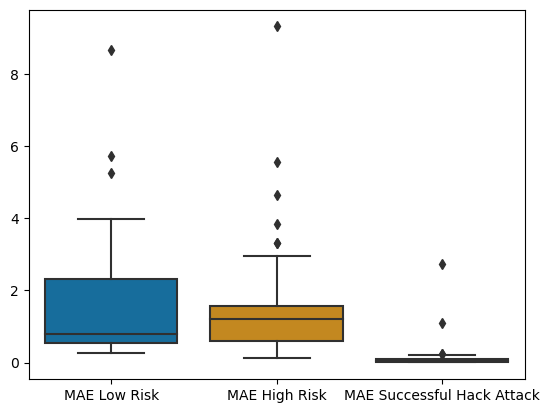

In [137]:
sns.boxplot(data=nonsparse_customers[['MAE Low Risk', 'MAE High Risk', 'MAE Successful Hack Attack']])

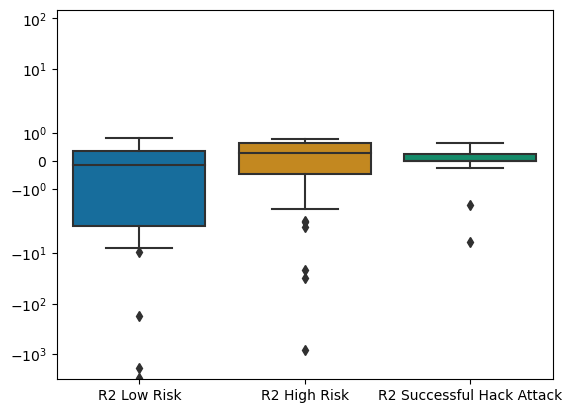

In [138]:
fig, ax = plt.subplots()
sns.boxplot(data=nonsparse_customers[['R2 Low Risk', 'R2 High Risk', 'R2 Successful Hack Attack']], ax=ax)
ax.set_yscale('symlog')

In [126]:
print('Low Risk Mean Absolute Error:', mean_absolute_error(nonsparse['low_risk'], nonsparse['pred lr'], ))
print('High Risk Mean Absolute Error:', mean_absolute_error(nonsparse['high_risk'], nonsparse['pred hr'], ))
print('Successful hack attack Mean Absolute Error:', mean_absolute_error(nonsparse['successful_hack_attack'], nonsparse['pred sha'],))

Low Risk Mean Absolute Error: 1.3747014873230354
High Risk Mean Absolute Error: 1.7045296296767556
Successful hack attack Mean Absolute Error: 0.19914236150544531


In [2396]:
print('Low Risk Root Mean Squared Error:', mean_squared_error(nonsparse['low_risk'], nonsparse['pred lr'], squared=False))
print('High Risk Root Mean Squared Error:', mean_squared_error(nonsparse['high_risk'], nonsparse['pred hr'], squared=False))
print('Successful hack attack Root Mean Squared Error:', mean_squared_error(nonsparse['successful_hack_attack'], nonsparse['pred sha'], squared=False))

Low Risk Root Mean Squared Error: 5.5332274064233005
High Risk Root Mean Squared Error: 3.8910467523572194
Successful hack attack Root Mean Squared Error: 1.031730306235465


In [2397]:
print('Low Risk R2 score:', r2_score(nonsparse['low_risk'], nonsparse['pred lr'], ))
print('High Risk R2 score:', r2_score(nonsparse['high_risk'], nonsparse['pred hr'], ))
print('Successful R2 score:', r2_score(nonsparse['successful_hack_attack'], nonsparse['pred sha'],))

Low Risk R2 score: 0.6915170227297043
High Risk R2 score: 0.8361405135724891
Successful R2 score: 0.6992582288274831


In [2398]:
print('Total MAE:', mean_absolute_error(nonsparse[['low_risk', 'high_risk', 'successful_hack_attack']], nonsparse[['pred lr', 'pred hr', 'pred sha']], ))
print('Total RMSE:', mean_squared_error(nonsparse[['low_risk', 'high_risk', 'successful_hack_attack']], nonsparse[['pred lr', 'pred hr', 'pred sha']],squared=False ))
print('Total Risk R2 score:', r2_score(nonsparse[['low_risk', 'high_risk', 'successful_hack_attack']], nonsparse[['pred lr', 'pred hr', 'pred sha']], ))

Total MAE: 1.1436385820049288
Total RMSE: 3.485334821671995
Total Risk R2 score: 0.7423052550432255


In [2399]:
from sklearn.metrics import median_absolute_error

print('Low Risk median absolute dev:', median_absolute_error(nonsparse['low_risk'], nonsparse['pred lr'], ))
print('High Risk median absolute dev:', median_absolute_error(nonsparse['high_risk'], nonsparse['pred hr'], ))
print('Successful median absolute dev:', median_absolute_error(nonsparse['successful_hack_attack'], nonsparse['pred sha'],))

Low Risk median absolute dev: 0.4795057773590088
High Risk median absolute dev: 0.34563174843788147
Successful median absolute dev: 0.00019952368165832013


In [2400]:
n_test_samples = len(nonsparse.index)
n_features = len(x_tr.columns.values)

print('Low Risk ADJUSTED R2 score:', adjusted_r2_score(nonsparse['low_risk'], nonsparse['pred lr'], n_test_samples, n_features))
print('High Risk ADJUSTED R2 score:', adjusted_r2_score(nonsparse['high_risk'], nonsparse['pred hr'], n_test_samples, n_features))
print('Successful ADJUSTED R2 score:', adjusted_r2_score(nonsparse['successful_hack_attack'], nonsparse['pred sha'],n_test_samples, n_features))

Low Risk ADJUSTED R2 score: 0.6644151590935543
High Risk ADJUSTED R2 score: 0.8217445897003046
Successful ADJUSTED R2 score: 0.6728364711534118


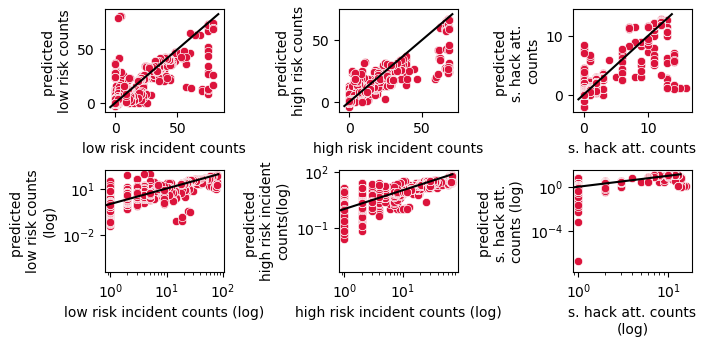

In [2384]:
# Plot real incident counts against predicted counts

# graph_df = y_test.reset_index(drop=True).join(pd.DataFrame(y_pred, columns=['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack'])).join(features5)

graph_df = nonsparse.rename(columns={'pred lr': 'pred_low_risk', 'pred hr':'pred_high_risk', 'pred sha':'pred_successful_hack_attack'})

# graph_df['pred_low_risk'] = np.round(graph_df['pred_low_risk'])
# graph_df['pred_high_risk'] = np.round(graph_df['pred_high_risk'])
# graph_df['pred_successful_hack_attack'] = np.round(graph_df['pred_successful_hack_attack'])

all_cols = graph_df.columns.values
avg_freq_cols = [x for x in graph_df.columns.values if x.startswith('freq') or x.startswith('avg_')]
select_cols = list(set(all_cols) - set(['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack', 'low_risk', 'high_risk', 'successful_hack_attack']) - set(avg_freq_cols))

fig, ax = plt.subplots(2,3,figsize=(7,3.5))
g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[0][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][0].set_xlabel('low risk incident counts', fontsize=10)
ax[0][0].set_ylabel('predicted \nlow risk counts', fontsize=10)
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[0][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][1].set_xlabel('high risk incident counts', fontsize=10)
ax[0][1].set_ylabel('predicted \nhigh risk counts', fontsize=10)
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[0][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][2].set_xlabel('s. hack att. counts', fontsize=10)
ax[0][2].set_ylabel('predicted \ns. hack att. \ncounts', fontsize=10)
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[1][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][0].set_xlabel('low risk incident counts (log)', fontsize=10)
ax[1][0].set_ylabel('predicted \nlow risk counts\n(log)', fontsize=10)
ax[1][0].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[1][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][1].set_xlabel('high risk incident counts (log)', fontsize=10)
ax[1][1].set_ylabel('predicted \nhigh risk incident\ncounts(log)', fontsize=10)
ax[1][1].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[1][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][2].set_xlabel('s. hack att. counts\n(log)', fontsize=10)
ax[1][2].set_ylabel('predicted \ns. hack att. \ncounts (log)', fontsize=10)
ax[1][2].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i][j].tick_params(labelsize=10)

plt.tight_layout()

fig.savefig('figures/real-vs-pred-nonsparse.pdf', bbox_inches='tight')
fig.savefig('figures/real-vs-pred-nonsparse.png', bbox_inches='tight')

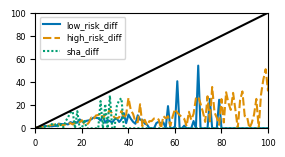

In [2027]:
diffs = nonsparse.copy()
diffs[diffs < 0] = 0
diffs['low_risk_diff'] = (diffs['pred lr'] - diffs['low_risk']).abs()
diffs['high_risk_diff'] = (diffs['pred hr'] - diffs['high_risk']).abs()
diffs['sha_diff'] = (diffs['pred sha'] - diffs['successful_hack_attack']).abs()

fig, ax = plt.subplots(figsize=(3, 1.5))

diffs_lr = diffs[['low_risk', 'low_risk_diff']]
diffs_lr = diffs_lr.groupby('low_risk').mean()
diffs_lr = diffs_lr.reindex(pd.RangeIndex(diffs_lr.index.max() + 1)).fillna(0)

diffs_hr = diffs[['high_risk', 'high_risk_diff']]
diffs_hr = diffs_hr.groupby('high_risk').mean()
diffs_hr = diffs_hr.reindex(pd.RangeIndex(diffs_hr.index.max() + 1)).fillna(0)

diffs_sha = diffs[['successful_hack_attack', 'sha_diff']]
diffs_sha = diffs_sha.groupby('successful_hack_attack').mean()
diffs_sha = diffs_sha.reindex(pd.RangeIndex(diffs_sha.index.max() + 1)).fillna(0)

diffs_all = diffs_lr.join(diffs_hr, how='outer').join(diffs_sha, how='outer').fillna(0)

g = sns.lineplot(data=diffs_all, ax=ax)
plt.xlim([0,100])
plt.ylim([0,100])

x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, color='black')
# sns.lineplot(data=diffs, x='low_risk', y='low_risk_diff', ax=ax)

In [2258]:
diffs = nonsparse.copy()
diffs = diffs[diffs['successful_hack_attack'] > 25]
strange_sha_idx = diffs.index

diffs = nonsparse.copy()
diffs = diffs[(diffs['high_risk'] != 0) & (diffs['successful_hack_attack'] > 0)]
diffs.sample(60)
# sha_idx = diffs.index
# sha_idx
# sha_test = test_data.reset_index().iloc[sha_idx]
# sha_test.sample(60)

# diffs.loc[35286]

pred lr    pred hr   pred sha  low_risk  high_risk  \
33718   1.623859  10.240688   1.049590       1.0        6.0   
30631   1.006059  23.176245   3.011187       1.0       24.0   
35001  66.719131  66.167061   0.867439      75.0       68.0   
43614  11.519307   1.510711   1.070148      11.0        1.0   
44566   8.747133   1.048951   0.762564       7.0        1.0   
32268  -0.402130  22.065481  -0.027035      19.0       59.0   
32139   1.527662  22.066679   0.081284      15.0       40.0   
14541   6.161176   1.656929  12.618171       6.0        2.0   
43101   2.898840   6.983968   0.452396       2.0        8.0   
14093   7.233922   0.359548  10.548571       7.0        2.0   
17513  12.126506   1.366879   5.718240      10.0        1.0   
30246   1.407465   2.271155   1.051816       2.0        2.0   
31356   1.647964   2.663040   0.777910       2.0        2.0   
44248  11.820118   1.374977   0.944550      10.0        1.0   
32811  23.291279  53.651466   0.953463      44.0       62.0   
33636  47.516632  66.303047   1.006784      52.0       67.0   
29088   1.017830   7.474431   3.109648       1.0       20.0   
18205   9.985172   1.059713   1.657605      11.0        1.0   
42435   7.400935   5.556148   0.121779       2.0        7.0   
29469   2.169535   2.123585   0.942901       2.0        2.0   
32003   1.023648  26.883911   0.986261       1.0       29.0   
17261  13.392016   2.742476   3.062315      11.0        1.0   
39680  17.602964   2.079499   1.917141      31.0        2.0   
35608  41.503155  63.481407   0.955280      75.0       69.0   
29916   1.579912  22.295769   2.332790       1.0       25.0   
44667  11.947359   1.425820   0.695194       7.0        1.0   
35962  70.823578  26.805370   0.772823      79.0       68.0   
31629   1.118377  23.587526   1.343168       1.0       29.0   
38212   8.890698   2.179968   3.137442      15.0        2.0   
18307  10.348267   0.611501   1.009786      11.0        1.0   
32894   0.964353  25.087620   0.986445       1.0       17.0   
16048  11.852887   1.812948  11.669273      12.0        2.0   
26265   3.178352   0.345369   1.648154       1.0        1.0   
44645  10.269762   1.048951   0.756614       7.0        1.0   
32144   0.922563  25.904240   1.008693       1.0       29.0   
44386  14.141883   0.688666   0.878064       9.0        1.0   
28397   1.090156   0.996809   2.876876       1.0        8.0   
44776  13.790746   1.480691   0.328278       7.0        1.0   
30090   1.053594  22.591124   3.019087       1.0       24.0   
31938   1.816011   2.035618   1.091254       2.0        2.0   
43445  13.330622   1.508934   0.606253      11.0        1.0   
39065   5.201299  13.027823   2.620616      20.0        2.0   
38640  17.664232  11.459717   1.801762      19.0        2.0   
39342  21.572168   1.959775   1.991748      30.0        2.0   
16781  11.607398   2.882476   7.263005      13.0        2.0   
27700   1.666471   2.337030   0.477503       1.0        1.0   
30608   1.772819   2.235307   1.021200       2.0        2.0   
17200  10.378504   1.853561   3.362622      11.0        1.0   
17354  13.568457   2.742476   3.161126      11.0        1.0   
30697   1.006059  23.438620   2.899651       1.0       24.0   
15898  12.022350   1.975386   9.778607      13.0        2.0   
29596   1.240478  11.394003   3.048492       2.0       24.0   
26666   8.262705   1.645846   0.403775       1.0        1.0   
26405   7.471002   0.785768   0.716637       1.0        1.0   
36745   1.599267   1.780169   2.041091       2.0        2.0   
16531  12.771426   2.061493   7.005410      13.0        2.0   
35437  74.375786  67.134781   0.965729      75.0       68.0   
13852   9.325488   0.975358  12.977914       9.0        1.0   
36583   1.602193   1.148165   2.043828       2.0        2.0   
31656   1.850792   2.023910   1.122803       2.0        2.0   

       successful_hack_attack  
33718                     1.0  
30631                     3.0  
35001                     1.0  
43614                     1.0  
44566

In [2098]:
diffs = results.copy()
diffs['low_risk_diff'] = (diffs['pred lr'] - diffs['low_risk']).abs()
diffs['high_risk_diff'] = (diffs['pred hr'] - diffs['high_risk'])
diffs['sha_diff'] = (diffs['pred sha'] - diffs['successful_hack_attack'])
diffs[diffs['low_risk'] == 0].sort_values('pred lr')

pred lr   pred hr  pred sha  low_risk  high_risk  \
38889 -18.604561  1.141227  0.008212       0.0        0.0   
38956 -18.604561  1.141227  0.008212       0.0        0.0   
40463  -9.469485  1.916368  0.074717       0.0        7.0   
35668  -4.215911  1.690338  2.103320       0.0        9.0   
35696  -4.215911  1.690338  2.103320       0.0        9.0   
...          ...       ...       ...       ...        ...   
36704  52.910648  9.901109  1.059542       0.0        0.0   
36572  52.910648  9.901109  1.059542       0.0        0.0   
36532  52.910648  9.901109  1.059542       0.0        0.0   
36807  52.910648  9.901109  1.059542       0.0        0.0   
36464  52.910648  9.901109  1.059542       0.0        0.0   

       successful_hack_attack  low_risk_diff  high_risk_diff  sha_diff  
38889                     0.0      18.604561        1.141227  0.008212  
38956                     0.0      18.604561        1.141227  0.008212  
40463                     0.0       9.469485       -5.083632  0.074717  
35668                     0.0       4.215911       -7.309662  2.103320  
35696                     0.0       4.215911       -7.309662  2.103320  
...                       ...            ...             ...       ...  
36704                     0.0      52.910648        9.901109  1.059542  
36572                     0.0      52.910648        9.901109  1.059542  
36532                     0.0      52.910648        9.901109  1.059542  
36807                     0.0      52.910648        9.901109  1.059542  
36464                     0.0      52.910648        9.901109  1.059542  

[21587 rows x 9 columns]

In [2253]:
diffs[(diffs['low_risk'] == 0) & (diffs['pred lr'] < 1)].sort_values('pred lr')
max_i = 0
max_nop = 0
for i in inaccurate_hr_results.index:
    nop = test_data.iloc[i]['number_open_ports']
    if nop > max_nop:
        max_nop = nop
        max_i = i
        
print(f'{max_i} -> {max_nop}')

print(str(test_data.iloc[35286]))
for col in test_data.columns:
    print(col + ' ' + str(test_data.iloc[35286][col]))
# test_data.iloc[36464].sort_values()

3765 -> 26229.0
dns_recursive_mean               0.000000
dns_recursive_max                0.000000
untrusted_tls_mean               0.043583
untrusted_tls_max                0.166667
dns_recursive_mean_last14        0.000000
                                  ...    
shadowserver_ssl_scan_total      0.000000
shadowserver_wiki_file_total     0.000000
low_risk                        75.000000
successful_hack_attack           1.000000
high_risk                       68.000000
Name: 2020-09-05 00:00:00, Length: 339, dtype: float64
dns_recursive_mean 0.0
dns_recursive_max 0.0
untrusted_tls_mean 0.043582759504416
untrusted_tls_max 0.1666666666666666
dns_recursive_mean_last14 0.0
dns_recursive_max_last14 0.0
untrusted_tls_mean_last14 0.0331527077654252
untrusted_tls_max_last14 0.0476190476190476
spam_1 0.0
spam_2 0.0
spam_3 0.0
spam_4 0.0
spam_5 0.0
spam_6 0.0
spam_7 0.0
spam_8 0.0
spam_9 0.0
spam_10 0.0
spam_11 0.0
spam_12 0.0
spam_13 0.0
spam_14 0.0
spam_15 0.0
spam_16 0.0
spam_17 0.0
spam_

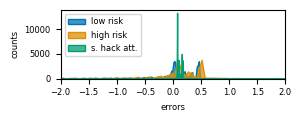

In [1813]:
errors_lr = (diffs['low_risk_diff']-diffs['low_risk_diff'].mean())/diffs['low_risk_diff'].std()
errors_hr = (diffs['high_risk_diff']-diffs['high_risk_diff'].mean())/diffs['high_risk_diff'].std()
errors_sha = (diffs['sha_diff']-diffs['sha_diff'].mean())/diffs['sha_diff'].std()

# errors_lr = (diffs['low_risk_diff']-diffs['low_risk_diff'].min())/(diffs['low_risk_diff'].max()-diffs['low_risk_diff'].min())
# errors_hr = (diffs['high_risk_diff']-diffs['high_risk_diff'].min())/(diffs['high_risk_diff'].max()-diffs['high_risk_diff'].min())
# errors_sha = (diffs['sha_diff']-diffs['sha_diff'].min())/(diffs['sha_diff'].max()-diffs['sha_diff'].min())



sns.set_palette("colorblind")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(3,1.2))

# Plot the CDF using seaborn's lineplot
sns.histplot(errors_lr, ax=ax, label='low risk', element='poly')
sns.histplot(errors_hr, ax=ax, label='high risk', element='poly')
sns.histplot(errors_sha, ax=ax, label='s. hack att.', element='poly')


# Set the labels and title
ax.set_xlabel('errors')
ax.set_ylabel('counts')
ax.legend(loc='upper left')

ax.set_xlim([-2,2])

# Show the plot
plt.tight_layout()
plt.show()

fig.savefig('figures/normalized-error-dist.pdf', bbox_inches='tight')

In [1484]:
all_data = pd.concat([train_data, test_data]).reset_index(drop=True).drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])

In [1080]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(all_data)
# explainer_shap_values = explainer(all_data)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [1863]:
x_te_original

dns_recursive_mean  dns_recursive_max  untrusted_tls_mean  \
date_start                                                              
2019-02-21                 0.0                0.0            0.000000   
2019-02-21                 0.0                0.0            0.000000   
2019-02-21                 0.0                0.0            0.645833   
2019-02-21                 0.0                0.0            0.312881   
2019-02-21                 0.0                0.0            0.000000   
...                        ...                ...                 ...   
2021-01-23                 0.0                0.0            0.000000   
2021-01-23                 0.0                0.0            0.116667   
2021-01-23                 0.0                0.0            0.000000   
2021-01-23                 0.0                0.0            0.000000   
2021-01-23                 0.0                0.0            0.000000   

            untrusted_tls_max  dns_recursive_mean_last14  \
date_start                                                 
2019-02-21                0.0                        0.0   
2019-02-21                0.0                        0.0   
2019-02-21                1.0                        0.0   
2019-02-21                1.0                        0.0   
2019-02-21                0.0                        0.0   
...                       ...                        ...   
2021-01-23                0.0                        0.0   
2021-01-23                1.0                        0.0   
2021-01-23                0.0                        0.0   
2021-01-23                0.0                        0.0   
2021-01-23                0.0                        0.0   

            dns_recursive_max_last14  untrusted_tls_mean_last14  \
date_start                                                        
2019-02-21                       0.0                   0.000000   
2019-02-21                       0.0                   0.000000   
2019-02-21                       0.0                   0.690476   
2019-02-21                       0.0                   0.391667   
2019-02-21                       0.0                   0.000000   
...                              ...                        ...   
2021-01-23                       0.0                   0.000000   
2021-01-23                       0.0                   0.214286   
2021-01-23                       0.0                   0.000000   
2021-01-23                       0.0                   0.000000   
2021-01-23                       0.0                   0.000000   

            untrusted_tls_max_last14  spam_1  spam_2  ...  \
date_start                                            ...   
2019-02-21                       0.0     0.0     0.0  ...   
2019-02-21                       0.0     0.0     0.0  ...   
2019-02-21                       1.0     0.0     0.0  ...   
2019-02-21                       1.0     0.0     0.0  ...   
2019-02-21                       0.0     0.0     0.0  ...   
...                              ...     ...     ...  ...   
2021-01-23                       0.0     0.0     0.0  ...   
2021-01-23                       1.0     0.0     0.0  ...   
2021-01-23                       0.0     0.0     0.0  ...   
2021-01-23                       0.0     0.0     0.0  ...   
2021-01-23                       0.0     0.0     0.0  ...   

            shadowserver_scan_tftp_total  shadowserver_scan_ubiquiti_total  \
date_start                                                                   
2019-02-21                           0.0                               0.0   
2019-02-21                           0.0                               0.0   
2019-02-21                           0.0                               0.0   
2019-02-21                           0.0                               0.0   
2019-02-21                           0.0                               0.0   
...                                  ...                             

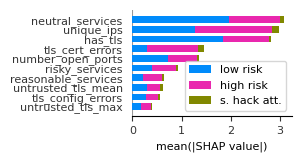

In [1895]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap = sns.color_palette('colorblind', as_cmap=True)

shap.summary_plot(original_shap_values, x_te_original, plot_type='bar', max_display=10, show=False,
                  class_names=['low risk', 'high risk', 's. hack att.'])


# Get the current figure and axes objects.
s_fig, s_ax = plt.gcf(), plt.gca()

s_fig.set_figwidth(3)
s_fig.set_figheight(1.6)

# Modifying main plot parameters
locs, labels = plt.yticks()
labels = [x.get_text()[0:17] + '...' if len(x.get_text()) >= 20 else x for x in labels]
plt.yticks(locs, labels)
s_ax.tick_params(labelsize=8)
s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=8)
s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=8)
# s_ax.set_title('asdf', fontsize=16)

# s_ax.set_xlabel(')\n('.join(s_ax.get_xlabel().split(') (')), fontsize=6)
s_ax.set_xlabel('mean(|SHAP value|)', fontsize=8)
# s_ax.set_ylabel('Values', fontsize=6)
# s_ax.legend(loc='center left', bbox_to_anchor=(0.5, 0.3), fontsize=8)
s_ax.legend(loc='lower right', fontsize=8)


plt.tight_layout()
plt.show()

s_fig.savefig('figures/feature-importance-all.pdf')


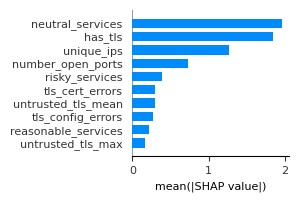

In [1877]:
shap.summary_plot(original_shap_values[0], all_data, plot_type='bar', max_display=10, show=False)


# Get the current figure and axes objects.
s_fig, s_ax = plt.gcf(), plt.gca()

s_fig.set_figwidth(3)
s_fig.set_figheight(2)

# Modifying main plot parameters
locs, labels = plt.yticks()
labels = [x.get_text()[0:17] + '...' if len(x.get_text()) >= 20 else x for x in labels]
plt.yticks(locs, labels)
s_ax.tick_params(labelsize=8)
s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=8)
s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=8)
# s_ax.set_title('asdf', fontsize=16)

# s_ax.set_xlabel(')\n('.join(s_ax.get_xlabel().split(') (')), fontsize=6)
s_ax.set_xlabel('mean(|SHAP value|)', fontsize=8)
# s_ax.set_ylabel('Values', fontsize=6)


plt.tight_layout()
plt.show()

s_fig.savefig('figures/feature-importance-lr.pdf')


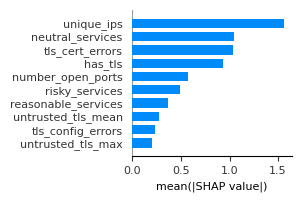

In [1865]:
shap.summary_plot(original_shap_values[1], x_te_original, plot_type='bar', max_display=10, show=False)


# Get the current figure and axes objects.
s_fig, s_ax = plt.gcf(), plt.gca()

s_fig.set_figwidth(3)
s_fig.set_figheight(2)

# Modifying main plot parameters
locs, labels = plt.yticks()
labels = [x.get_text()[0:17] + '...' if len(x.get_text()) >= 20 else x for x in labels]
plt.yticks(locs, labels)
s_ax.tick_params(labelsize=8)
s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=8)
s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=8)
# s_ax.set_title('asdf', fontsize=16)

# s_ax.set_xlabel(')\n('.join(s_ax.get_xlabel().split(') (')), fontsize=6)
s_ax.set_xlabel('mean(|SHAP value|)', fontsize=8)
# s_ax.set_ylabel('Values', fontsize=6)


plt.tight_layout()
plt.show()
s_fig.savefig('figures/feature-importance-hr.pdf')



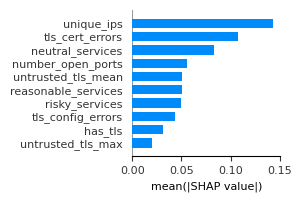

In [1866]:
shap.summary_plot(original_shap_values[2], x_te_original, plot_type='bar', max_display=10, show=False)


# Get the current figure and axes objects.
s_fig, s_ax = plt.gcf(), plt.gca()

s_fig.set_figwidth(3)
s_fig.set_figheight(2)

# Modifying main plot parameters
locs, labels = plt.yticks()
labels = [x.get_text()[0:17] + '...' if len(x.get_text()) >= 20 else x for x in labels]
plt.yticks(locs, labels)
s_ax.tick_params(labelsize=8)
s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=8)
s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=8)
# s_ax.set_title('asdf', fontsize=16)

# s_ax.set_xlabel(')\n('.join(s_ax.get_xlabel().split(') (')), fontsize=6)
s_ax.set_xlabel('mean(|SHAP value|)', fontsize=8)
# s_ax.set_ylabel('Values', fontsize=6)


plt.tight_layout()
plt.show()

s_fig.savefig('figures/feature-importance-sha.pdf')


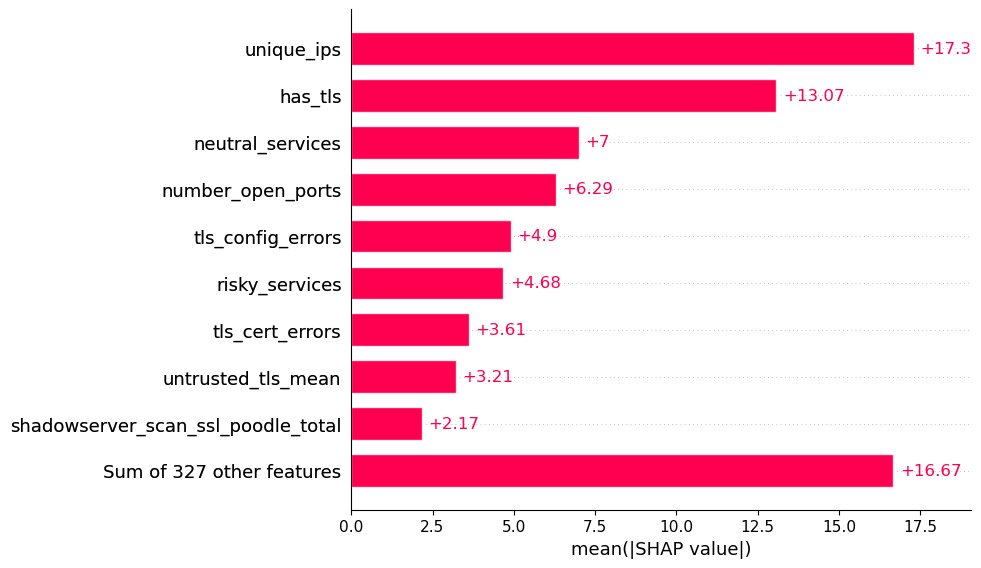

In [1289]:
shap.plots.bar(explainer_shap_values, max_display=10)

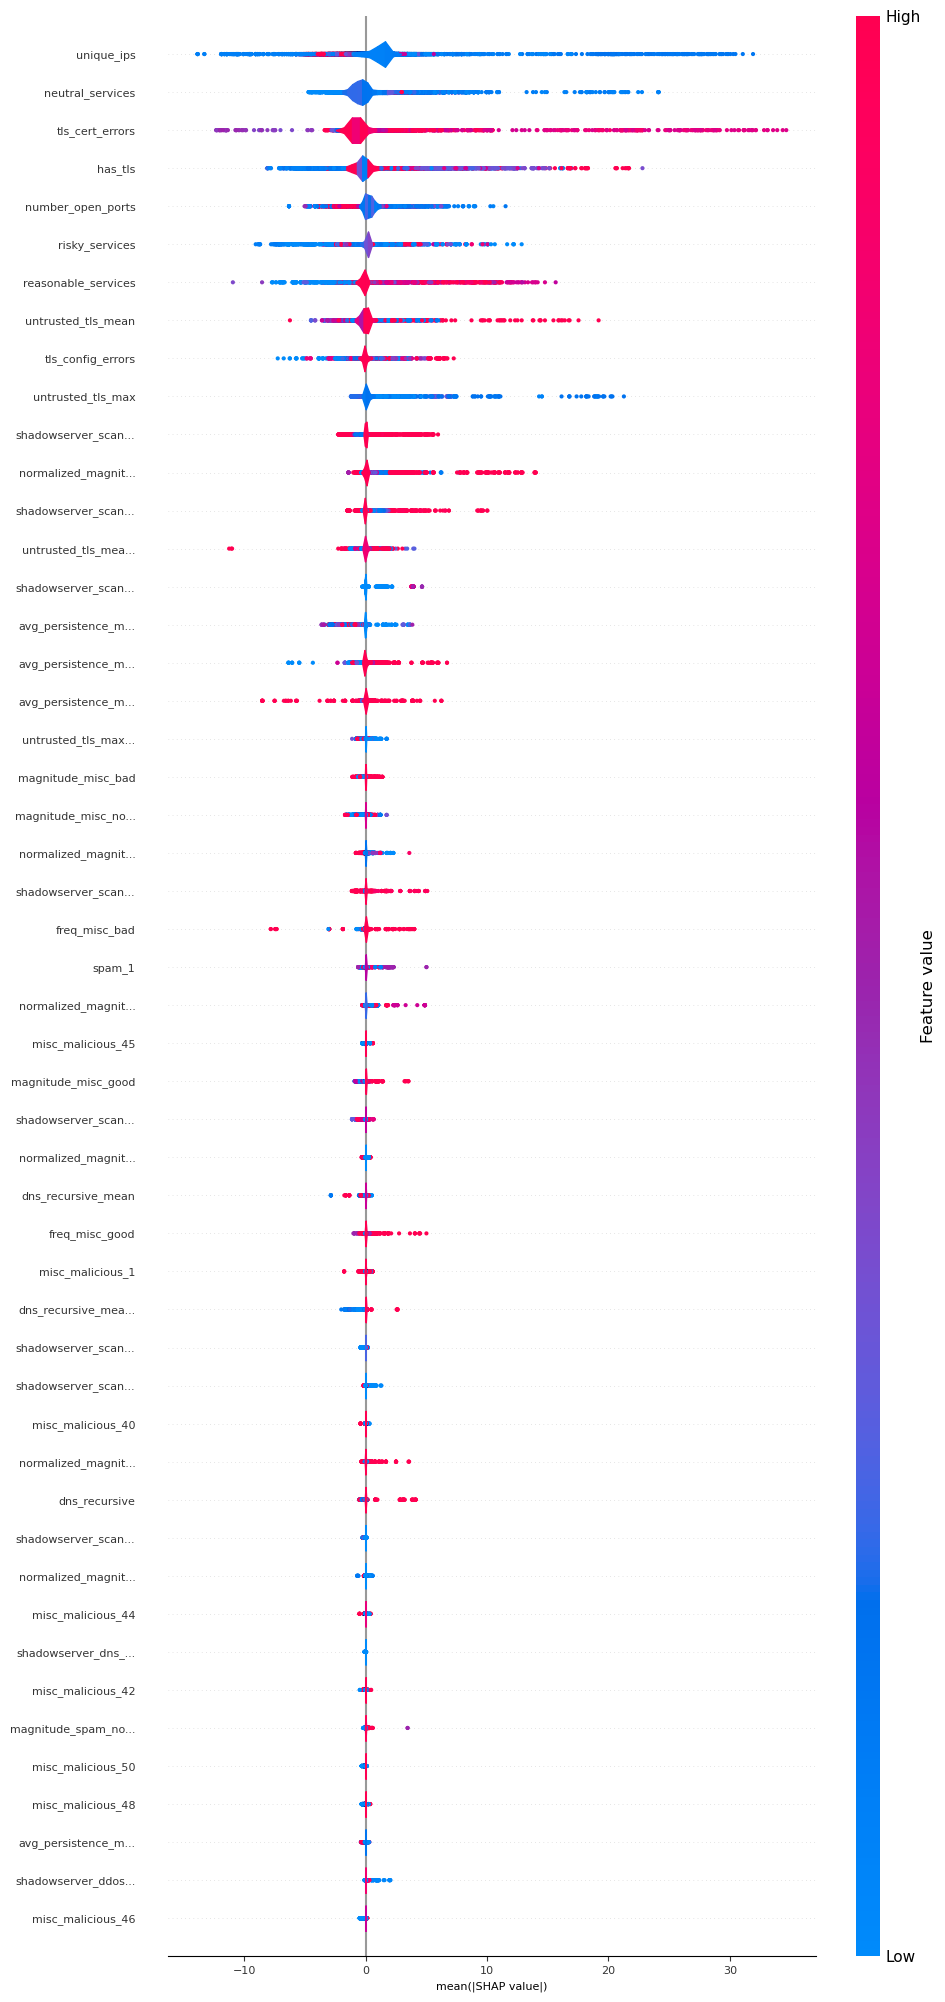

In [2066]:
# Feature importance for high_risk incidents
shap.summary_plot(original_shap_values[1], x_te_original, max_display=50, show=False, plot_type='violin')


# Get the current figure and axes objects.
s_fig, s_ax = plt.gcf(), plt.gca()

s_fig.set_figwidth(10)
s_fig.set_figheight(20)

# Modifying main plot parameters
locs, labels = plt.yticks()
labels = [x.get_text()[0:17] + '...' if len(x.get_text()) >= 20 else x for x in labels]
plt.yticks(locs, labels)
s_ax.tick_params(labelsize=8)
s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=8)
s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=8)
# s_ax.set_title('asdf', fontsize=16)

# s_ax.set_xlabel(')\n('.join(s_ax.get_xlabel().split(') (')), fontsize=6)
s_ax.set_xlabel('mean(|SHAP value|)', fontsize=8)
# s_ax.set_ylabel('Values', fontsize=6)


plt.tight_layout()
plt.show()

# s_fig.savefig('figures/feature-importance-asdfasdf.pdf')

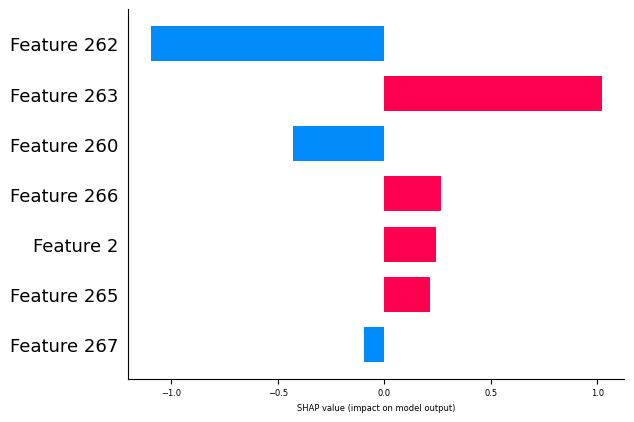

In [2068]:
shap.bar_plot(original_shap_values[1][1])

In [2350]:
from scipy.special import softmax

def normalize_array(array):
    # Ensure the input array is a numpy array
    array = np.array(array)
    
    # Check if the array is empty
    if array.size == 0:
        raise ValueError("Input array is empty.")
    
    # Check if there are negative values in the array
    if np.any(array < 0):
        raise ValueError("Input array contains negative values.")
    
    # Calculate the sum of all elements in the array
    total_sum = np.sum(array)
    
    # Check if the sum is zero, to avoid division by zero
    if total_sum == 0:
        raise ValueError("Sum of array elements is zero.")
    
    # Normalize the array to obtain probabilities
    probabilities = array / total_sum
    
    return probabilities

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.shape[1]):
        importances.append(np.mean(np.abs(shap_values[:, i])))
    # Calculates the normalized version
    importances_norm = normalize_array(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
#     # Prints the feature importances
#     for k, v in feature_importances.items():
#         print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
        
    return feature_importances

def group_feature_groups(feat_importance_dict):
    result = {
        'malicious_activity': 0,
        'persistence_60': 0,
        'persistence_14': 0,
        'mismanagement': 0,
        'live_hosts': 0,
        'services': 0,
        'shadowserver': 0,
    }
    
    mismanagement_feats = ['tls_config_errors', 'tls_cert_errors', 'dns_recursive_mean']
    live_hosts_feats = ['unique_ips', 'number_open_ports', 'has_tls']
    services_feats = ['reasonable_services', 'neutral_services', 'risky_services']
    for f, imp in feat_importance_dict.items():
        # malicious activity
        if f.startswith('spam') or f.startswith('phishing') or f.startswith('misc_malicious'):
            result['malicious_activity'] += imp
        
        # persistence last 14 days
        elif f.endswith('last14'):
            result['persistence_14'] += imp
            
        # shadowserver
        elif f.startswith('shadowserver'):
            result['shadowserver'] += imp
            
        # mismanagement
        elif f in mismanagement_feats or f.startswith('untrusted_tls') or f.startswith('dns_recursive'):
            result['mismanagement'] += imp
        
        # live hosts
        elif f in live_hosts_feats:
            result['live_hosts'] += imp
            
        # services
        elif f in services_feats:
            result['services'] += imp
            
        # persistence 60 day window (all remaining features)
        else:
            result['persistence_60'] += imp
        
        
    return result
            

importances = print_feature_importances_shap_values(original_shap_values[0], x_tr.columns.values)
importances_norm = normalize_array([x for x in importances.values()])
importances_norm = {k:v for k, v in zip(importances.keys(), importances_norm)}

for k, v in importances.items():
    print(f"{k} -> {v:.4f} (softmax = {importances_norm[k]:.4f})")
    
print('\n\n\n')
    
importances = group_feature_groups(importances)
importances_norm = normalize_array([x for x in importances.values()])
importances_norm = {k:v for k, v in zip(importances.keys(), importances_norm)}

for k, v in importances.items():
    print(f"{k} -> {v:.4f} (softmax = {importances_norm[k]:.4f})")


neutral_services -> 1.9592 (softmax = 0.2259)
has_tls -> 1.8399 (softmax = 0.2121)
unique_ips -> 1.2655 (softmax = 0.1459)
number_open_ports -> 0.7333 (softmax = 0.0845)
risky_services -> 0.3923 (softmax = 0.0452)
tls_cert_errors -> 0.3021 (softmax = 0.0348)
untrusted_tls_mean -> 0.2955 (softmax = 0.0341)
tls_config_errors -> 0.2746 (softmax = 0.0317)
reasonable_services -> 0.2245 (softmax = 0.0259)
untrusted_tls_max -> 0.1701 (softmax = 0.0196)
untrusted_tls_mean_last14 -> 0.1374 (softmax = 0.0158)
normalized_magnitude_misc_bad -> 0.1301 (softmax = 0.0150)
shadowserver_scan_http_total -> 0.1256 (softmax = 0.0145)
shadowserver_scan_ssl_poodle_total -> 0.0780 (softmax = 0.0090)
normalized_magnitude_misc_normal -> 0.0633 (softmax = 0.0073)
dns_recursive_mean -> 0.0573 (softmax = 0.0066)
shadowserver_scan_rdp_total -> 0.0420 (softmax = 0.0048)
untrusted_tls_max_last14 -> 0.0381 (softmax = 0.0044)
shadowserver_scan_ntp_total -> 0.0371 (softmax = 0.0043)
avg_persistence_misc_bad -> 0.0361 (

251


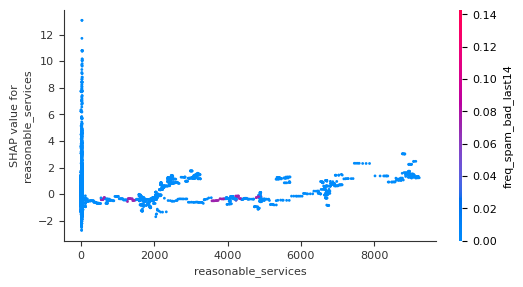

251


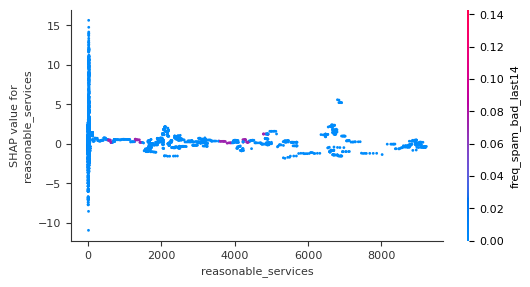

102


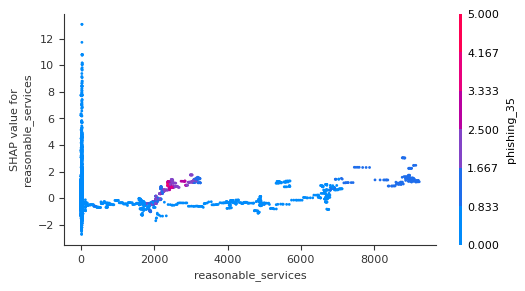

102


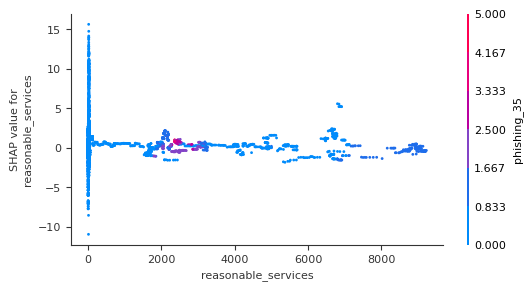

99


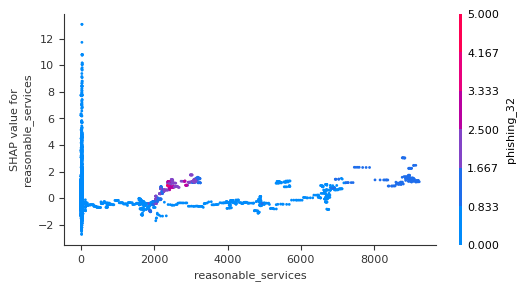

99


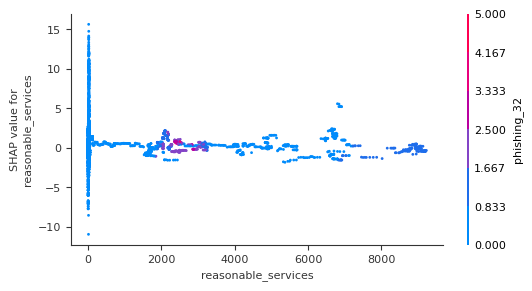

94


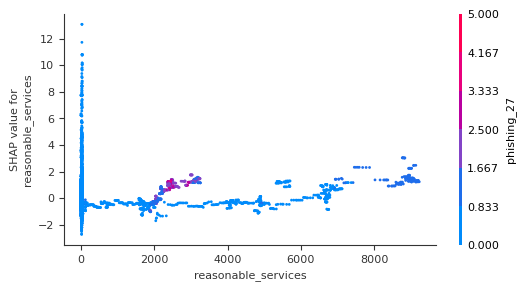

94


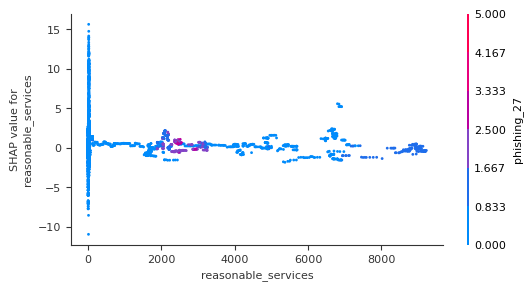

92


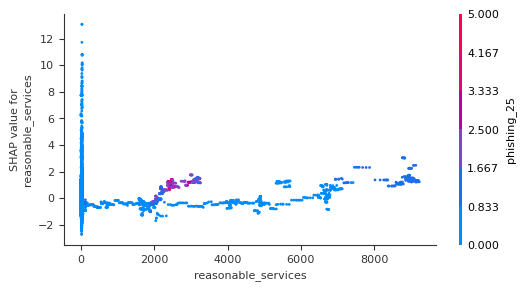

92


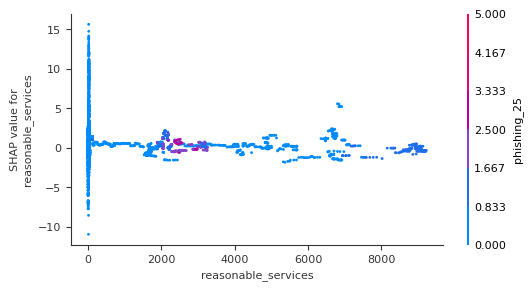

91


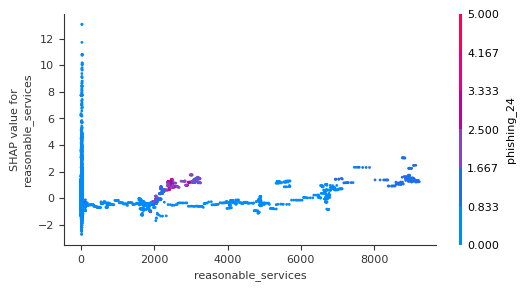

91


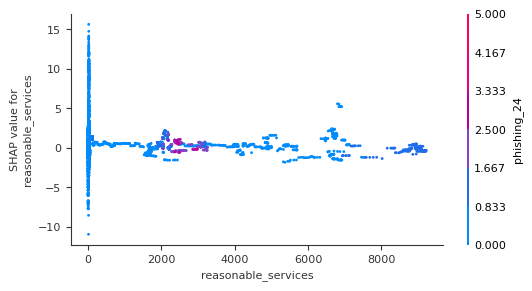

90


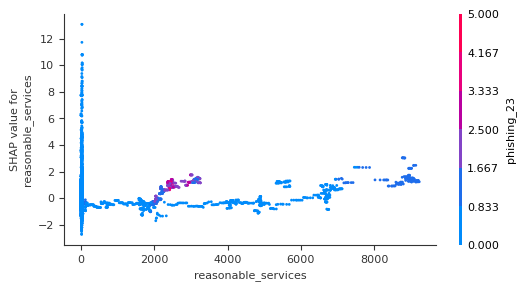

90


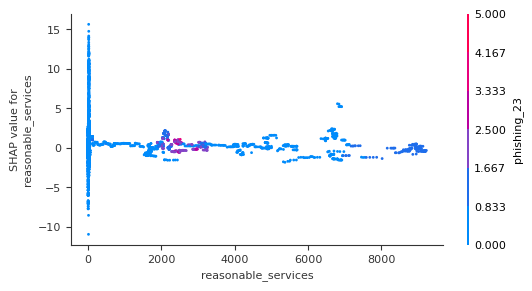

89


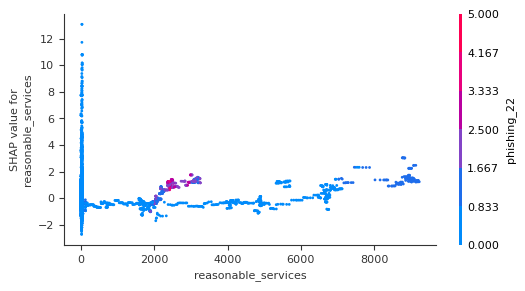

89


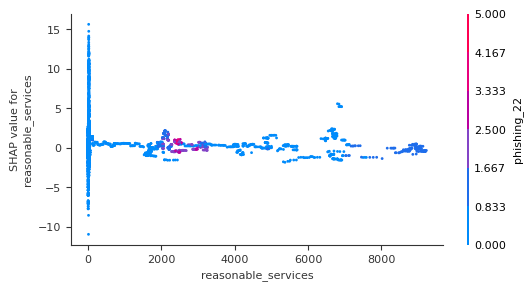

88


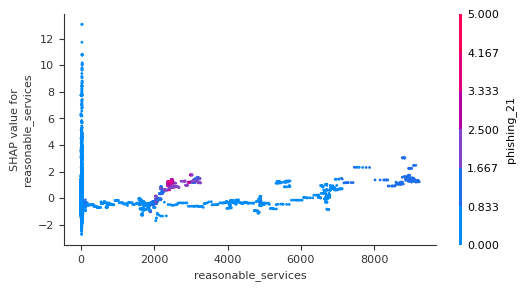

88


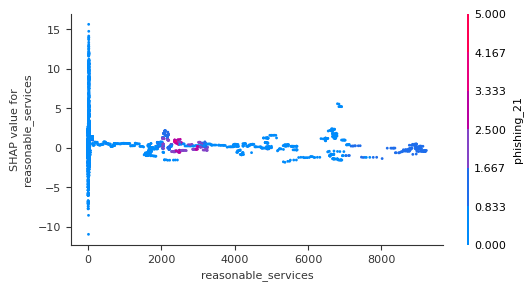

84


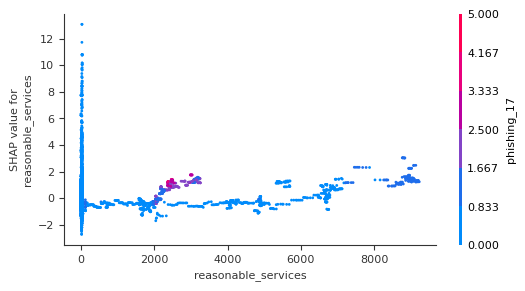

84


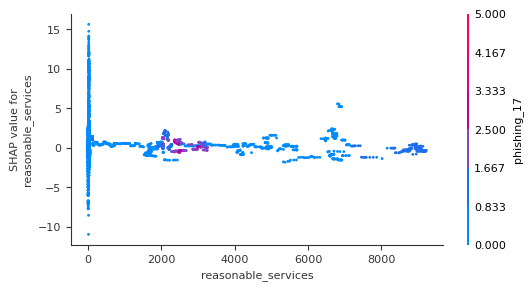

255


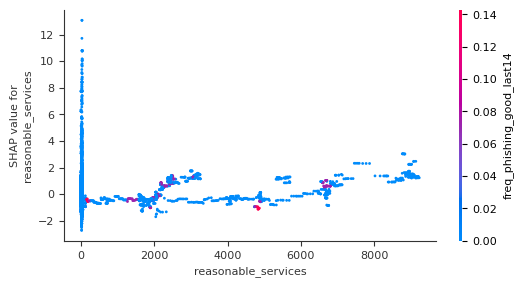

255


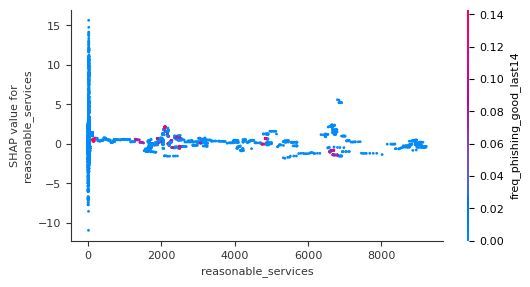

244


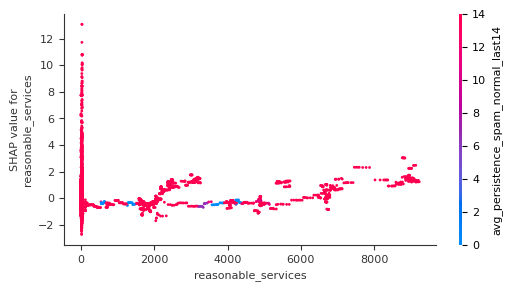

244


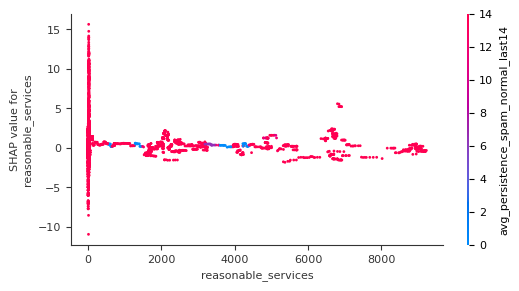

237


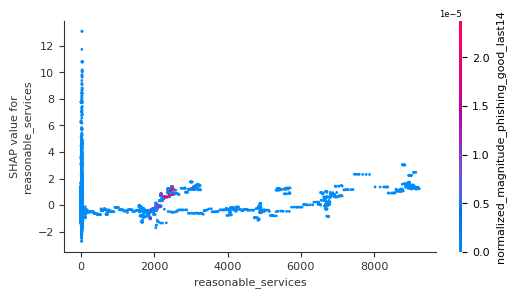

237


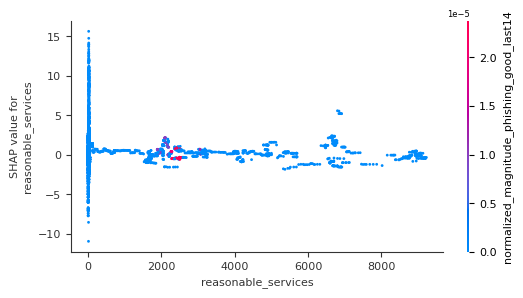

236


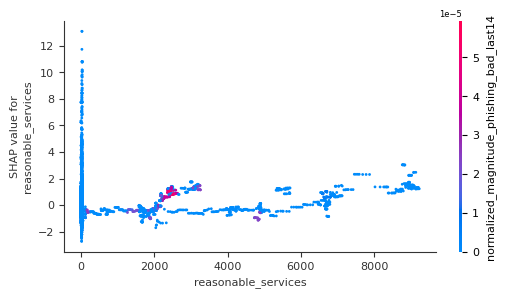

236


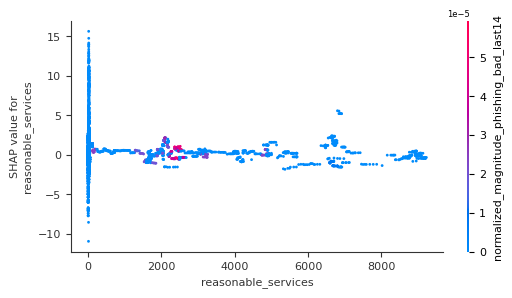

311


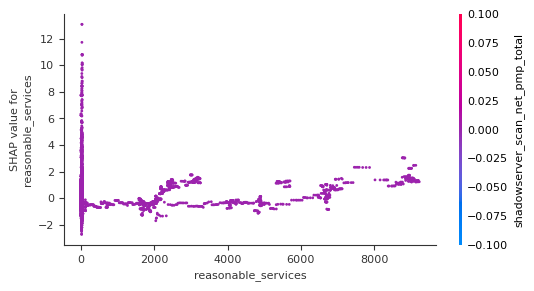

311


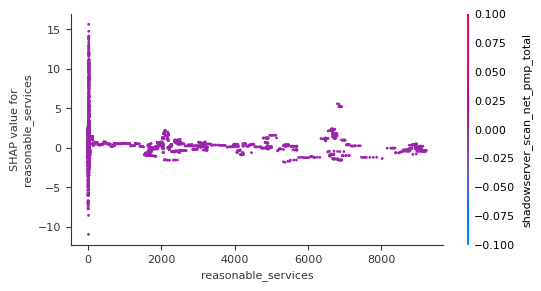

313


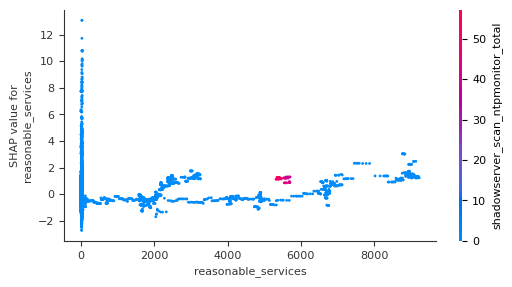

313


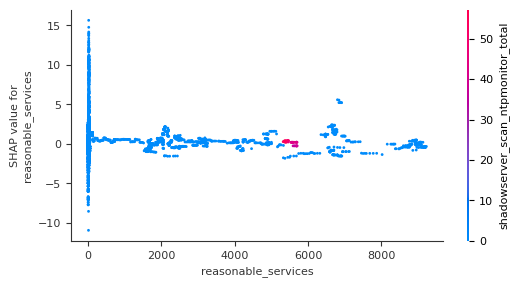

310


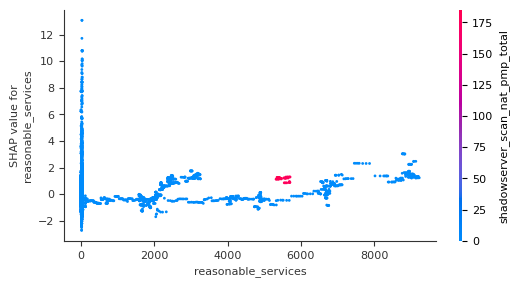

310


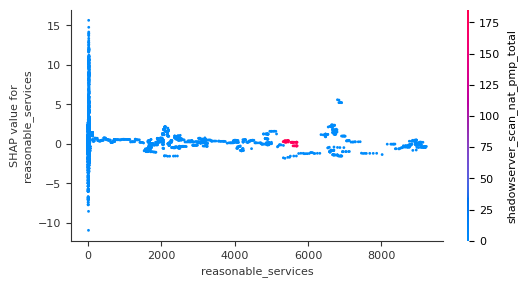

308


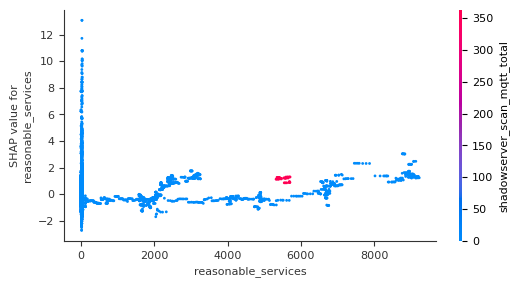

308


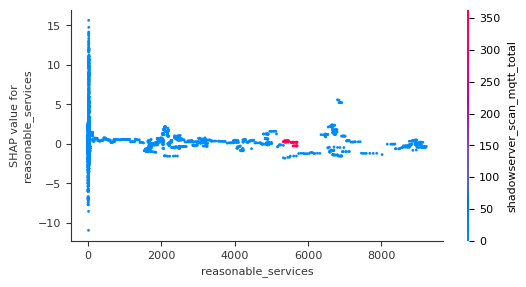

307


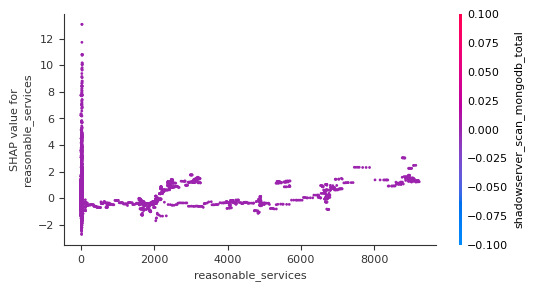

307


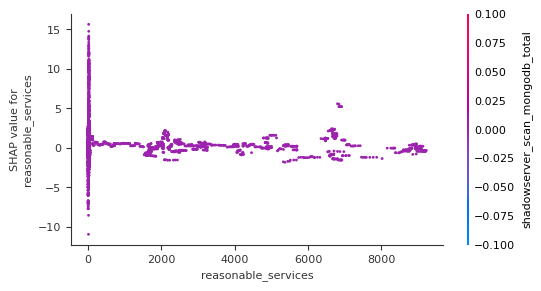

306


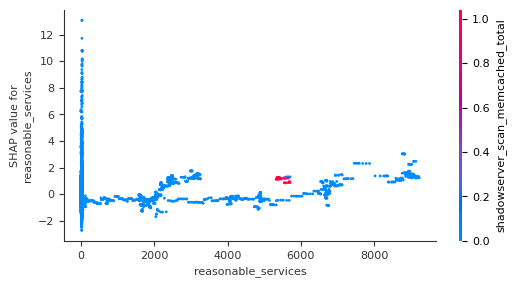

306


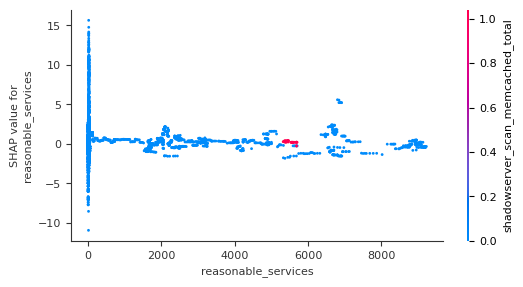

254


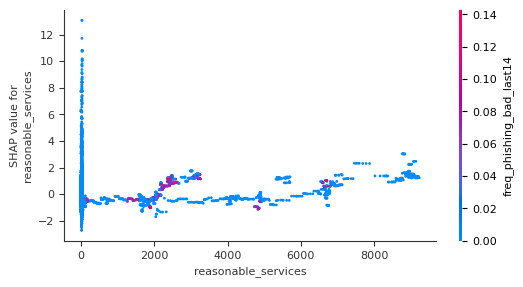

254


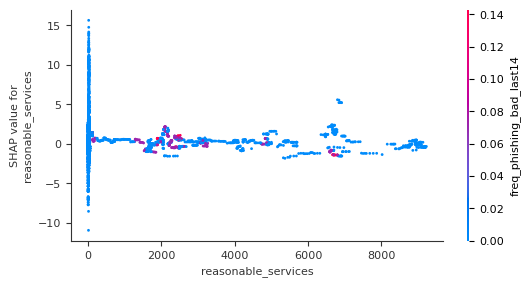

252


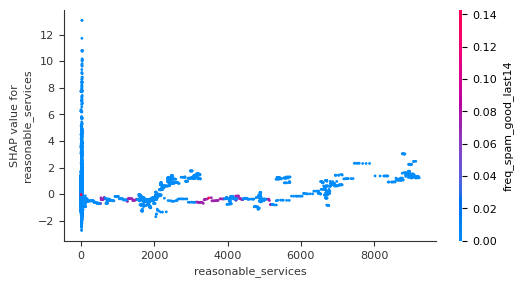

252


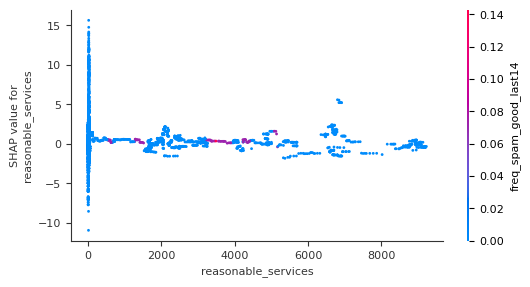

272


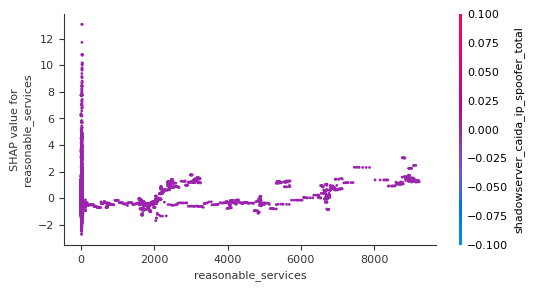

272


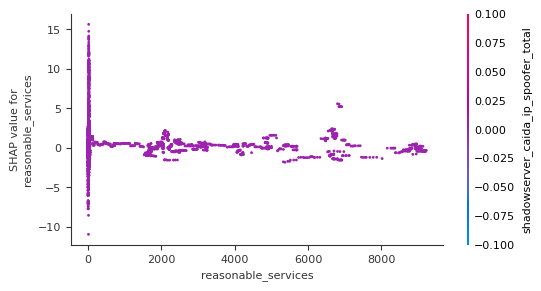

273


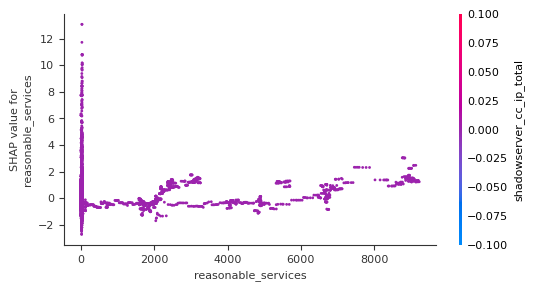

273


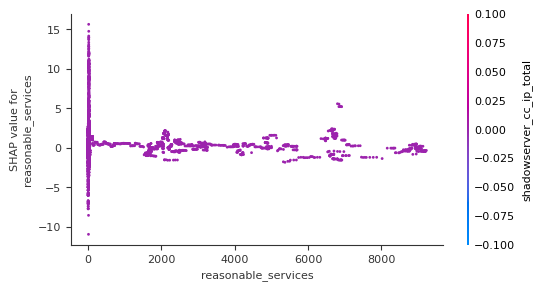

274


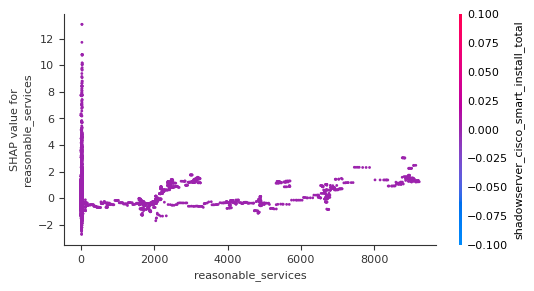

274


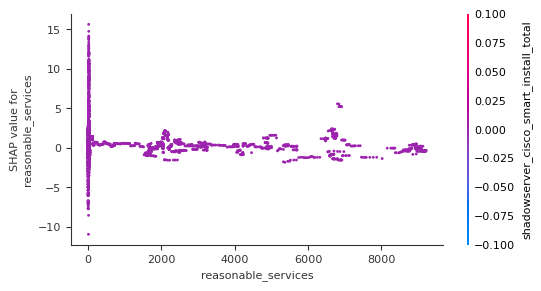

275


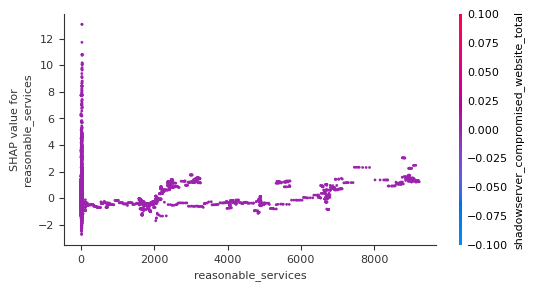

275


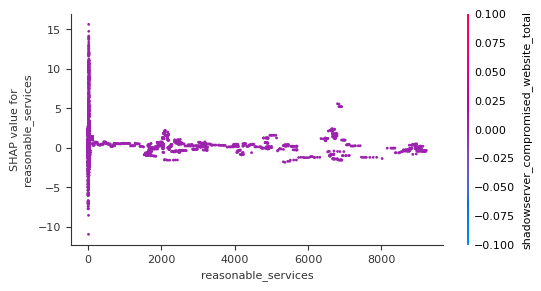

277


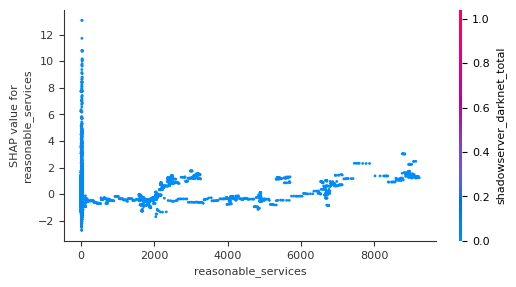

277


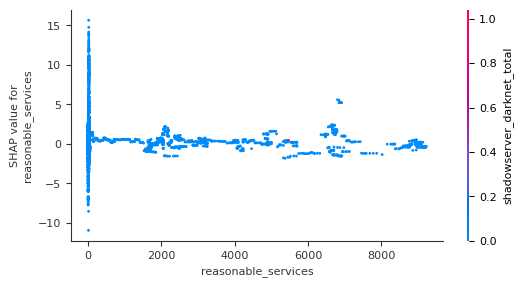

281


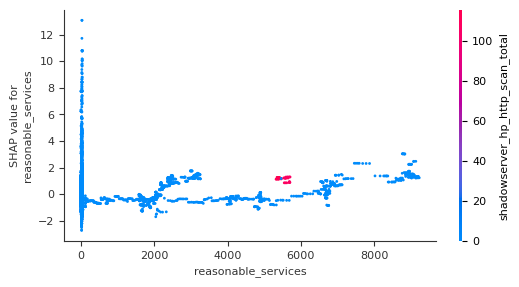

281


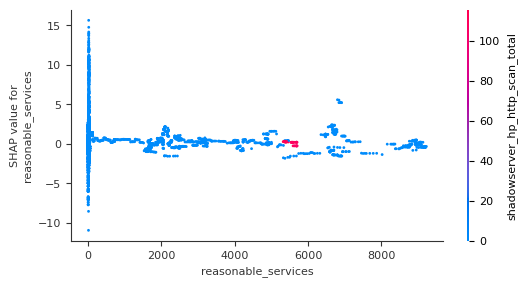

282


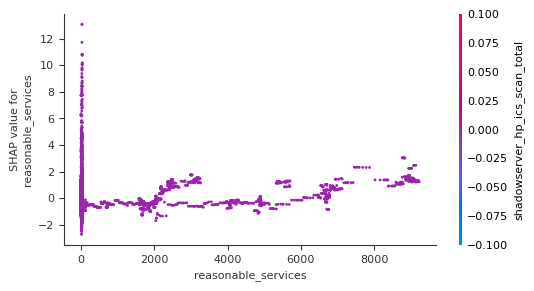

282


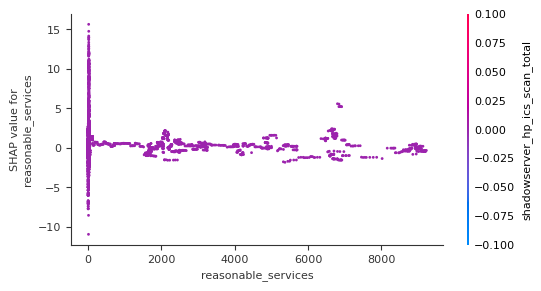

284


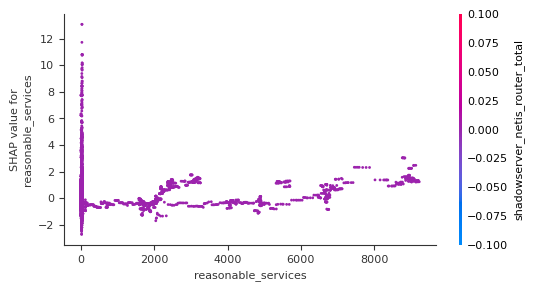

284


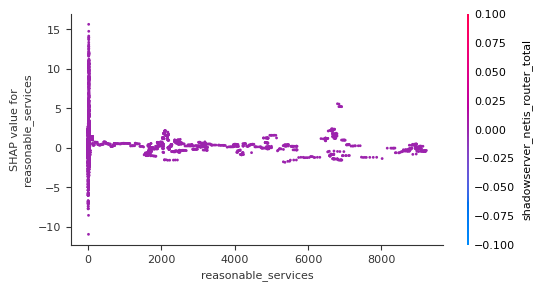

285


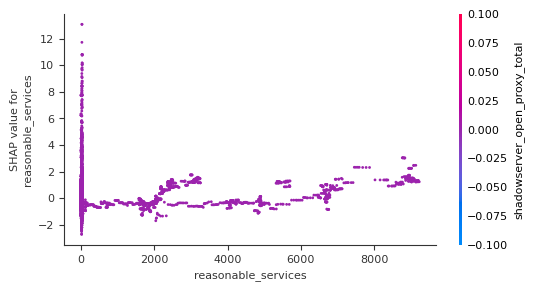

285


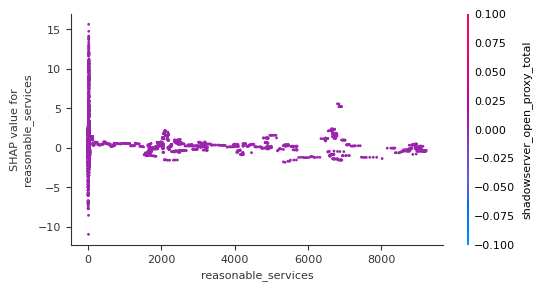

286


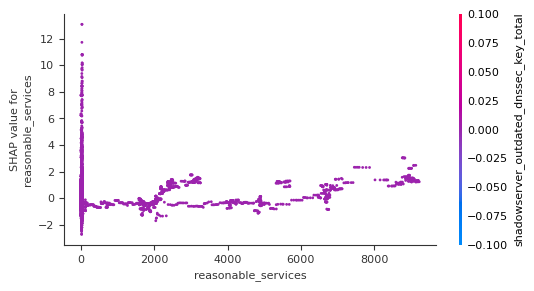

286


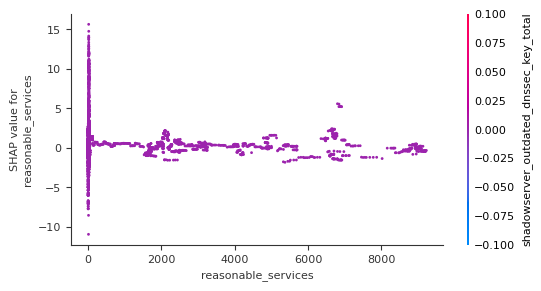

229


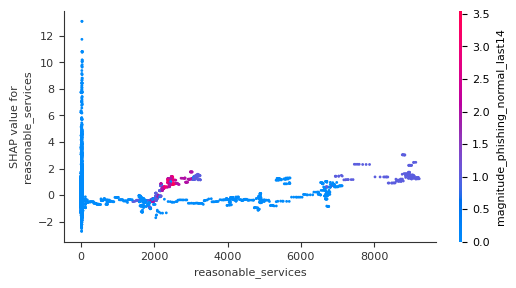

229


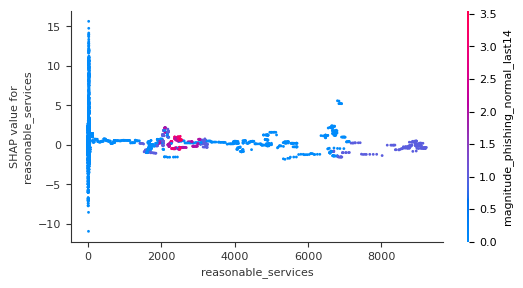

287


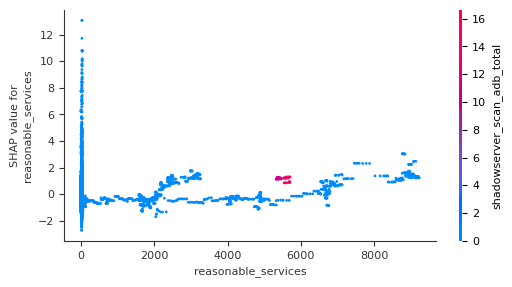

287


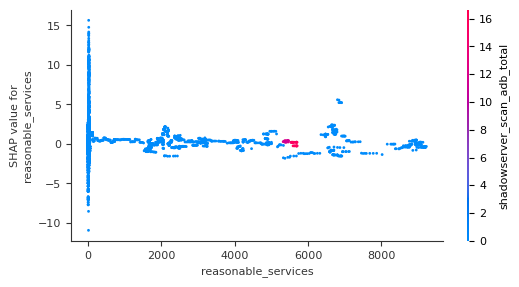

289


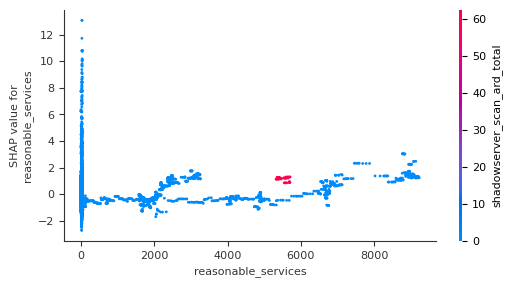

289


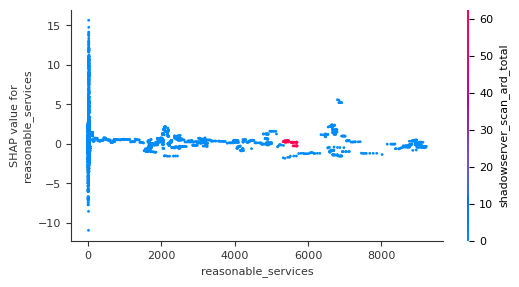

290


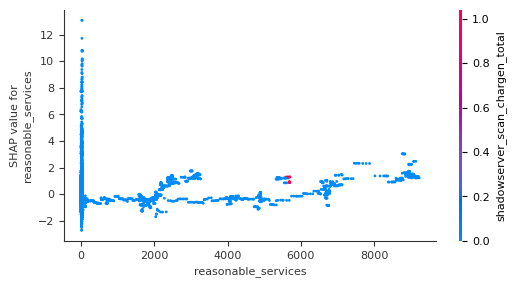

290


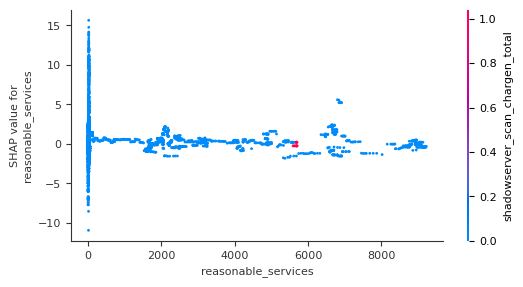

291


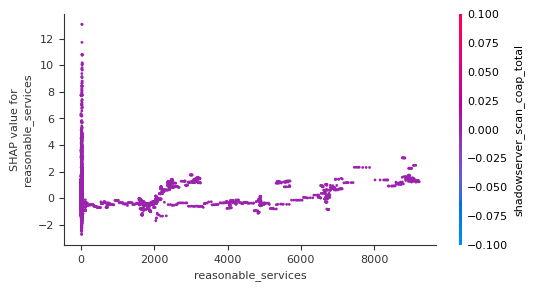

291


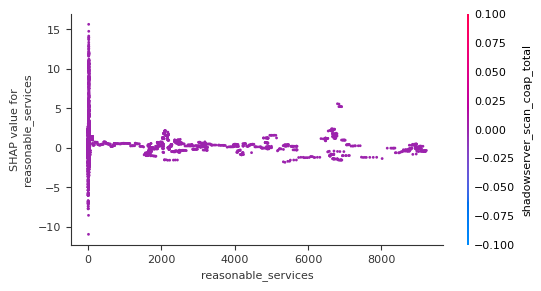

292


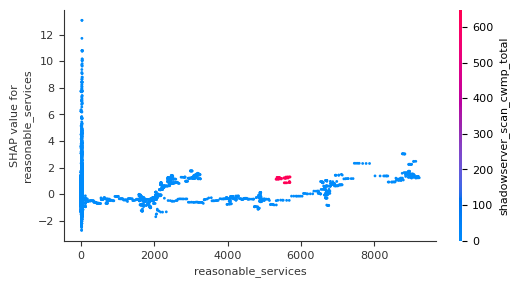

292


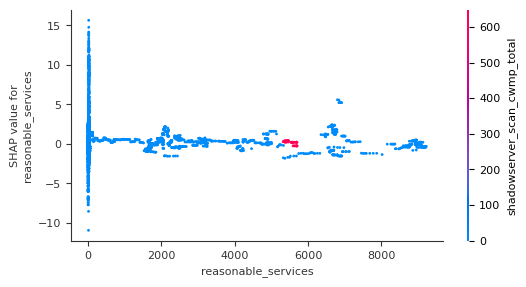

293


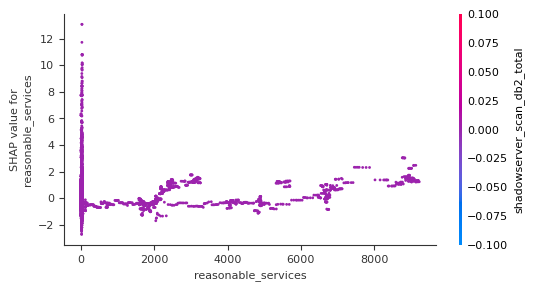

293


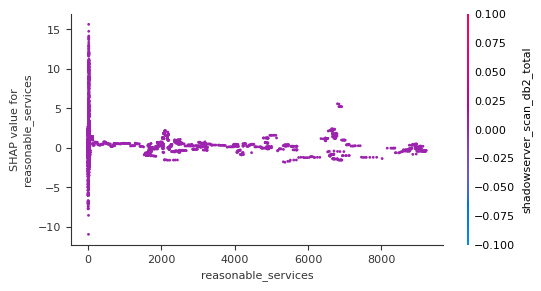

295


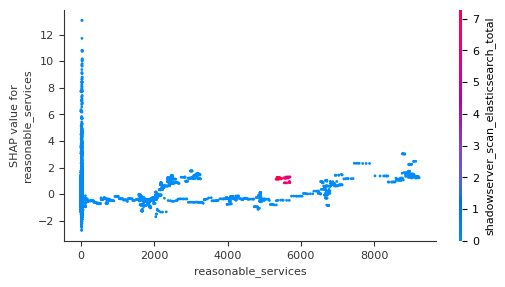

295


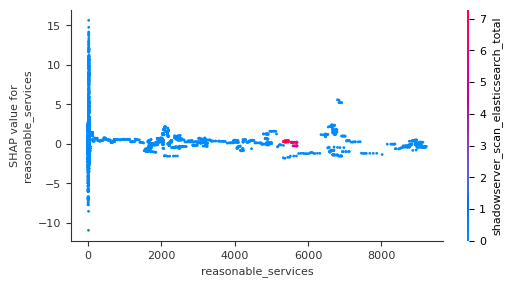

297


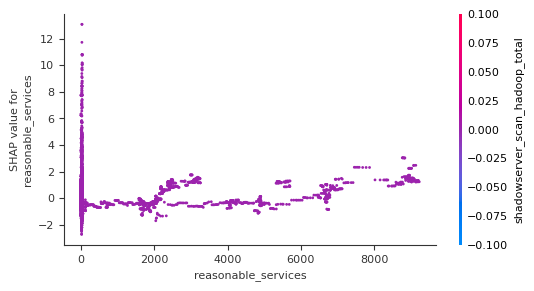

297


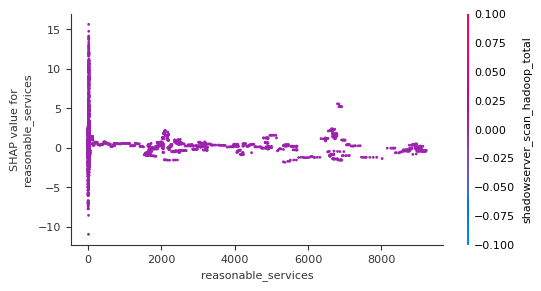

299


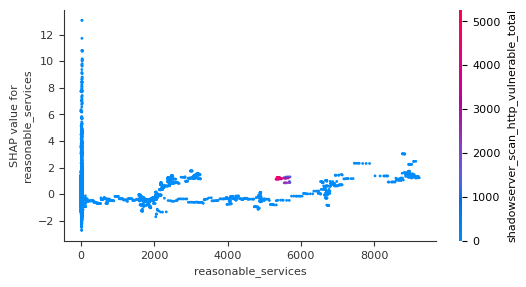

299


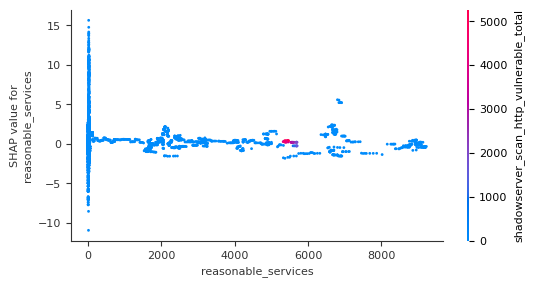

300


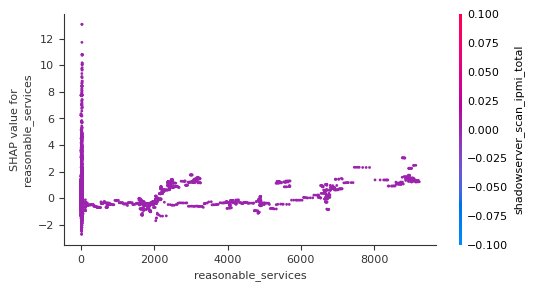

300


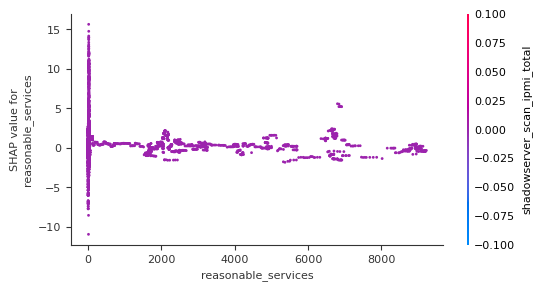

301


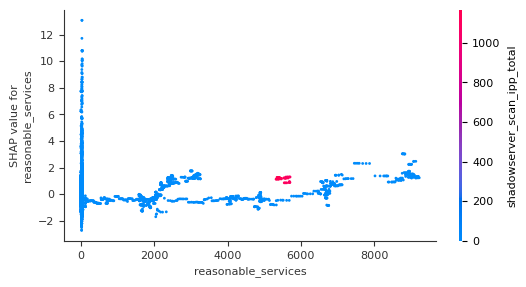

301


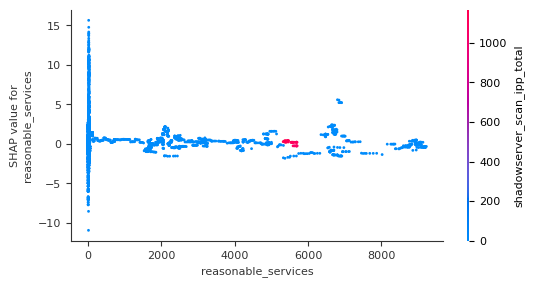

303


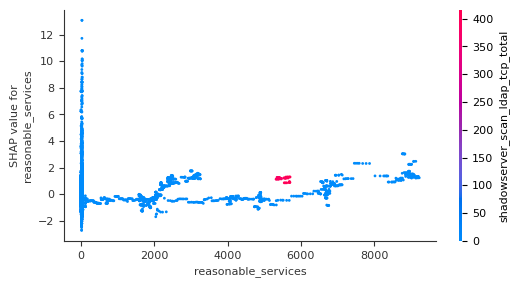

303


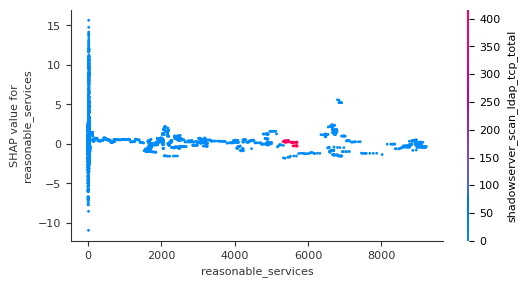

304


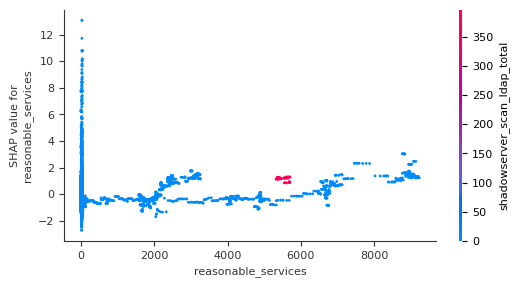

304


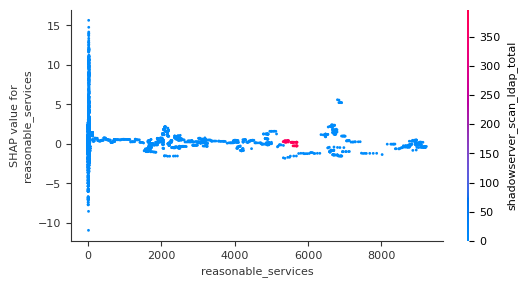

288


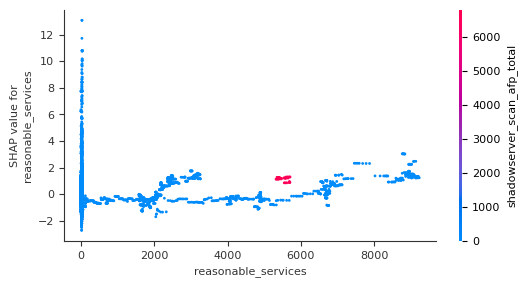

288


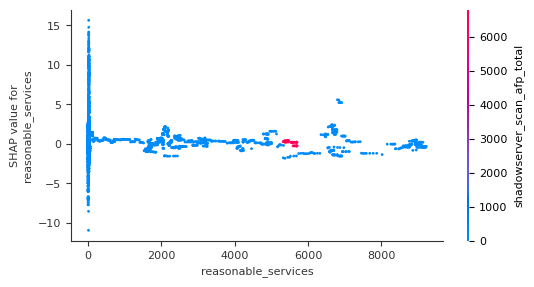

315


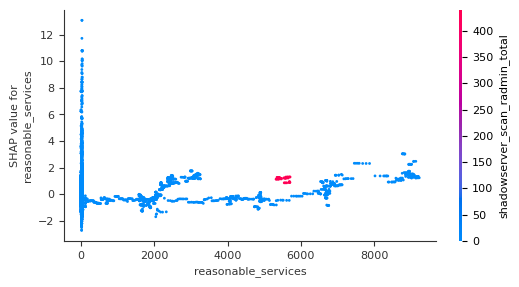

315


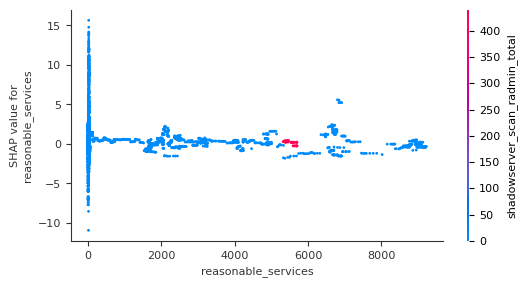

83


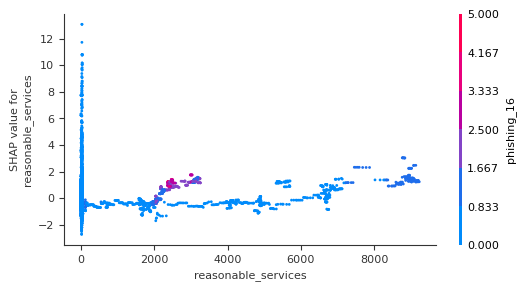

83


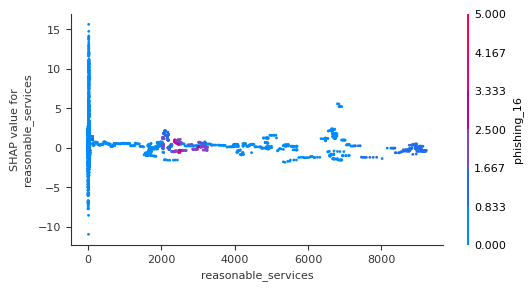

334


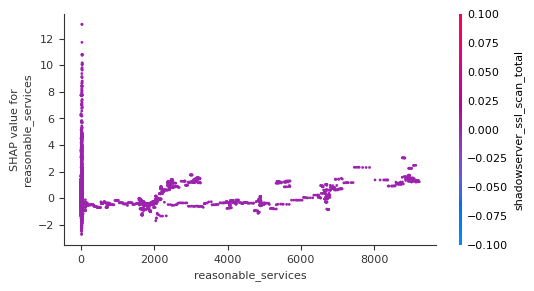

334


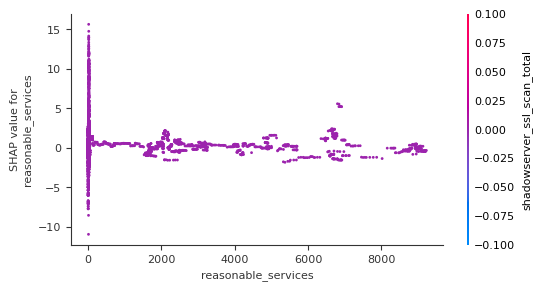

In [2030]:


top_inds = np.argsort(np.sum(np.abs(shap_values[0]), 0))
for i in range(50):
    for j in [0,1]:
        top_feature_index = top_inds[i+10]
        if top_feature_index == 261:
            continue
        print(top_feature_index)
        shap.dependence_plot('reasonable_services', original_shap_values[j], x_te_original, show=False, dot_size=4, interaction_index=top_feature_index)


        # Get the current figure and axes objects.
        s_fig, s_ax = plt.gcf(), plt.gca()

        s_fig.set_figwidth(6)
        s_fig.set_figheight(3)

        # Modifying main plot parameters
        s_ax.tick_params(labelsize=8)
        s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=8)
        s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=8)
        # s_ax.tick_params(labelsize=14)
        # s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=6)
        # s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=6)
        # s_ax.set_title('asdf', fontsize=16)

        # Get colorbar
        cb_ax = s_fig.axes[1]

        # Modifying color bar parameters
        cb_ax.tick_params(labelsize=8)
        cb_ax.set_ylabel(cb_ax.get_ylabel(), fontsize=8)

        plt.show()
        
plt.close()

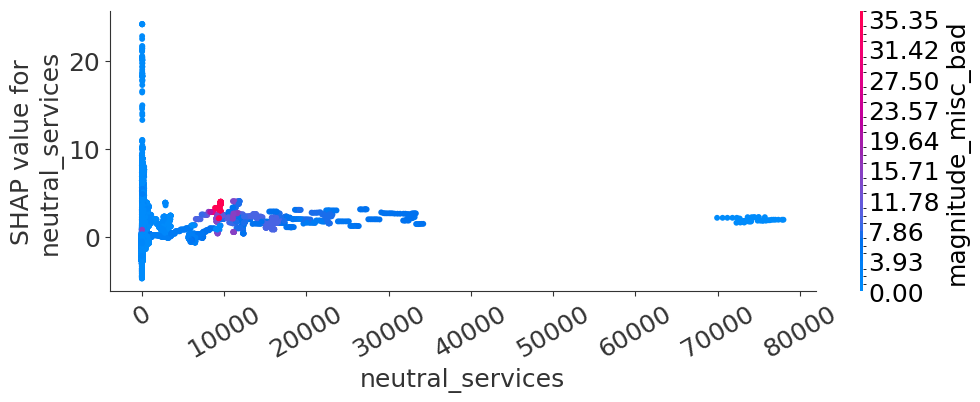

In [2071]:
# Testing successful_hack_attack prediction: index 2 in shap_values
# Effect of risky_services (index 266) features on predictions
# has_tls feature seems to have a strong interaction with risky_services
shap.dependence_plot('neutral_services', original_shap_values[1], x_te_original, show=False, 
                     dot_size=18, interaction_index='magnitude_misc_bad')


# Get the current figure and axes objects.
s_fig, s_ax = plt.gcf(), plt.gca()

s_fig.set_figwidth(10)
s_fig.set_figheight(4)

# Modifying main plot parameters
s_ax.tick_params(labelsize=18)
s_ax.tick_params(axis='x', rotation=30)
s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=18)
s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=18)
# s_ax.tick_params(labelsize=14)
# s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=6)
# s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=6)
# s_ax.set_title('asdf', fontsize=16)

# Get colorbar
cb_ax = s_fig.axes[1]

# Modifying color bar parameters
cb_ax.tick_params(labelsize=18)
cb_ax.set_ylabel(cb_ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()

s_fig.savefig('figures/dependence-plot.pdf', bbox_inches='tight')

In [1856]:
# Investigating high_risk prediction error
# Real value is 1052, predicted value is 16.83
# Why? Because entire feature vector is zero, see below
i = 42908
shap.force_plot(original_expected_values['lr'][i], original_shap_values[0][i], x_te_original.iloc[i], matplotlib=False)

original expected value = 2.1810932


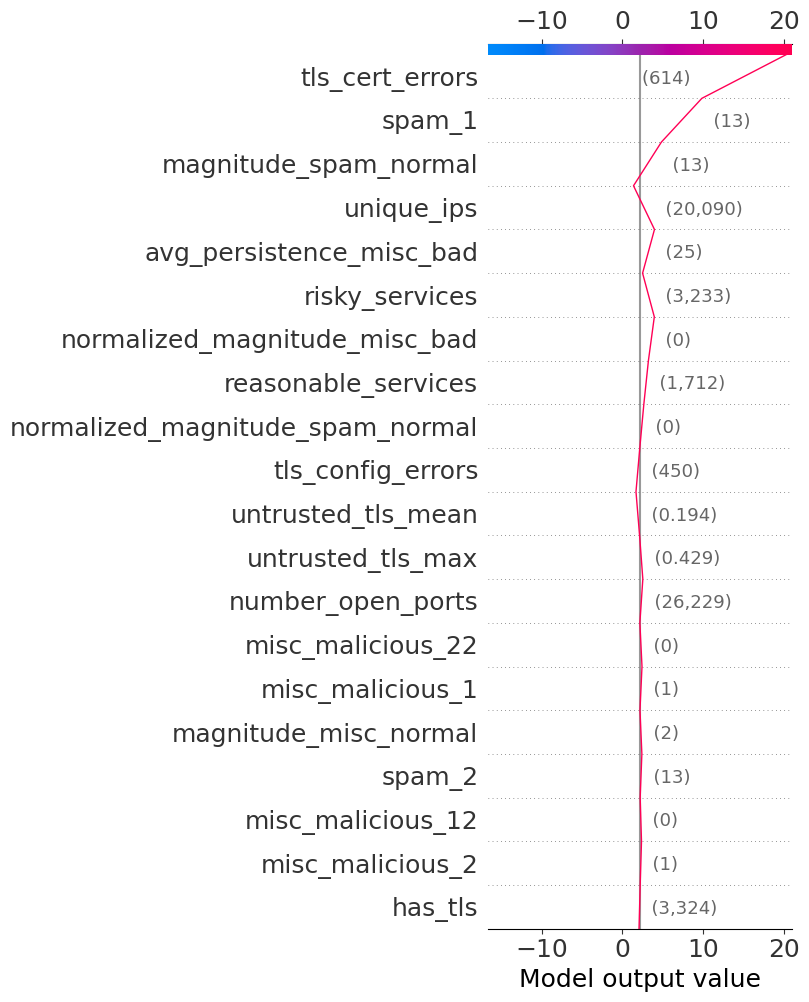

In [2259]:
# Investigating why predictions are made
accurate_lr = 13596
inaccurate_sha = 45407
accurate_sha = 35286
inaccurate_hr = 3765


i = inaccurate_hr
incident_type = 'hr'
incident_type_index = 1 # 0->lr, 1->hr, 2->sha

print('original expected value = ' + str(original_expected_values[incident_type][i]))
shap.decision_plot(original_expected_values[incident_type][i], original_shap_values[incident_type_index][i],
                   x_te_original.iloc[i],                   show=False)

# Get the current figure and axes objects.
s_fig, s_ax = plt.gcf(), plt.gca()

s_fig.set_figwidth(8)
s_fig.set_figheight(10)

# Modifying main plot parameters
s_ax.tick_params(labelsize=18)
# s_ax.tick_params(axis='x', rotation=30)
s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=18)
s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=18)
# s_ax.tick_params(labelsize=14)
# s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=6)
# s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=6)
# s_ax.set_title('asdf', fontsize=16)

# # Get colorbar
# cb_ax = s_fig.axes[1]

# # Modifying color bar parameters
# cb_ax.tick_params(labelsize=18)
# cb_ax.set_ylabel(cb_ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()

s_fig.savefig('figures/decision-plot-false-hr.pdf', bbox_inches='tight')

In [2063]:
# How sparse is this feature vector???
(x_te_original.iloc[i] == 0).sum()

277

In [ ]:
idxs = [44379, 33379]
x_te_original.iloc[idxs].transpose().to_csv('csv/accurate-sha.csv')

original expected value = 0.11050677


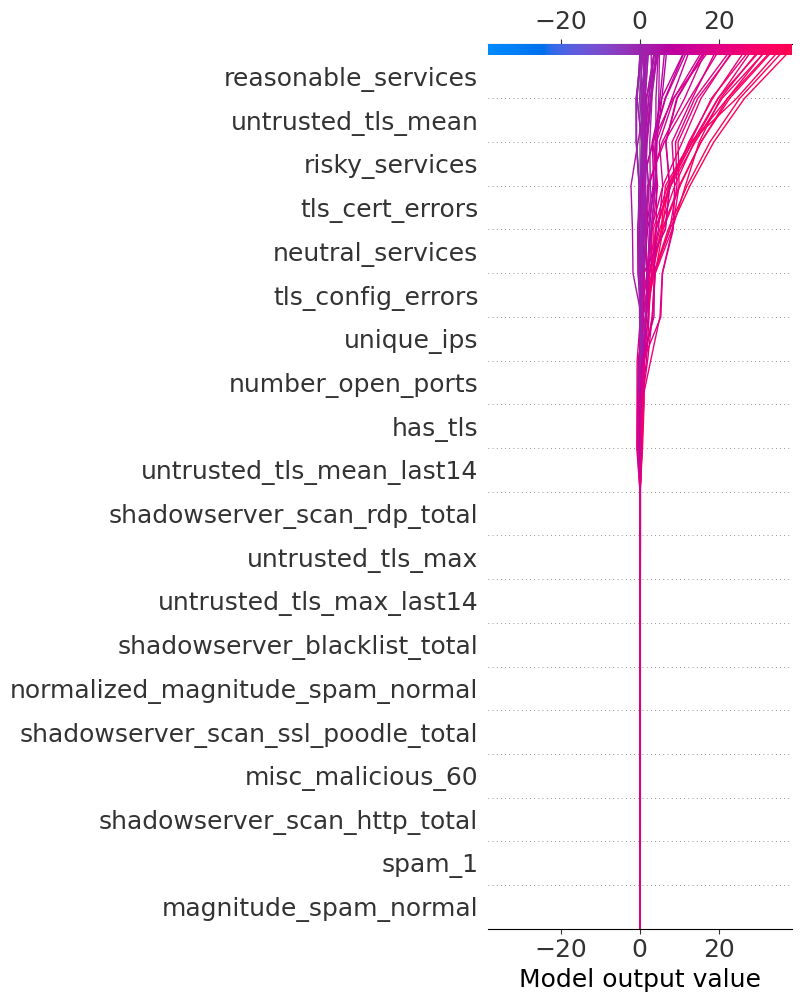

In [2144]:
# Investigating why predictions are made
i = 11610

idxs = strange_sha_idx
misclassified=[True, False]

print('original expected value = ' + str(original_expected_values['sha'][i]))
shap.decision_plot(original_expected_values['sha'][i], original_shap_values[2][idxs], x_te_original.iloc[idxs],
                   show=False, ignore_warnings=True)

# Get the current figure and axes objects.
s_fig, s_ax = plt.gcf(), plt.gca()

s_fig.set_figwidth(8)
s_fig.set_figheight(10)

# Modifying main plot parameters
s_ax.tick_params(labelsize=18)
# s_ax.tick_params(axis='x', rotation=30)
s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=18)
s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=18)
# s_ax.tick_params(labelsize=14)
# s_ax.set_xlabel(s_ax.get_xlabel(), fontsize=6)
# s_ax.set_ylabel(s_ax.get_ylabel(), fontsize=6)
# s_ax.set_title('asdf', fontsize=16)

# # Get colorbar
# cb_ax = s_fig.axes[1]

# # Modifying color bar parameters
# cb_ax.tick_params(labelsize=18)
# cb_ax.set_ylabel(cb_ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()

s_fig.savefig('figures/decision-plot-sha-cluster.pdf', bbox_inches='tight')

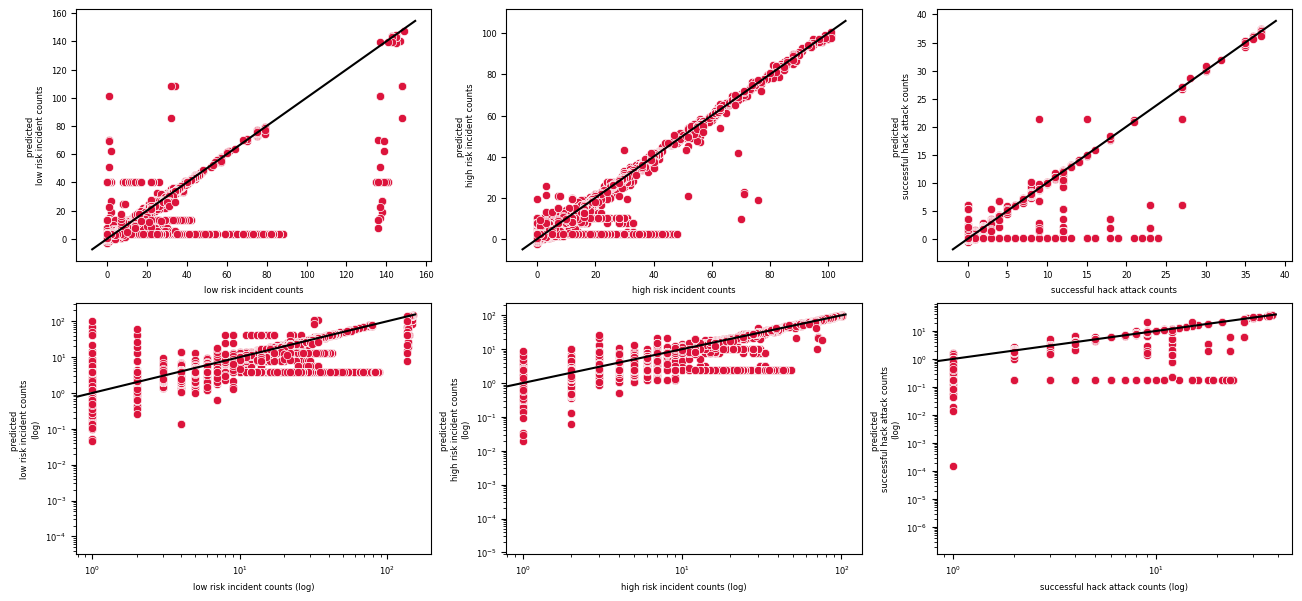

In [1530]:
# Plot real incident counts against predicted counts

# graph_df = y_test.reset_index(drop=True).join(pd.DataFrame(y_pred, columns=['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack'])).join(features5)

perfect_graph_df = y_pred_original_df.copy().rename(columns={'pred lr': 'pred_low_risk', 'pred hr':'pred_high_risk', 'pred sha':'pred_successful_hack_attack'})

all_cols = perfect_graph_df.columns.values
avg_freq_cols = [x for x in perfect_graph_df.columns.values if x.startswith('freq') or x.startswith('avg_')]
select_cols = list(set(all_cols) - set(['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack', 'low_risk', 'high_risk', 'successful_hack_attack']) - set(avg_freq_cols))

fig, ax = plt.subplots(2,3,figsize=(13,6))
g = sns.scatterplot(x=perfect_graph_df['low_risk'], y=perfect_graph_df['pred_low_risk'], ax=ax[0][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][0].set_xlabel('low risk incident counts')
ax[0][0].set_ylabel('predicted \nlow risk incident counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['high_risk'], y=perfect_graph_df['pred_high_risk'], ax=ax[0][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][1].set_xlabel('high risk incident counts')
ax[0][1].set_ylabel('predicted \nhigh risk incident counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['successful_hack_attack'], y=perfect_graph_df['pred_successful_hack_attack'], ax=ax[0][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][2].set_xlabel('successful hack attack counts')
ax[0][2].set_ylabel('predicted \nsuccessful hack attack counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['low_risk'], y=perfect_graph_df['pred_low_risk'], ax=ax[1][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][0].set_xlabel('low risk incident counts (log)')
ax[1][0].set_ylabel('predicted \nlow risk incident counts\n(log)')
ax[1][0].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['high_risk'], y=perfect_graph_df['pred_high_risk'], ax=ax[1][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][1].set_xlabel('high risk incident counts (log)')
ax[1][1].set_ylabel('predicted \nhigh risk incident counts\n(log)')
ax[1][1].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['successful_hack_attack'], y=perfect_graph_df['pred_successful_hack_attack'], ax=ax[1][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][2].set_xlabel('successful hack attack counts (log)')
ax[1][2].set_ylabel('predicted \nsuccessful hack attack counts\n(log)')
ax[1][2].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')


plt.tight_layout()

In [1532]:
# asdf = perfect_graph_df[(perfect_graph_df['pred_low_risk'] < 14.8) & (perfect_graph_df['pred_low_risk'] > 14.7)]
asdf = perfect_graph_df[(perfect_graph_df['pred_low_risk'] < 3.8) & (perfect_graph_df['pred_low_risk'] > 3.5)]
asdf = test_data.reset_index().join(asdf['pred_low_risk']).dropna().drop(columns=['pred_low_risk'])
# # # weird = (weird == 0).sum().sort_values() 
# # weird[weird <= 20400]
asdf



date_start  dns_recursive_mean  dns_recursive_max  untrusted_tls_mean  \
0     2019-02-21                 0.0                0.0                 0.0   
1     2019-02-21                 0.0                0.0                 0.0   
4     2019-02-21                 0.0                0.0                 0.0   
8     2019-02-22                 0.0                0.0                 0.0   
9     2019-02-22                 0.0                0.0                 0.0   
...          ...                 ...                ...                 ...   
44923 2021-01-23                 0.0                0.0                 0.0   
44924 2021-01-23                 0.0                0.0                 0.0   
44926 2021-01-23                 0.0                0.0                 0.0   
44927 2021-01-23                 0.0                0.0                 0.0   
44928 2021-01-23                 0.0                0.0                 0.0   

       untrusted_tls_max  dns_recursive_mean_last14  dns_recursive_max_last14  \
0                    0.0                        0.0                       0.0   
1                    0.0                        0.0                       0.0   
4                    0.0                        0.0                       0.0   
8                    0.0                        0.0                       0.0   
9                    0.0                        0.0                       0.0   
...                  ...                        ...                       ...   
44923                0.0                        0.0                       0.0   
44924                0.0                        0.0                       0.0   
44926                0.0                        0.0                       0.0   
44927                0.0                        0.0                       0.0   
44928                0.0                        0.0                       0.0   

       untrusted_tls_mean_last14  untrusted_tls_max_last14  spam_1  ...  \
0                            0.0                       0.0     0.0  ...   
1                            0.0                       0.0     0.0  ...   
4                            0.0                       0.0     0.0  ...   
8                            0.0                       0.0     0.0  ...   
9                            0.0                       0.0     0.0  ...   
...                          ...                       ...     ...  ...   
44923                        0.0                       0.0     0.0  ...   
44924                        0.0                       0.0     0.0  ...   
44926                        0.0                       0.0     0.0  ...   
44927                        0.0                       0.0     0.0  ...   
44928                        0.0                       0.0     0.0  ...   

       shadowserver_scan_xdmcp_total  shadowserver_sinkhole_dns_total  \
0                                0.0                              0.0   
1                                0.0                              0.0   
4                                0.0                              0.0   
8                                0.0                              0.0   
9                                0.0                              0.0   
...                              ...                              ...   
44923                            0.0                              0.0   
44924                            0.0                              0.0   
44926                            0.0                              0.0   
44927                            0.0                              0.0   
44928                            0.0                              0.0   

       shadowserver_sinkhole_http_drone_total  shadowserver_spam_url_total  \
0                                         0.0                          0.0   
1                                         0.0                          0.0   
4                                         0.0                          0

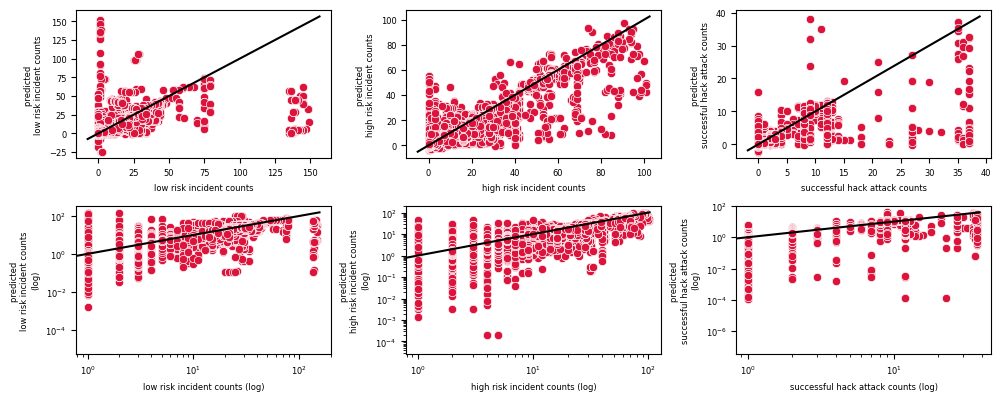

In [1533]:
# Plot real incident counts against predicted counts

# graph_df = y_test.reset_index(drop=True).join(pd.DataFrame(y_pred, columns=['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack'])).join(features5)

perfect_graph_df = results.copy().rename(columns={'pred lr': 'pred_low_risk', 'pred hr':'pred_high_risk', 'pred sha':'pred_successful_hack_attack'})
perfect_graph_df = perfect_graph_df.merge(asdf[[]], left_index=True, right_index=True, how='outer', indicator=True)
perfect_graph_df = perfect_graph_df[perfect_graph_df['_merge'] == 'left_only'].drop(columns=['_merge'])
# perfect_graph_df = perfect_graph_df.merge(qwer[[]], left_index=True, right_index=True, how='outer', indicator=True)
# perfect_graph_df = perfect_graph_df[perfect_graph_df['_merge'] == 'left_only'].drop(columns=['_merge'])
perfect_graph_df

all_cols = perfect_graph_df.columns.values
avg_freq_cols = [x for x in perfect_graph_df.columns.values if x.startswith('freq') or x.startswith('avg_')]
select_cols = list(set(all_cols) - set(['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack', 'low_risk', 'high_risk', 'successful_hack_attack']) - set(avg_freq_cols))

fig, ax = plt.subplots(2,3,figsize=(10,4))
g = sns.scatterplot(x=perfect_graph_df['low_risk'], y=perfect_graph_df['pred_low_risk'], ax=ax[0][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][0].set_xlabel('low risk incident counts')
ax[0][0].set_ylabel('predicted \nlow risk incident counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['high_risk'], y=perfect_graph_df['pred_high_risk'], ax=ax[0][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][1].set_xlabel('high risk incident counts')
ax[0][1].set_ylabel('predicted \nhigh risk incident counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['successful_hack_attack'], y=perfect_graph_df['pred_successful_hack_attack'], ax=ax[0][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][2].set_xlabel('successful hack attack counts')
ax[0][2].set_ylabel('predicted \nsuccessful hack attack counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['low_risk'], y=perfect_graph_df['pred_low_risk'], ax=ax[1][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][0].set_xlabel('low risk incident counts (log)')
ax[1][0].set_ylabel('predicted \nlow risk incident counts\n(log)')
ax[1][0].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['high_risk'], y=perfect_graph_df['pred_high_risk'], ax=ax[1][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][1].set_xlabel('high risk incident counts (log)')
ax[1][1].set_ylabel('predicted \nhigh risk incident counts\n(log)')
ax[1][1].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=perfect_graph_df['successful_hack_attack'], y=perfect_graph_df['pred_successful_hack_attack'], ax=ax[1][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][2].set_xlabel('successful hack attack counts (log)')
ax[1][2].set_ylabel('predicted \nsuccessful hack attack counts\n(log)')
ax[1][2].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')


plt.tight_layout()

In [1523]:
qwer = perfect_graph_df[(perfect_graph_df['low_risk'] < 2) & (perfect_graph_df['low_risk'] > 0) & (perfect_graph_df['pred_low_risk'] > 20)]
all_data.merge(qwer, left_index=True, right_index=True)

dns_recursive_mean  dns_recursive_max  untrusted_tls_mean  \
16656                 0.0                0.0            0.493681   
16671                 0.0                0.0            0.000000   
16757                 0.0                0.0            0.000000   
16817                 0.0                0.0            0.000000   
16893                 0.0                0.0            0.000000   
23765                 0.0                0.0            0.000000   
23836                 0.0                0.0            0.000000   
23878                 0.0                0.0            0.000000   
23946                 0.0                0.0            0.000000   
24012                 0.0                0.0            0.000000   
27268                 0.0                0.0            0.000000   
27367                 0.0                0.0            0.605000   
30810                 0.0                0.0            0.000000   
30854                 0.0                0.0            0.333333   
30940                 0.0                0.0            0.000000   
30960                 0.0                0.0            0.000000   
31189                 0.0                0.0            0.451389   
31266                 0.0                0.0            0.219444   
31296                 0.0                0.0            0.000000   
31341                 0.0                0.0            0.533056   
31424                 0.0                0.0            0.083333   
31470                 0.0                0.0            0.000000   
31552                 0.0                0.0            0.000000   
31575                 0.0                0.0            0.560833   
31671                 0.0                0.0            0.000000   
31776                 0.0                0.0            0.000000   
31824                 0.0                0.0            0.000000   
31859                 0.0                0.0            0.016667   
31949                 0.0                0.0            0.000000   
31995                 0.0                0.0            0.000000   
32074                 0.0                0.0            0.205556   
32141                 0.0                0.0            0.000000   
32201                 0.0                0.0            0.615873   
32307                 0.0                0.0            0.000000   
32335                 0.0                0.0            0.100000   
32460                 0.0                0.0            0.045714   
32530                 0.0                0.0            0.000000   
32558                 0.0                0.0            0.621429   
33034                 0.0                0.0            0.000000   
33109                 0.0                0.0            0.000000   
33211                 0.0                0.0            0.000000   
33334                 0.0                0.0            0.000000   

       untrusted_tls_max  dns_recursive_mean_last14  dns_recursive_max_last14  \
16656                1.0                        0.0                       0.0   
16671                0.0                        0.0                       0.0   
16757                0.0                        0.0                       0.0   
16817                0.0                        0.0                       0.0   
16893                0.0                        0.0                       0.0   
23765                0.0                        0.0                       0.0   
23836                0.0                        0.0                       0.0   
23878                0.0                        0.0                       0.0   
23946                0.0                        0.0                       0.0   
24012                0.0                        0.0                       0.0   
27268                0.0                        0.0                       0.0   
27367                1.0                        0.0                       0.0   
30810                0.0     

In [1535]:
print('Low Risk Mean Absolute Error:', mean_absolute_error(perfect_graph_df['low_risk'], perfect_graph_df['pred_low_risk'], ))
print('High Risk Mean Absolute Error:', mean_absolute_error(perfect_graph_df['high_risk'], perfect_graph_df['pred_high_risk'], ))
print('Successful hack attack Mean Absolute Error:', mean_absolute_error(perfect_graph_df['successful_hack_attack'], perfect_graph_df['pred_successful_hack_attack'],))

Low Risk Mean Absolute Error: 1.990275569119893
High Risk Mean Absolute Error: 1.8415791583357808
Successful hack attack Mean Absolute Error: 0.2551055719773978


In [1536]:
print('Low Risk Root Mean Squared Error:', mean_squared_error(perfect_graph_df['low_risk'], perfect_graph_df['pred_low_risk'], squared=False))
print('High Risk Root Mean Squared Error:', mean_squared_error(perfect_graph_df['high_risk'], perfect_graph_df['pred_high_risk'], squared=False))
print('Successful hack attack Root Mean Squared Error:', mean_squared_error(perfect_graph_df['successful_hack_attack'], perfect_graph_df['pred_successful_hack_attack'], squared=False))

Low Risk Root Mean Squared Error: 7.992360305492749
High Risk Root Mean Squared Error: 4.90751341785368
Successful hack attack Root Mean Squared Error: 1.8630528960774735


In [1537]:
print('Low Risk R2 score:', r2_score(perfect_graph_df['low_risk'], perfect_graph_df['pred_low_risk'], ))
print('High Risk R2 score:', r2_score(perfect_graph_df['high_risk'], perfect_graph_df['pred_high_risk'], ))
print('Successful R2 score:', r2_score(perfect_graph_df['successful_hack_attack'], perfect_graph_df['pred_successful_hack_attack'],))

Low Risk R2 score: 0.28056714402264404
High Risk R2 score: 0.7410471447833014
Successful R2 score: 0.40905762064880824


In [1538]:
print('Total MAE:', mean_absolute_error(perfect_graph_df[['low_risk', 'high_risk', 'successful_hack_attack']], perfect_graph_df[['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack']], ))
print('Total RMSE:', mean_squared_error(perfect_graph_df[['low_risk', 'high_risk', 'successful_hack_attack']], perfect_graph_df[['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack']],squared=False ))
print('Total Risk R2 score:', r2_score(perfect_graph_df[['low_risk', 'high_risk', 'successful_hack_attack']], perfect_graph_df[['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack']], ))

Total MAE: 1.3623200998110239
Total RMSE: 4.9209755398079675
Total Risk R2 score: 0.47689063648491786


In [1539]:
ne_diffs = perfect_graph_df.copy()
ne_diffs['low_risk_diff'] = (ne_diffs['pred_low_risk'] - ne_diffs['low_risk'])
ne_diffs['high_risk_diff'] = (ne_diffs['pred_high_risk'] - ne_diffs['high_risk'])
ne_diffs['sha_diff'] = (ne_diffs['pred_successful_hack_attack'] - ne_diffs['successful_hack_attack'])
ne_diffs[ne_diffs['pred_successful_hack_attack']<1 ].sort_values('successful_hack_attack').head(50)


pred_low_risk  pred_high_risk  pred_successful_hack_attack  low_risk  \
2           0.452715        0.377706                     0.000175       0.0   
29254       0.085143       -0.088917                     0.002517       0.0   
29252       0.877750        0.684814                     0.001240       1.0   
29251       4.909337        6.535744                     0.012444       5.0   
29245       0.232304        0.122893                    -0.000503       0.0   
29241      11.596367        2.769468                     0.034529      12.0   
29240      -0.049640        0.140068                    -0.015232       0.0   
29239       2.327101        1.730797                    -0.000103       1.0   
29236       0.068749        0.061681                    -0.009690       0.0   
29235       0.973338        0.022542                    -0.000061       1.0   
29234      15.029481       11.694407                    -0.000896       2.0   
29231       0.228860        1.905601                    -0.002611       0.0   
29230       3.127692        0.855888                    -0.000002       2.0   
29227       2.914761        2.126306                     0.000449       0.0   
29225       3.059726        8.765962                    -0.001932       4.0   
29224       0.036122        0.115895                     0.002509       0.0   
29223       0.199453        5.639674                     0.001923       1.0   
29216       1.639651        0.223582                    -0.000124       1.0   
29214       1.047143        1.680562                     0.001264       0.0   
29213      13.934357       15.859518                     0.007063      17.0   
29255       2.564200        4.190236                    -0.007160       4.0   
29212       0.694512        2.921541                    -0.004980       1.0   
29256       0.922117        9.938624                    -0.005707       2.0   
29259       1.974833       22.608347                     0.027618       1.0   
29294       1.462297        0.135579                     0.022697       0.0   
29293       0.232304        0.122893                    -0.000503       0.0   
29289      14.282759       15.617074                     0.010695      17.0   
29288      -0.070750        0.976230                     0.064304       0.0   
29287       2.674452        9.223136                     0.000852       4.0   
29284       0.925317        1.418922                    -0.000332       1.0   
29282       0.007136       -0.016675                    -0.000127       0.0   
29281       0.340831       -0.026947                     0.001823       0.0   
29280       1.046499        1.093494                    -0.000696       0.0   
29275       0.068749        0.061681                    -0.009690       0.0   
29274      -0.292831        0.795943                     0.011105       0.0   
29271      19.960371       11.631018                    -0.000036      33.0   
29270       0.364780       -0.105386                     0.022485       0.0   
29269      -0.079709        0.986177                     0.064304       0.0   
29268       1.355185        2.327097                    -0.004056       1.0   
29266      -0.275020        1.623496                     0.314842       0.0   
29265       0.742658        8.165914                    -0.004001       1.0   
29263       0.197741        0.097469                    -0.004029       0.0   
29260       0.007136       -0.016675                    -0.000127       0.0   
29258       4.256745        7.167886                     0.720883       6.0   
29295       1.870964        2.049030                     0.000186      33.0   
29211       5.515771        3.315960                    -0.015866       0.0   
29209      -0.744940        4.166424                     0.018793       0.0   
29164       0.741542       14.687504                    -0.001079       1.0   
29162       0.232304        0.122893                    -0.000503       0.0   
29161       1.639651        0.223582                    -

# Train model, 60 day window, remove size from features, remove >95% sparse feature vectors from data

In [1897]:
WINDOWSIZE = '60D'

In [1898]:
# Load dataset
df2 = pd.read_csv(f'csv/features/rolling_window_dataset_separate_counts_{WINDOWSIZE}.csv')
df2 = df2.drop(columns=['date_end', 'size'])
df2

date_start  dns_recursive_mean  dns_recursive_max  untrusted_tls_mean  \
0      2016-10-19                 0.0                0.0            0.444444   
1      2016-10-20                 0.0                0.0            0.444444   
2      2016-10-21                 0.0                0.0            0.444444   
3      2016-10-22                 0.0                0.0            0.436111   
4      2016-10-23                 0.0                0.0            0.452778   
...           ...                 ...                ...                 ...   
89854  2016-12-17                 0.0                0.0            0.000000   
89855  2016-12-18                 0.0                0.0            0.000000   
89856  2016-12-19                 0.0                0.0            0.000000   
89857  2016-12-20                 0.0                0.0            0.000000   
89858  2016-12-21                 0.0                0.0            0.000000   

       untrusted_tls_max  dns_recursive_mean_last14  dns_recursive_max_last14  \
0                    1.0                        0.0                       0.0   
1                    1.0                        0.0                       0.0   
2                    1.0                        0.0                       0.0   
3                    1.0                        0.0                       0.0   
4                    1.0                        0.0                       0.0   
...                  ...                        ...                       ...   
89854                0.0                        0.0                       0.0   
89855                0.0                        0.0                       0.0   
89856                0.0                        0.0                       0.0   
89857                0.0                        0.0                       0.0   
89858                0.0                        0.0                       0.0   

       untrusted_tls_mean_last14  untrusted_tls_max_last14  spam_1  ...  \
0                       0.928571                       1.0     0.0  ...   
1                       0.964286                       1.0     0.0  ...   
2                       1.000000                       1.0     0.0  ...   
3                       0.964286                       1.0     0.0  ...   
4                       0.964286                       1.0     0.0  ...   
...                          ...                       ...     ...  ...   
89854                   0.000000                       0.0     0.0  ...   
89855                   0.000000                       0.0     0.0  ...   
89856                   0.000000                       0.0     0.0  ...   
89857                   0.000000                       0.0     0.0  ...   
89858                   0.000000                       0.0     0.0  ...   

       shadowserver_scan_xdmcp_total  shadowserver_sinkhole_dns_total  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   
...                              ...                              ...   
89854                            0.0                              0.0   
89855                            0.0                              0.0   
89856                            0.0                              0.0   
89857                            0.0                              0.0   
89858                            0.0                              0.0   

       shadowserver_sinkhole_http_drone_total  shadowserver_spam_url_total  \
0                                         0.0                          0.0   
1                                         0.0                          0.0   
2                                         0.0                

In [1899]:
mask = (
    (df2.drop(
        columns=['low_risk', 'high_risk', 'successful_hack_attack', 'date_start']) == 0).sum(axis=1) < 319)
df2 = df2[mask]
df2

date_start  dns_recursive_mean  dns_recursive_max  untrusted_tls_mean  \
0      2016-10-19                 0.0                0.0            0.444444   
1      2016-10-20                 0.0                0.0            0.444444   
2      2016-10-21                 0.0                0.0            0.444444   
3      2016-10-22                 0.0                0.0            0.436111   
4      2016-10-23                 0.0                0.0            0.452778   
...           ...                 ...                ...                 ...   
89854  2016-12-17                 0.0                0.0            0.000000   
89855  2016-12-18                 0.0                0.0            0.000000   
89856  2016-12-19                 0.0                0.0            0.000000   
89857  2016-12-20                 0.0                0.0            0.000000   
89858  2016-12-21                 0.0                0.0            0.000000   

       untrusted_tls_max  dns_recursive_mean_last14  dns_recursive_max_last14  \
0                    1.0                        0.0                       0.0   
1                    1.0                        0.0                       0.0   
2                    1.0                        0.0                       0.0   
3                    1.0                        0.0                       0.0   
4                    1.0                        0.0                       0.0   
...                  ...                        ...                       ...   
89854                0.0                        0.0                       0.0   
89855                0.0                        0.0                       0.0   
89856                0.0                        0.0                       0.0   
89857                0.0                        0.0                       0.0   
89858                0.0                        0.0                       0.0   

       untrusted_tls_mean_last14  untrusted_tls_max_last14  spam_1  ...  \
0                       0.928571                       1.0     0.0  ...   
1                       0.964286                       1.0     0.0  ...   
2                       1.000000                       1.0     0.0  ...   
3                       0.964286                       1.0     0.0  ...   
4                       0.964286                       1.0     0.0  ...   
...                          ...                       ...     ...  ...   
89854                   0.000000                       0.0     0.0  ...   
89855                   0.000000                       0.0     0.0  ...   
89856                   0.000000                       0.0     0.0  ...   
89857                   0.000000                       0.0     0.0  ...   
89858                   0.000000                       0.0     0.0  ...   

       shadowserver_scan_xdmcp_total  shadowserver_sinkhole_dns_total  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   
...                              ...                              ...   
89854                            0.0                              0.0   
89855                            0.0                              0.0   
89856                            0.0                              0.0   
89857                            0.0                              0.0   
89858                            0.0                              0.0   

       shadowserver_sinkhole_http_drone_total  shadowserver_spam_url_total  \
0                                         0.0                          0.0   
1                                         0.0                          0.0   
2                                         0.0                

In [1900]:
df2 = df2.sort_values('date_start')
train_data2 = df2.iloc[0:round(len(df2.index)/2)]
train_data2['date_start'] = pd.to_datetime(train_data2['date_start'], format='%Y-%m-%d')
train_data2  = train_data2.drop(columns=['date_start'])

test_data2 = df2.iloc[round(len(df2.index)/2):]
test_data2['date_start'] = pd.to_datetime(test_data2['date_start'], format='%Y-%m-%d')
test_data2 = test_data2.set_index('date_start')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1901]:
test_data2

dns_recursive_mean  dns_recursive_max  untrusted_tls_mean  \
date_start                                                              
2019-03-30            0.000000           0.000000            0.016667   
2019-03-30            0.000000           0.000000            0.166667   
2019-03-30            0.000000           0.000000            0.075000   
2019-03-30            0.000000           0.000000            0.158333   
2019-03-30            0.000000           0.000000            0.403611   
...                        ...                ...                 ...   
2021-01-23            0.000000           0.000000            0.026528   
2021-01-23            0.000000           0.000000            0.166667   
2021-01-23            0.000000           0.000000            0.072222   
2021-01-23            0.000000           0.000000            0.220833   
2021-01-23            0.000005           0.000024            0.044748   

            untrusted_tls_max  dns_recursive_mean_last14  \
date_start                                                 
2019-03-30           1.000000                   0.000000   
2019-03-30           1.000000                   0.000000   
2019-03-30           1.000000                   0.000000   
2019-03-30           1.000000                   0.000000   
2019-03-30           1.000000                   0.000000   
...                       ...                        ...   
2021-01-23           0.200000                   0.000000   
2021-01-23           1.000000                   0.000000   
2021-01-23           1.000000                   0.000000   
2021-01-23           1.000000                   0.000000   
2021-01-23           0.115385                   0.000003   

            dns_recursive_max_last14  untrusted_tls_mean_last14  \
date_start                                                        
2019-03-30                  0.000000                   0.000000   
2019-03-30                  0.000000                   0.142857   
2019-03-30                  0.000000                   0.142857   
2019-03-30                  0.000000                   0.321429   
2019-03-30                  0.000000                   0.397619   
...                              ...                        ...   
2021-01-23                  0.000000                   0.007143   
2021-01-23                  0.000000                   0.142857   
2021-01-23                  0.000000                   0.000000   
2021-01-23                  0.000000                   0.071429   
2021-01-23                  0.000024                   0.038276   

            untrusted_tls_max_last14  spam_1  spam_2  ...  \
date_start                                            ...   
2019-03-30                  0.000000     0.0     0.0  ...   
2019-03-30                  1.000000     0.0     0.0  ...   
2019-03-30                  1.000000     0.0     0.0  ...   
2019-03-30                  1.000000     0.0     0.0  ...   
2019-03-30                  1.000000     0.0     0.0  ...   
...                              ...     ...     ...  ...   
2021-01-23                  0.100000     0.0     0.0  ...   
2021-01-23                  1.000000     0.0     0.0  ...   
2021-01-23                  0.000000     0.0     0.0  ...   
2021-01-23                  1.000000     0.0     0.0  ...   
2021-01-23                  0.053892    41.0    41.0  ...   

            shadowserver_scan_xdmcp_total  shadowserver_sinkhole_dns_total  \
date_start                                                                   
2019-03-30                            0.0                              0.0   
2019-03-30                            0.0                              0.0   
2019-03-30                            0.0                              0.0   
2019-03-30                            0.0                              0.0   
2019-03-30                            0.0                              0.0   
...                                   ...                            

In [1902]:
%%time

x_tr2 = train_data2.copy().drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
y_tr2 = train_data2.copy()[['low_risk', 'high_risk', 'successful_hack_attack']]

mses2 = []
results2 = []

params = {'colsample_bytree': 0.9722718894876924,
 'learning_rate': 0.12336834015752808,
 'max_depth': 9,
 'n_estimators': 268,
 'subsample': 0.6891219117705456}

model2 = XGBRegressor(random_state=13, tree_method='hist', **params)

import time
for i, (name, group) in enumerate(test_data2.groupby(pd.Grouper(freq='W'))):
    start = time.time()
    x_te2 = group.drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
    y_te2 = group[['low_risk', 'high_risk', 'successful_hack_attack']]

    model2.fit(x_tr2, y_tr2)
    y_pr2 = model2.predict(x_te2)

    x_tr2 = pd.concat([x_tr2, x_te2])
    y_tr2 = pd.concat([y_tr2, y_te2])
    
    pred_vs_real2 = pd.DataFrame(y_pr2, columns=['pred lr', 'pred hr', 'pred sha'])
    pred_vs_real2 = pred_vs_real2.join(y_te2.reset_index(drop=True))
    results2.append(pred_vs_real2)
    
    end = time.time()
    duration = round(end-start)
    
    date = name.strftime('%Y-%m-%d')
    
    print(f'{i} -> {date} @ {duration} secs')
    
results2 = pd.concat(results2).reset_index(drop=True)

results2

0 -> 2019-03-31 @ 13 secs
1 -> 2019-04-07 @ 13 secs
2 -> 2019-04-14 @ 14 secs
3 -> 2019-04-21 @ 14 secs
4 -> 2019-04-28 @ 14 secs
5 -> 2019-05-05 @ 13 secs
6 -> 2019-05-12 @ 14 secs
7 -> 2019-05-19 @ 16 secs
8 -> 2019-05-26 @ 15 secs
9 -> 2019-06-02 @ 13 secs
10 -> 2019-06-09 @ 14 secs
11 -> 2019-06-16 @ 16 secs
12 -> 2019-06-23 @ 14 secs
13 -> 2019-06-30 @ 23 secs
14 -> 2019-07-07 @ 14 secs
15 -> 2019-07-14 @ 11 secs
16 -> 2019-07-21 @ 73 secs
17 -> 2019-07-28 @ 146 secs
18 -> 2019-08-04 @ 24 secs
19 -> 2019-08-11 @ 12 secs
20 -> 2019-08-18 @ 11 secs
21 -> 2019-08-25 @ 11 secs
22 -> 2019-09-01 @ 13 secs
23 -> 2019-09-08 @ 14 secs
24 -> 2019-09-15 @ 14 secs
25 -> 2019-09-22 @ 14 secs
26 -> 2019-09-29 @ 14 secs
27 -> 2019-10-06 @ 15 secs
28 -> 2019-10-13 @ 14 secs
29 -> 2019-10-20 @ 14 secs
30 -> 2019-10-27 @ 13 secs
31 -> 2019-11-03 @ 15 secs
32 -> 2019-11-10 @ 14 secs
33 -> 2019-11-17 @ 15 secs
34 -> 2019-11-24 @ 14 secs
35 -> 2019-12-01 @ 14 secs
36 -> 2019-12-08 @ 15 secs
37 -> 2019

pred lr   pred hr  pred sha  low_risk  high_risk  \
0      3.310729  1.560191  0.000020       3.0        2.0   
1      0.262717  0.068429  0.002158       0.0        0.0   
2      0.290236 -0.025126 -0.000133       0.0        0.0   
3      2.176320  0.093314  0.000528       0.0        0.0   
4      6.458504  2.215907 -0.000175       7.0        1.0   
...         ...       ...       ...       ...        ...   
18888  3.037161 -0.112176  0.045062       0.0        0.0   
18889  0.703507  0.794658  0.000051       0.0        0.0   
18890  4.340893  4.969611  0.002165       8.0        3.0   
18891  2.479469  7.182164  1.720999       0.0        7.0   
18892  0.131668  1.259140  0.079458       0.0        1.0   

       successful_hack_attack  
0                         0.0  
1                         0.0  
2                         0.0  
3                         0.0  
4                         0.0  
...                       ...  
18888                     0.0  
18889                     0.0  
18890                     0.0  
18891                     3.0  
18892                     0.0  

[18893 rows x 6 columns]

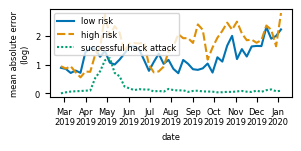

In [1903]:
def calc_errors(group, error_type='mae'):
    error_type = error_type.lower()
    
    if error_type == 'rmse':
        lr = mean_squared_error(group['low_risk'], group['pred lr'], squared=False)
        hr = mean_squared_error(group['high_risk'], group['pred hr'], squared=False)
        sha = mean_squared_error(group['successful_hack_attack'], group['pred sha'], squared=False)
    elif error_type == 'mae':
        lr = mean_absolute_error(group['low_risk'], group['pred lr'])
        hr = mean_absolute_error(group['high_risk'], group['pred hr'])
        sha = mean_absolute_error(group['successful_hack_attack'], group['pred sha'])
    elif error_type == 'r2':
        lr = r2_score(group['low_risk'], group['pred lr'])
        hr = r2_score(group['high_risk'], group['pred hr'])
        sha = r2_score(group['successful_hack_attack'], group['pred sha'])
    else:
        raise Exception('unknown error type.')
    
    result = pd.Series([lr, hr, sha])
    return result

error_type = 'mae'

errors_per_week = results2.join(test_data.reset_index()['date_start'])
errors_per_week = errors_per_week.set_index('date_start').groupby(pd.Grouper(freq='W'))
errors_per_week = errors_per_week.apply(
    lambda group: calc_errors(group, error_type=error_type)
).rename(columns={0: 'low risk', 1: 'high risk', 2: 'successful hack attack'})

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(3, 1.5))

sns.set_palette("colorblind")

sns.lineplot(data=errors_per_week, ax=ax)

ax.set_xlabel('date', fontsize=6)
ax.set_ylabel('mean absolute error\n(log)', fontsize=6)
ax.legend(loc='upper left', fontsize=6)

# Format x-axis ticks to display only the year
date_format = mdates.DateFormatter('%b\n%Y')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(date_format)

# Set font size for axis labels
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

# ax.set_ylim([0,1])

# plt.yscale('log')

plt.tight_layout()
plt.show()

    
# if error_type == 'rmse':
#     fig.savefig('figures/rmse.pdf')
# elif error_type == 'mae':
#     fig.savefig('figures/mean-absolute-error.pdf')
# elif error_type == 'r2':
#     fig.savefig('figures/r2-scores.pdf')

plt.close()


In [1908]:
print('Low Risk Mean Absolute Error:', mean_absolute_error(results2['low_risk'], results2['pred lr'], ))
print('High Risk Mean Absolute Error:', mean_absolute_error(results2['high_risk'], results2['pred hr'], ))
print('Successful hack attack Mean Absolute Error:', mean_absolute_error(results2['successful_hack_attack'], results2['pred sha'],))

Low Risk Mean Absolute Error: 1.271564405087849
High Risk Mean Absolute Error: 1.681605255798618
Successful hack attack Mean Absolute Error: 0.18333182230178285


In [1909]:
print('Low Risk Root Mean Squared Error:', mean_squared_error(results2['low_risk'], results2['pred lr'], squared=False))
print('High Risk Root Mean Squared Error:', mean_squared_error(results2['high_risk'], results2['pred hr'], squared=False))
print('Successful hack attack Root Mean Squared Error:', mean_squared_error(results2['successful_hack_attack'], results2['pred sha'], squared=False))

Low Risk Root Mean Squared Error: 3.4090132158877386
High Risk Root Mean Squared Error: 4.438782676217493
Successful hack attack Root Mean Squared Error: 1.5903880467345306


In [1906]:
print('Low Risk R2 score:', r2_score(results2['low_risk'], results2['pred lr'], ))
print('High Risk R2 score:', r2_score(results2['high_risk'], results2['pred hr'], ))
print('Successful R2 score:', r2_score(results2['successful_hack_attack'], results2['pred sha'],))

Low Risk R2 score: 0.7260540859931541
High Risk R2 score: 0.7968149024164765
Successful R2 score: 0.4859419484971056


In [1910]:
print('Total MAE:', mean_absolute_error(results2[['low_risk', 'high_risk', 'successful_hack_attack']], results2[['pred lr', 'pred hr', 'pred sha']], ))
print('Total RMSE:', mean_squared_error(results2[['low_risk', 'high_risk', 'successful_hack_attack']], results2[['pred lr', 'pred hr', 'pred sha']],squared=False ))
print('Total Risk R2 score:', r2_score(results2[['low_risk', 'high_risk', 'successful_hack_attack']], results2[['pred lr', 'pred hr', 'pred sha']], ))

Total MAE: 1.0455004943960835
Total RMSE: 3.1460613129465873
Total Risk R2 score: 0.6696036456355787


In [1911]:
n_test_samples = len(results2.index)
n_features = len(x_tr2.columns.values)

print('Low Risk ADJUSTED R2 score:', adjusted_r2_score(results2['low_risk'], results2['pred lr'], n_test_samples, n_features))
print('High Risk ADJUSTED R2 score:', adjusted_r2_score(results2['high_risk'], results2['pred hr'], n_test_samples, n_features))
print('Successful ADJUSTED R2 score:', adjusted_r2_score(results2['successful_hack_attack'], results2['pred sha'],n_test_samples, n_features))

Low Risk ADJUSTED R2 score: 0.7210936512493354
High Risk ADJUSTED R2 score: 0.7931357585930197
Successful ADJUSTED R2 score: 0.4766337190670037


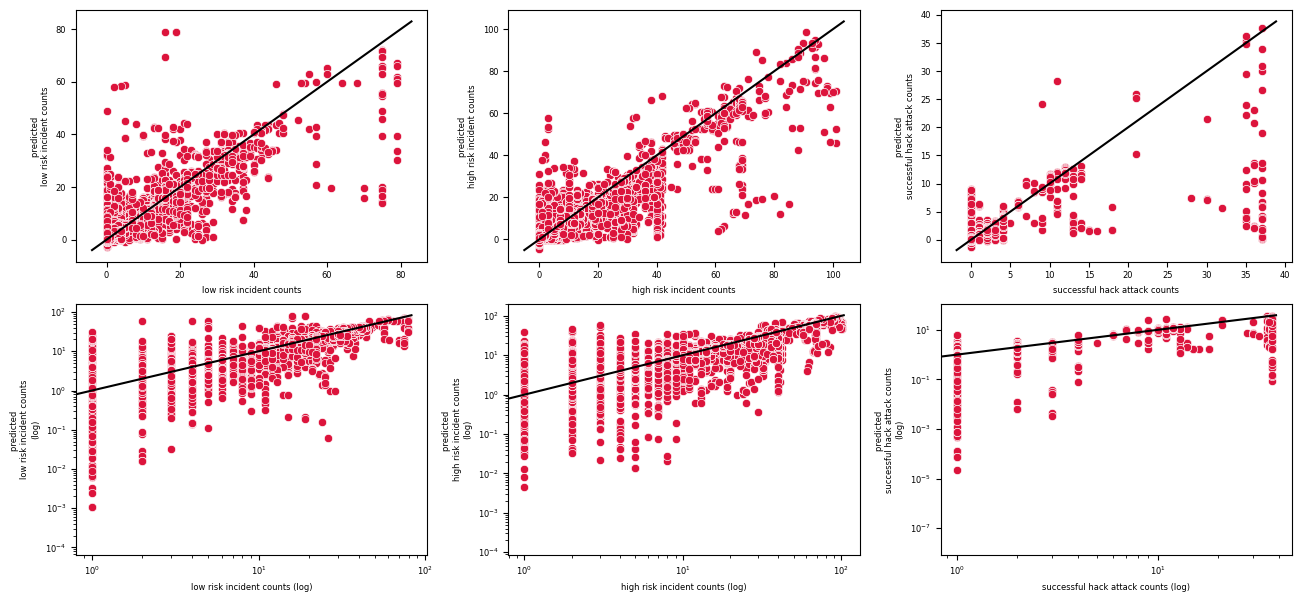

In [1907]:
# Plot real incident counts against predicted counts

# graph_df = y_test.reset_index(drop=True).join(pd.DataFrame(y_pred, columns=['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack'])).join(features5)

graph_df = results2.copy().rename(columns={'pred lr': 'pred_low_risk', 'pred hr':'pred_high_risk', 'pred sha':'pred_successful_hack_attack'})

all_cols = graph_df.columns.values
avg_freq_cols = [x for x in graph_df.columns.values if x.startswith('freq') or x.startswith('avg_')]
select_cols = list(set(all_cols) - set(['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack', 'low_risk', 'high_risk', 'successful_hack_attack']) - set(avg_freq_cols))

fig, ax = plt.subplots(2,3,figsize=(13,6))
g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[0][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][0].set_xlabel('low risk incident counts')
ax[0][0].set_ylabel('predicted \nlow risk incident counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[0][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][1].set_xlabel('high risk incident counts')
ax[0][1].set_ylabel('predicted \nhigh risk incident counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[0][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][2].set_xlabel('successful hack attack counts')
ax[0][2].set_ylabel('predicted \nsuccessful hack attack counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[1][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][0].set_xlabel('low risk incident counts (log)')
ax[1][0].set_ylabel('predicted \nlow risk incident counts\n(log)')
ax[1][0].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[1][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][1].set_xlabel('high risk incident counts (log)')
ax[1][1].set_ylabel('predicted \nhigh risk incident counts\n(log)')
ax[1][1].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[1][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][2].set_xlabel('successful hack attack counts (log)')
ax[1][2].set_ylabel('predicted \nsuccessful hack attack counts\n(log)')
ax[1][2].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')


plt.tight_layout()

In [1923]:
rounded = results2.apply(lambda x: abs(round(x)))

print('Total MAE:', mean_absolute_error(rounded[['low_risk', 'high_risk', 'successful_hack_attack']], rounded[['pred lr', 'pred hr', 'pred sha']], ))
print('Total RMSE:', mean_squared_error(rounded[['low_risk', 'high_risk', 'successful_hack_attack']], rounded[['pred lr', 'pred hr', 'pred sha']],squared=False ))
print('Total Risk R2 score:', r2_score(rounded[['low_risk', 'high_risk', 'successful_hack_attack']], rounded[['pred lr', 'pred hr', 'pred sha']], ))

Total MAE: 1.0007410151908114
Total RMSE: 3.1497078627097577
Total Risk R2 score: 0.668767158938997


In [428]:
asdf = results2.copy().rename(columns={'pred lr': 'pred_low_risk', 'pred hr':'pred_high_risk', 'pred sha':'pred_successful_hack_attack'})
asdf = asdf[(asdf['pred_low_risk'] < 2) & (asdf['pred_low_risk'] > 0)]
asdf

pred_low_risk  pred_high_risk  pred_successful_hack_attack  low_risk  \
15          1.772737        0.948873                    -0.002673       0.0   
24          0.021672       -0.025727                    -0.000102       0.0   
26          1.833086        0.953167                    -0.017832       0.0   
46          0.003863        0.022757                     0.009402       0.0   
49          1.028309        0.853734                     0.001136       0.0   
...              ...             ...                          ...       ...   
35110       0.395576       -2.986777                     0.094722       0.0   
35129       0.031976        3.712039                     0.253169       0.0   
35141       1.165221        0.663095                    -0.039921       0.0   
35143       0.974247        1.824149                     0.106086       0.0   
35159       1.126117        1.058354                     0.041419      11.0   

       high_risk  successful_hack_attack  
15           0.0                     0.0  
24           0.0                     0.0  
26           0.0                     0.0  
46           0.0                     0.0  
49           0.0                     0.0  
...          ...                     ...  
35110        0.0                     0.0  
35129        0.0                     0.0  
35141        0.0                     0.0  
35143        0.0                     0.0  
35159        6.0                     0.0  

[3712 rows x 6 columns]

# Train model, 30-day window, remove size from features

In [10]:
WINDOWSIZE = '30D'

In [11]:
# Load dataset
df2 = pd.read_csv(f'csv/features/rolling_window_dataset_separate_counts_{WINDOWSIZE}.csv')
df2 = df2.drop(columns=['date_end', 'size'])
df2

date_start  dns_recursive_mean  dns_recursive_max  untrusted_tls_mean  \
0      2016-10-19                 0.0                0.0            0.288889   
1      2016-10-20                 0.0                0.0            0.255556   
2      2016-10-21                 0.0                0.0            0.222222   
3      2016-10-22                 0.0                0.0            0.188889   
4      2016-10-23                 0.0                0.0            0.222222   
...           ...                 ...                ...                 ...   
93561  2017-02-15                 0.0                0.0            0.000000   
93562  2017-02-16                 0.0                0.0            0.000000   
93563  2017-02-17                 0.0                0.0            0.000000   
93564  2017-02-18                 0.0                0.0            0.000000   
93565  2017-02-19                 0.0                0.0            0.000000   

       untrusted_tls_max  dns_recursive_mean_last14  dns_recursive_max_last14  \
0                    1.0                        0.0                       0.0   
1                    1.0                        0.0                       0.0   
2                    1.0                        0.0                       0.0   
3                    1.0                        0.0                       0.0   
4                    1.0                        0.0                       0.0   
...                  ...                        ...                       ...   
93561                0.0                        0.0                       0.0   
93562                0.0                        0.0                       0.0   
93563                0.0                        0.0                       0.0   
93564                0.0                        0.0                       0.0   
93565                0.0                        0.0                       0.0   

       untrusted_tls_mean_last14  untrusted_tls_max_last14  spam_1  ...  \
0                       0.190476                       0.5     0.0  ...   
1                       0.190476                       0.5     0.0  ...   
2                       0.190476                       0.5     0.0  ...   
3                       0.190476                       0.5     0.0  ...   
4                       0.226190                       1.0     0.0  ...   
...                          ...                       ...     ...  ...   
93561                   0.000000                       0.0     0.0  ...   
93562                   0.000000                       0.0     0.0  ...   
93563                   0.000000                       0.0     0.0  ...   
93564                   0.000000                       0.0     0.0  ...   
93565                   0.000000                       0.0     0.0  ...   

       shadowserver_scan_xdmcp_total  shadowserver_sinkhole_dns_total  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   
...                              ...                              ...   
93561                            0.0                              0.0   
93562                            0.0                              0.0   
93563                            0.0                              0.0   
93564                            0.0                              0.0   
93565                            0.0                              0.0   

       shadowserver_sinkhole_http_drone_total  shadowserver_spam_url_total  \
0                                         0.0                          0.0   
1                                         0.0                          0.0   
2                                         0.0                

In [12]:
df2 = df.sort_values('date_start')
train_data2 = df2.iloc[0:round(len(df2.index)/2)]
train_data2['date_start'] = pd.to_datetime(train_data2['date_start'], format='%Y-%m-%d')
train_data2  = train_data2.drop(columns=['date_start'])

test_data2 = df2.iloc[round(len(df2.index)/2):]
test_data2['date_start'] = pd.to_datetime(test_data2['date_start'], format='%Y-%m-%d')
test_data2 = test_data2.set_index('date_start')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
test_data2

dns_recursive_mean  dns_recursive_max  untrusted_tls_mean  \
date_start                                                              
2019-02-15                 0.0                0.0            0.477778   
2019-02-15                 0.0                0.0            0.000000   
2019-02-15                 0.0                0.0            0.183333   
2019-02-15                 0.0                0.0            0.507500   
2019-02-15                 0.0                0.0            0.200000   
...                        ...                ...                 ...   
2021-01-23                 0.0                0.0            0.000000   
2021-01-23                 0.0                0.0            0.016667   
2021-01-23                 0.0                0.0            0.000000   
2021-01-23                 0.0                0.0            0.050000   
2021-01-23                 0.0                0.0            0.050000   

            untrusted_tls_max  dns_recursive_mean_last14  \
date_start                                                 
2019-02-15                1.0                        0.0   
2019-02-15                0.0                        0.0   
2019-02-15                1.0                        0.0   
2019-02-15                1.0                        0.0   
2019-02-15                1.0                        0.0   
...                       ...                        ...   
2021-01-23                0.0                        0.0   
2021-01-23                1.0                        0.0   
2021-01-23                0.0                        0.0   
2021-01-23                1.0                        0.0   
2021-01-23                1.0                        0.0   

            dns_recursive_max_last14  untrusted_tls_mean_last14  \
date_start                                                        
2019-02-15                       0.0                   0.214286   
2019-02-15                       0.0                   0.000000   
2019-02-15                       0.0                   0.071429   
2019-02-15                       0.0                   0.607143   
2019-02-15                       0.0                   0.357143   
...                              ...                        ...   
2021-01-23                       0.0                   0.000000   
2021-01-23                       0.0                   0.000000   
2021-01-23                       0.0                   0.000000   
2021-01-23                       0.0                   0.035714   
2021-01-23                       0.0                   0.000000   

            untrusted_tls_max_last14  spam_1  spam_2  ...  \
date_start                                            ...   
2019-02-15                       1.0     0.0     0.0  ...   
2019-02-15                       0.0     0.0     0.0  ...   
2019-02-15                       1.0     0.0     0.0  ...   
2019-02-15                       1.0     0.0     0.0  ...   
2019-02-15                       1.0     0.0     0.0  ...   
...                              ...     ...     ...  ...   
2021-01-23                       0.0     0.0     0.0  ...   
2021-01-23                       0.0     0.0     0.0  ...   
2021-01-23                       0.0     0.0     0.0  ...   
2021-01-23                       0.5     0.0     0.0  ...   
2021-01-23                       0.0     0.0     0.0  ...   

            shadowserver_scan_xdmcp_total  shadowserver_sinkhole_dns_total  \
date_start                                                                   
2019-02-15                            0.0                              0.0   
2019-02-15                            0.0                              0.0   
2019-02-15                            0.0                              0.0   
2019-02-15                            0.0                              0.0   
2019-02-15                            0.0                              0.0   
...                                   ...                            

In [ ]:
x_tr2 = train_data2.copy().drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
y_tr2 = train_data2.copy()[['low_risk', 'high_risk', 'successful_hack_attack']]

mses2 = []
results2 = []

params = {'colsample_bytree': 0.9722718894876924,
 'learning_rate': 0.12336834015752808,
 'max_depth': 9,
 'n_estimators': 268,
 'subsample': 0.6891219117705456}

model2 = XGBRegressor(random_state=13, tree_method='hist', **params)

for i, (name, group) in enumerate(test_data2.groupby(pd.Grouper(freq='W'))):
    x_te2 = group.drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
    y_te2 = group[['low_risk', 'high_risk', 'successful_hack_attack']]

    model2.fit(x_tr2, y_tr2)
    y_pr2 = model2.predict(x_te2)

    x_tr2 = pd.concat([x_tr2, x_te2])
    y_tr2 = pd.concat([y_tr2, y_te2])
    
    pred_vs_real2 = pd.DataFrame(y_pr2, columns=['pred lr', 'pred hr', 'pred sha'])
    pred_vs_real2 = pred_vs_real2.join(y_te2.reset_index(drop=True))
    results2.append(pred_vs_real2)
    
    print(f'{i} -> {name}')
    
results2 = pd.concat(results2).reset_index(drop=True)

results2

0 -> 2019-02-17 00:00:00
1 -> 2019-02-24 00:00:00
2 -> 2019-03-03 00:00:00
3 -> 2019-03-10 00:00:00
4 -> 2019-03-17 00:00:00
5 -> 2019-03-24 00:00:00
6 -> 2019-03-31 00:00:00
7 -> 2019-04-07 00:00:00
8 -> 2019-04-14 00:00:00
9 -> 2019-04-21 00:00:00
10 -> 2019-04-28 00:00:00
11 -> 2019-05-05 00:00:00
12 -> 2019-05-12 00:00:00
13 -> 2019-05-19 00:00:00
14 -> 2019-05-26 00:00:00
15 -> 2019-06-02 00:00:00
16 -> 2019-06-09 00:00:00
17 -> 2019-06-16 00:00:00
18 -> 2019-06-23 00:00:00
19 -> 2019-06-30 00:00:00
20 -> 2019-07-07 00:00:00
21 -> 2019-07-14 00:00:00
22 -> 2019-07-21 00:00:00
23 -> 2019-07-28 00:00:00
24 -> 2019-08-04 00:00:00
25 -> 2019-08-11 00:00:00
26 -> 2019-08-18 00:00:00
27 -> 2019-08-25 00:00:00
28 -> 2019-09-01 00:00:00
29 -> 2019-09-08 00:00:00
30 -> 2019-09-15 00:00:00
31 -> 2019-09-22 00:00:00
32 -> 2019-09-29 00:00:00
33 -> 2019-10-06 00:00:00
34 -> 2019-10-13 00:00:00
35 -> 2019-10-20 00:00:00
36 -> 2019-10-27 00:00:00
37 -> 2019-11-03 00:00:00
38 -> 2019-11-10 00:00

In [17]:
print('Low Risk Root Mean Squared Error:', mean_squared_error(results2['low_risk'], results2['pred lr'], squared=False))
print('High Risk Root Mean Squared Error:', mean_squared_error(results2['high_risk'], results2['pred hr'], squared=False))
print('Successful hack attack Root Mean Squared Error:', mean_squared_error(results2['successful_hack_attack'], results2['pred sha'], squared=False))

Low Risk Root Mean Squared Error: 31.850670054334817
High Risk Root Mean Squared Error: 25.377437997941232
Successful hack attack Root Mean Squared Error: 1.6125859931167608


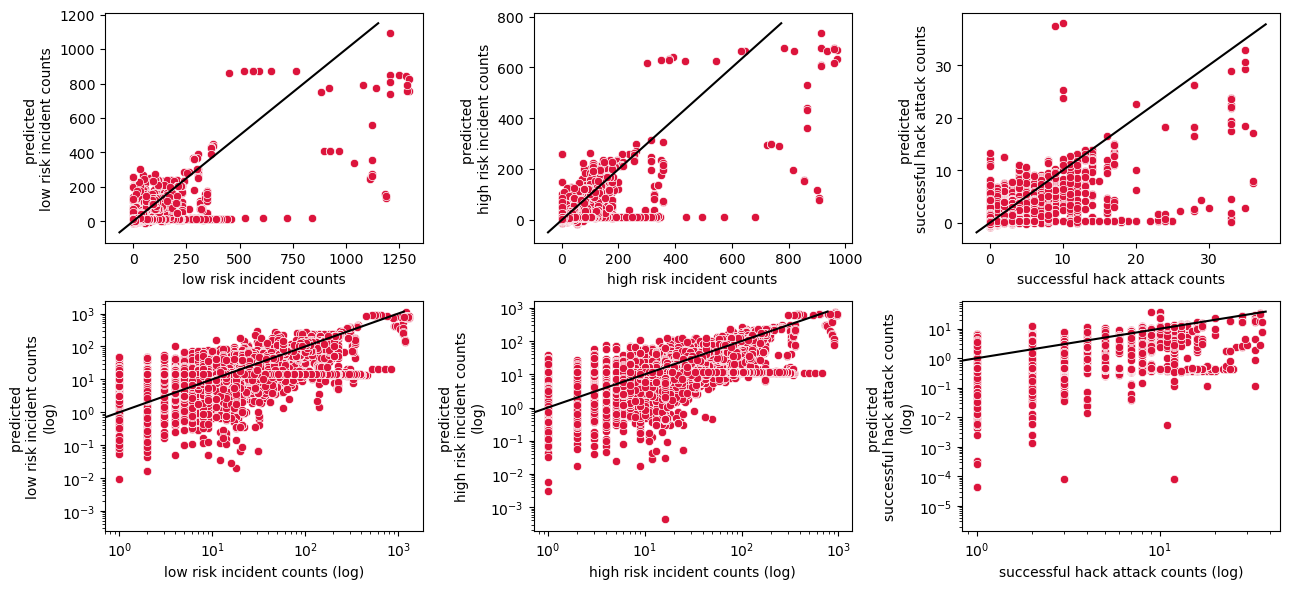

In [18]:
# Plot real incident counts against predicted counts

# graph_df = y_test.reset_index(drop=True).join(pd.DataFrame(y_pred, columns=['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack'])).join(features5)

graph_df = results2.copy().rename(columns={'pred lr': 'pred_low_risk', 'pred hr':'pred_high_risk', 'pred sha':'pred_successful_hack_attack'})

all_cols = graph_df.columns.values
avg_freq_cols = [x for x in graph_df.columns.values if x.startswith('freq') or x.startswith('avg_')]
select_cols = list(set(all_cols) - set(['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack', 'low_risk', 'high_risk', 'successful_hack_attack']) - set(avg_freq_cols))

fig, ax = plt.subplots(2,3,figsize=(13,6))
g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[0][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][0].set_xlabel('low risk incident counts')
ax[0][0].set_ylabel('predicted \nlow risk incident counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[0][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][1].set_xlabel('high risk incident counts')
ax[0][1].set_ylabel('predicted \nhigh risk incident counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[0][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][2].set_xlabel('successful hack attack counts')
ax[0][2].set_ylabel('predicted \nsuccessful hack attack counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[1][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][0].set_xlabel('low risk incident counts (log)')
ax[1][0].set_ylabel('predicted \nlow risk incident counts\n(log)')
ax[1][0].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[1][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][1].set_xlabel('high risk incident counts (log)')
ax[1][1].set_ylabel('predicted \nhigh risk incident counts\n(log)')
ax[1][1].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[1][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][2].set_xlabel('successful hack attack counts (log)')
ax[1][2].set_ylabel('predicted \nsuccessful hack attack counts\n(log)')
ax[1][2].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')


plt.tight_layout()

# Keep track of SHAP values as model is trained and tested

In [906]:
%%time

x_tr3 = train_data.copy().drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
y_tr3 = train_data.copy()[['low_risk', 'high_risk', 'successful_hack_attack']]

mses3 = []
errors3 = []
results3 = []
original_shap_values = [ np.empty((0,len(x_tr3.columns))), np.empty((0,len(x_tr3.columns))), np.empty((0,len(x_tr3.columns))), ]

params = {'colsample_bytree': 0.9722718894876924,
 'learning_rate': 0.12336834015752808,
 'max_depth': 9,
 'n_estimators': 268,
 'subsample': 0.6891219117705456}

model3 = XGBRegressor(random_state=13, tree_method='hist', **params)

import time
for i, (name, group) in enumerate(test_data.groupby(pd.Grouper(freq='W'))):
    start = time.time()
    x_te3 = group.drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
    y_te3 = group[['low_risk', 'high_risk', 'successful_hack_attack']]

    model3.fit(x_tr3, y_tr3)
    y_pr3 = model3.predict(x_te3)

    x_tr3 = pd.concat([x_tr3, x_te3])
    y_tr3 = pd.concat([y_tr3, y_te3])
    
    
    explainer3 = shap.TreeExplainer(model3)
    shap_values_temp = explainer3.shap_values(x_te3)
    for j in range(len(shap_values_temp)):
        old_shap_values = original_shap_values[j]
        new_shap_values = shap_values_temp[j]
        new_shap_values = np.concatenate((old_shap_values, new_shap_values))
        original_shap_values[j] = new_shap_values
    
    pred_vs_real3 = pd.DataFrame(y_pr3, columns=['pred lr', 'pred hr', 'pred sha'])
    pred_vs_real3 = pred_vs_real3.join(y_te3.reset_index(drop=True))
    results3.append(pred_vs_real3)
    
    end = time.time()
    duration = round(end-start)
    
    date = name.strftime('%Y-%m-%d')
    
    print(f'{i} -> {date} @ {duration} secs')
    
results3 = pd.concat(results3).reset_index(drop=True)

results3

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0 -> 2019-02-17 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


1 -> 2019-02-24 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


2 -> 2019-03-03 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


3 -> 2019-03-10 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


4 -> 2019-03-17 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


5 -> 2019-03-24 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


6 -> 2019-03-31 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


7 -> 2019-04-07 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


8 -> 2019-04-14 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


9 -> 2019-04-21 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


10 -> 2019-04-28 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


11 -> 2019-05-05 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


12 -> 2019-05-12 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


13 -> 2019-05-19 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


14 -> 2019-05-26 @ 16 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


15 -> 2019-06-02 @ 97 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


16 -> 2019-06-09 @ 133 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


17 -> 2019-06-16 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


18 -> 2019-06-23 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


19 -> 2019-06-30 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


20 -> 2019-07-07 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


21 -> 2019-07-14 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


22 -> 2019-07-21 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


23 -> 2019-07-28 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


24 -> 2019-08-04 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


25 -> 2019-08-11 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


26 -> 2019-08-18 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


27 -> 2019-08-25 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


28 -> 2019-09-01 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


29 -> 2019-09-08 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


30 -> 2019-09-15 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


31 -> 2019-09-22 @ 26 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


32 -> 2019-09-29 @ 30 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


33 -> 2019-10-06 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


34 -> 2019-10-13 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


35 -> 2019-10-20 @ 157 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


36 -> 2019-10-27 @ 67 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


37 -> 2019-11-03 @ 16 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


38 -> 2019-11-10 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


39 -> 2019-11-17 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


40 -> 2019-11-24 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


41 -> 2019-12-01 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


42 -> 2019-12-08 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


43 -> 2019-12-15 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


44 -> 2019-12-22 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


45 -> 2019-12-29 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


46 -> 2020-01-05 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


47 -> 2020-01-12 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


48 -> 2020-01-19 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


49 -> 2020-01-26 @ 27 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


50 -> 2020-02-02 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


51 -> 2020-02-09 @ 28 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


52 -> 2020-02-16 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


53 -> 2020-02-23 @ 27 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


54 -> 2020-03-01 @ 154 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


55 -> 2020-03-08 @ 64 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


56 -> 2020-03-15 @ 18 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


57 -> 2020-03-22 @ 17 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


58 -> 2020-03-29 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


59 -> 2020-04-05 @ 20 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


60 -> 2020-04-12 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


61 -> 2020-04-19 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


62 -> 2020-04-26 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


63 -> 2020-05-03 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


64 -> 2020-05-10 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


65 -> 2020-05-17 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


66 -> 2020-05-24 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


67 -> 2020-05-31 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


68 -> 2020-06-07 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


69 -> 2020-06-14 @ 31 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


70 -> 2020-06-21 @ 32 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


71 -> 2020-06-28 @ 35 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


72 -> 2020-07-05 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


73 -> 2020-07-12 @ 146 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


74 -> 2020-07-19 @ 97 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


75 -> 2020-07-26 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


76 -> 2020-08-02 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


77 -> 2020-08-09 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


78 -> 2020-08-16 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


79 -> 2020-08-23 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


80 -> 2020-08-30 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


81 -> 2020-09-06 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


82 -> 2020-09-13 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


83 -> 2020-09-20 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


84 -> 2020-09-27 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


85 -> 2020-10-04 @ 28 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


86 -> 2020-10-11 @ 25 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


87 -> 2020-10-18 @ 38 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


88 -> 2020-10-25 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


89 -> 2020-11-01 @ 19 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


90 -> 2020-11-08 @ 155 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


91 -> 2020-11-15 @ 71 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


92 -> 2020-11-22 @ 21 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


93 -> 2020-11-29 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


94 -> 2020-12-06 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


95 -> 2020-12-13 @ 24 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


96 -> 2020-12-20 @ 23 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


97 -> 2020-12-27 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


98 -> 2021-01-03 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


99 -> 2021-01-10 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


100 -> 2021-01-17 @ 22 secs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


101 -> 2021-01-24 @ 22 secs
CPU times: user 1d 18h 30min 31s, sys: 4min, total: 1d 18h 34min 32s
Wall time: 52min 18s


pred lr    pred hr  pred sha  low_risk  high_risk  \
0      13.778646  11.054489  0.366716       0.0        0.0   
1       3.639606   3.284065  0.006017       0.0        0.0   
2       5.720071   5.425783 -0.006563      12.0        7.0   
3      13.778646  11.054489  0.366716       1.0        1.0   
4       9.395056  11.063077 -0.011196      10.0       12.0   
...          ...        ...       ...       ...        ...   
45416  14.763942  12.036900  0.453971      18.0       11.0   
45417  14.763942  12.036900  0.453971      27.0       19.0   
45418  16.887724   9.101253  0.510255       0.0        0.0   
45419  14.763942  12.036900  0.453971      48.0       48.0   
45420   7.677301   5.431120  0.073117       0.0        0.0   

       successful_hack_attack  
0                         0.0  
1                         0.0  
2                         0.0  
3                         1.0  
4                         0.0  
...                       ...  
45416                     0.0  
45417                     0.0  
45418                     0.0  
45419                     0.0  
45420                     0.0  

[45421 rows x 6 columns]

In [907]:
results3

pred lr    pred hr  pred sha  low_risk  high_risk  \
0      13.778646  11.054489  0.366716       0.0        0.0   
1       3.639606   3.284065  0.006017       0.0        0.0   
2       5.720071   5.425783 -0.006563      12.0        7.0   
3      13.778646  11.054489  0.366716       1.0        1.0   
4       9.395056  11.063077 -0.011196      10.0       12.0   
...          ...        ...       ...       ...        ...   
45416  14.763942  12.036900  0.453971      18.0       11.0   
45417  14.763942  12.036900  0.453971      27.0       19.0   
45418  16.887724   9.101253  0.510255       0.0        0.0   
45419  14.763942  12.036900  0.453971      48.0       48.0   
45420   7.677301   5.431120  0.073117       0.0        0.0   

       successful_hack_attack  
0                         0.0  
1                         0.0  
2                         0.0  
3                         1.0  
4                         0.0  
...                       ...  
45416                     0.0  
45417                     0.0  
45418                     0.0  
45419                     0.0  
45420                     0.0  

[45421 rows x 6 columns]

In [908]:
original_shap_values

[array([[-1.50655792e-03, -1.69541803e-04, -1.27430975e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.70452048e-03,  1.22647779e-03, -2.08208466e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.17214210e-02,  2.24866392e-03, -2.71808052e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 4.78886776e-02, -1.31287752e-03, -1.80300498e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.25396425e-02, -1.97044830e-03, -1.90332019e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.60548939e-02, -2.16621393e-03, -1.07375479e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([[ 3.12468093e-02, -1.50083633e-05, -1.63992262e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.83126999e-02, -3.72059330e-05, -1.85164762e+00, ...,
          0.00000000e+00,  0.00000000e

In [909]:
diffs3 = results3.copy()
diffs3['low_risk_diff'] = (diffs3['pred lr'] - diffs3['low_risk'])
diffs3['high_risk_diff'] = (diffs3['pred hr'] - diffs3['high_risk'])
diffs3['sha_diff'] = (diffs3['pred sha'] - diffs3['successful_hack_attack'])
diffs3.sort_values('high_risk_diff')

pred lr     pred hr   pred sha  low_risk  high_risk  \
35746  147.194489   55.261784   3.320664    1186.0      907.0   
35656  146.290222   59.017384   3.864088    1186.0      907.0   
35635  187.063019   75.794418   5.196662    1180.0      900.0   
35294  274.414886  144.473282   6.000068    1113.0      855.0   
35191  274.597504  145.189880   5.908816    1113.0      855.0   
...           ...         ...        ...       ...        ...   
42613  269.016998  269.046326   1.260810       0.0        0.0   
42710  269.016998  269.046326   1.260810       0.0        0.0   
37037  917.090088  666.865295  10.032627     561.0      378.0   
37206  893.172852  594.257507   6.286866     448.0      300.0   
37064  911.324951  678.644409   8.058805     561.0      378.0   

       successful_hack_attack  low_risk_diff  high_risk_diff   sha_diff  
35746                    17.0   -1038.805511     -851.738216 -13.679336  
35656                    17.0   -1039.709778     -847.982616 -13.135912  
35635                    17.0    -992.936981     -824.205582 -11.803338  
35294                    16.0    -838.585114     -710.526718  -9.999932  
35191                    16.0    -838.402496     -709.810120 -10.091184  
...                       ...            ...             ...        ...  
42613                     0.0     269.016998      269.046326   1.260810  
42710                     0.0     269.016998      269.046326   1.260810  
37037                     9.0     356.090088      288.865295   1.032627  
37206                     6.0     445.172852      294.257507   0.286866  
37064                     9.0     350.324951      300.644409  -0.941195  

[45421 rows x 9 columns]

In [915]:
# Investigating high_risk prediction error
# Real value is 1052, predicted value is 16.83
# Why? Because entire feature vector is zero, see below
i = 42710
shap.force_plot(explainer.expected_value[1], original_shap_values[1][i], x_te_original.iloc[i], matplotlib=False)

In [917]:
%%time

df4 = pd.read_csv(f'csv/features/rolling_window_dataset_separate_counts_{WINDOWSIZE}.csv')
df4 = df4.drop(columns=['date_end'])

df4 = df4.sort_values('date_start')
train_data4 = df4.iloc[0:round(len(df4.index)/2)]
train_data4['date_start'] = pd.to_datetime(train_data4['date_start'], format='%Y-%m-%d')
train_data4  = train_data4.drop(columns=['date_start'])

test_data4 = df4.iloc[round(len(df4.index)/2):]
test_data4['date_start'] = pd.to_datetime(test_data4['date_start'], format='%Y-%m-%d')
test_data4 = test_data4.set_index('date_start')


x_tr4 = train_data4.copy().drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
y_tr4 = train_data4.copy()[['low_risk', 'high_risk', 'successful_hack_attack']]

del df4
del train_data4

mses4 = []
errors4 = []
results4 = []

params = {'colsample_bytree': 0.9722718894876924,
 'learning_rate': 0.12336834015752808,
 'max_depth': 9,
 'n_estimators': 268,
 'subsample': 0.6891219117705456}

model4 = XGBRegressor(random_state=13, tree_method='hist', **params)

import time
for i, (name, group) in enumerate(test_data4.groupby(pd.Grouper(freq='W'))):
    start = time.time()
    x_te4 = group.drop(columns=['low_risk', 'high_risk', 'successful_hack_attack'])
    y_te4 = group[['low_risk', 'high_risk', 'successful_hack_attack']]

    model4.fit(x_tr4, y_tr4)
    y_pr4 = model4.predict(x_te4)

    x_tr4 = pd.concat([x_tr4, x_te4])
    y_tr4 = pd.concat([y_tr4, y_te4])
    
    pred_vs_real4 = pd.DataFrame(y_pr4, columns=['pred lr', 'pred hr', 'pred sha'])
    pred_vs_real4 = pred_vs_real4.join(y_te4.reset_index(drop=True))
    results4.append(pred_vs_real4)
    
    end = time.time()
    duration = round(end-start)
    
    date = name.strftime('%Y-%m-%d')
    
    print(f'{i} -> {date} @ {duration} secs')
    
results4 = pd.concat(results4).reset_index(drop=True)

results4


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0 -> 2019-02-17 @ 16 secs
1 -> 2019-02-24 @ 16 secs
2 -> 2019-03-03 @ 16 secs
3 -> 2019-03-10 @ 15 secs
4 -> 2019-03-17 @ 16 secs
5 -> 2019-03-24 @ 20 secs
6 -> 2019-03-31 @ 15 secs
7 -> 2019-04-07 @ 16 secs
8 -> 2019-04-14 @ 19 secs
9 -> 2019-04-21 @ 19 secs
10 -> 2019-04-28 @ 13 secs
11 -> 2019-05-05 @ 13 secs
12 -> 2019-05-12 @ 70 secs
13 -> 2019-05-19 @ 151 secs
14 -> 2019-05-26 @ 111 secs
15 -> 2019-06-02 @ 142 secs
16 -> 2019-06-09 @ 36 secs
17 -> 2019-06-16 @ 33 secs
18 -> 2019-06-23 @ 28 secs
19 -> 2019-06-30 @ 68 secs
20 -> 2019-07-07 @ 153 secs
21 -> 2019-07-14 @ 35 secs
22 -> 2019-07-21 @ 13 secs
23 -> 2019-07-28 @ 15 secs
24 -> 2019-08-04 @ 17 secs
25 -> 2019-08-11 @ 16 secs
26 -> 2019-08-18 @ 16 secs
27 -> 2019-08-25 @ 17 secs
28 -> 2019-09-01 @ 16 secs
29 -> 2019-09-08 @ 17 secs
30 -> 2019-09-15 @ 17 secs
31 -> 2019-09-22 @ 17 secs
32 -> 2019-09-29 @ 17 secs
33 -> 2019-10-06 @ 17 secs
34 -> 2019-10-13 @ 19 secs
35 -> 2019-10-20 @ 16 secs
36 -> 2019-10-27 @ 18 secs
37 -> 2

pred lr    pred hr  pred sha  low_risk  high_risk  \
0       8.035107   6.513927  0.120594       0.0        0.0   
1       0.080349   0.114153 -0.001696       0.0        0.0   
2       7.672631   4.471025  0.034767      12.0        7.0   
3      17.501722  13.859969  0.372973       1.0        1.0   
4      11.529741  13.261255 -0.002967      10.0       12.0   
...          ...        ...       ...       ...        ...   
45416  13.562761  11.539390  0.278165      18.0       11.0   
45417  13.562761  11.539390  0.278165      27.0       19.0   
45418   6.933633  14.439502  0.491204       0.0        0.0   
45419  46.261452  38.241703  0.924332      48.0       48.0   
45420   5.160884   2.258397  0.004962       0.0        0.0   

       successful_hack_attack  
0                         0.0  
1                         0.0  
2                         0.0  
3                         1.0  
4                         0.0  
...                       ...  
45416                     0.0  
45417                     0.0  
45418                     0.0  
45419                     0.0  
45420                     0.0  

[45421 rows x 6 columns]

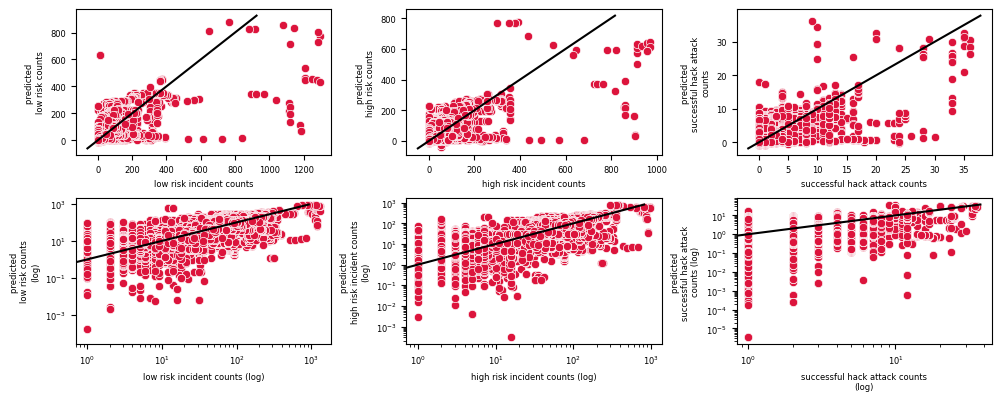

In [918]:
# Plot real incident counts against predicted counts

# graph_df = y_test.reset_index(drop=True).join(pd.DataFrame(y_pred, columns=['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack'])).join(features5)

graph_df = results4.copy().rename(columns={'pred lr': 'pred_low_risk', 'pred hr':'pred_high_risk', 'pred sha':'pred_successful_hack_attack'})

all_cols = graph_df.columns.values
avg_freq_cols = [x for x in graph_df.columns.values if x.startswith('freq') or x.startswith('avg_')]
select_cols = list(set(all_cols) - set(['pred_low_risk', 'pred_high_risk', 'pred_successful_hack_attack', 'low_risk', 'high_risk', 'successful_hack_attack']) - set(avg_freq_cols))

fig, ax = plt.subplots(2,3,figsize=(10,4))
g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[0][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][0].set_xlabel('low risk incident counts')
ax[0][0].set_ylabel('predicted \nlow risk counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[0][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][1].set_xlabel('high risk incident counts')
ax[0][1].set_ylabel('predicted \nhigh risk counts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[0][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[0][2].set_xlabel('successful hack attack counts')
ax[0][2].set_ylabel('predicted \nsuccessful hack attack \ncounts')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['low_risk'], y=graph_df['pred_low_risk'], ax=ax[1][0], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][0].set_xlabel('low risk incident counts (log)')
ax[1][0].set_ylabel('predicted \nlow risk counts\n(log)')
ax[1][0].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['high_risk'], y=graph_df['pred_high_risk'], ax=ax[1][1], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][1].set_xlabel('high risk incident counts (log)')
ax[1][1].set_ylabel('predicted \nhigh risk incident counts\n(log)')
ax[1][1].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')

g = sns.scatterplot(x=graph_df['successful_hack_attack'], y=graph_df['pred_successful_hack_attack'], ax=ax[1][2], color='crimson')
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax[1][2].set_xlabel('successful hack attack counts\n(log)')
ax[1][2].set_ylabel('predicted \nsuccessful hack attack \ncounts (log)')
ax[1][2].set(xscale='log', yscale='log')
g.plot(lims, lims, color='black')


plt.tight_layout()

# fig.savefig('figures/real-vs-pred.pdf')
# fig.savefig('figures/real-vs-pred.png')

In [930]:
print('Low Risk Mean Absolute Error:', mean_absolute_error(results4['low_risk'], results4['pred lr'], ))
print('High Risk Mean Absolute Error:', mean_absolute_error(results4['high_risk'], results4['pred hr'], ))
print('Successful hack attack Mean Absolute Error:', mean_absolute_error(results4['successful_hack_attack'], results4['pred sha'],))

Low Risk Mean Absolute Error: 12.45942570212197
High Risk Mean Absolute Error: 10.330406004634044
Successful hack attack Mean Absolute Error: 0.5349506221631984


In [931]:
print('Low Risk Root Mean Squared Error:', mean_squared_error(results4['low_risk'], results4['pred lr'], squared=False))
print('High Risk Root Mean Squared Error:', mean_squared_error(results4['high_risk'], results4['pred hr'], squared=False))
print('Successful hack attack Root Mean Squared Error:', mean_squared_error(results4['successful_hack_attack'], results4['pred sha'], squared=False))

Low Risk Root Mean Squared Error: 32.103009364538615
High Risk Root Mean Squared Error: 24.566441121053963
Successful hack attack Root Mean Squared Error: 1.490346462015094


In [932]:
print('Low Risk R2 score:', r2_score(results4['low_risk'], results4['pred lr'], ))
print('High Risk R2 score:', r2_score(results4['high_risk'], results4['pred hr'], ))
print('Successful R2 score:', r2_score(results4['successful_hack_attack'], results4['pred sha'],))

Low Risk R2 score: 0.44050389997509043
High Risk R2 score: 0.4950709228486362
Successful R2 score: 0.41748904352724603


In [933]:
print('Total MAE:', mean_absolute_error(results4[['low_risk', 'high_risk', 'successful_hack_attack']], results4[['pred lr', 'pred hr', 'pred sha']], ))
print('Total RMSE:', mean_squared_error(results4[['low_risk', 'high_risk', 'successful_hack_attack']], results4[['pred lr', 'pred hr', 'pred sha']],squared=False ))
print('Total Risk R2 score:', r2_score(results4[['low_risk', 'high_risk', 'successful_hack_attack']], results4[['pred lr', 'pred hr', 'pred sha']], ))

Total MAE: 7.774927442973071
Total RMSE: 19.38659898253589
Total Risk R2 score: 0.45102128878365755
